In [259]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
#from google.colab.data_table import DataTable
import geopandas as gpd
from matplotlib.lines import Line2D
pd.set_option('display.max_columns', 100)
#DataTable.max_columns = 1000
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style="darkgrid")

from category_encoders import BinaryEncoder

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


In [260]:
df = pd.read_csv('../Datasets/CleanedDS.csv')

In [261]:
df.head()

CountryCode        Date  ConfirmedCases  ConfirmedDeaths MajorityVaccinated  \
0         AFG  2020-01-01             0.0              0.0                 NV   
1         BRA  2020-01-01             0.0              0.0                 NV   
2         NLD  2020-01-01             0.0              0.0                 NV   
3         ZAF  2020-01-01             0.0              0.0                 NV   
4         NOR  2020-01-01             0.0              0.0                 NV   

   StringencyIndex_Average  GovernmentResponseIndex_Average  \
0                      0.0                              0.0   
1                      0.0                              0.0   
2                      0.0                              0.0   
3                      0.0                              0.0   
4                      0.0                              0.0   

   ContainmentHealthIndex_Average  EconomicSupportIndex   Population  \
0                             0.0                   0.0   41128772.0   
1                             0.0                   0.0  215313504.0   
2                             0.0                   0.0   17564020.0   
3                             0.0                   0.0   59893884.0   
4                             0.0                   0.0    5434324.0   

   GDP_Per_Capita  Life_Expectancy  Hospital_Beds_Per_Thousand  \
0        1803.987            64.83                        0.50   
1       14103.452            75.88                        2.20   
2       48472.545            82.28                        3.32   
3       12294.876            64.13                        2.32   
4       64800.057            82.40                        3.60   

   Mortality Rate   H5  V1  V3  Mortality_Rate_7day_MA  ConfirmedCases_7day_MA  
0             0.0  0.0   0   0                     0.0                     0.0  
1             0.0  0.0   0   0                     0.0                     0.0  
2             0.0  0.0   0   0                     0.0                     0.0  
3             0.0  0.0   0   0                     0.0                     0.0  
4             0.0  0.0   0   0                     0.0                     0.0

### Country-Specific Plots

In [4]:
countries =  ['USA', 'CHN', 'SWE', 'FIN', 'PAK', 'IDN', 'IND', 'AUS', 'JPN']
justViewing = df[df['CountryCode'].isin(countries)]
justViewing.shape

(9864, 19)

In [5]:
df.columns

Index(['CountryCode', 'Date', 'ConfirmedCases', 'ConfirmedDeaths',
       'MajorityVaccinated', 'StringencyIndex_Average',
       'GovernmentResponseIndex_Average', 'ContainmentHealthIndex_Average',
       'EconomicSupportIndex', 'Population', 'GDP_Per_Capita',
       'Life_Expectancy', 'Hospital_Beds_Per_Thousand', 'Mortality Rate', 'H5',
       'V1', 'V3', 'Mortality_Rate_7day_MA', 'ConfirmedCases_7day_MA'],
      dtype='object')

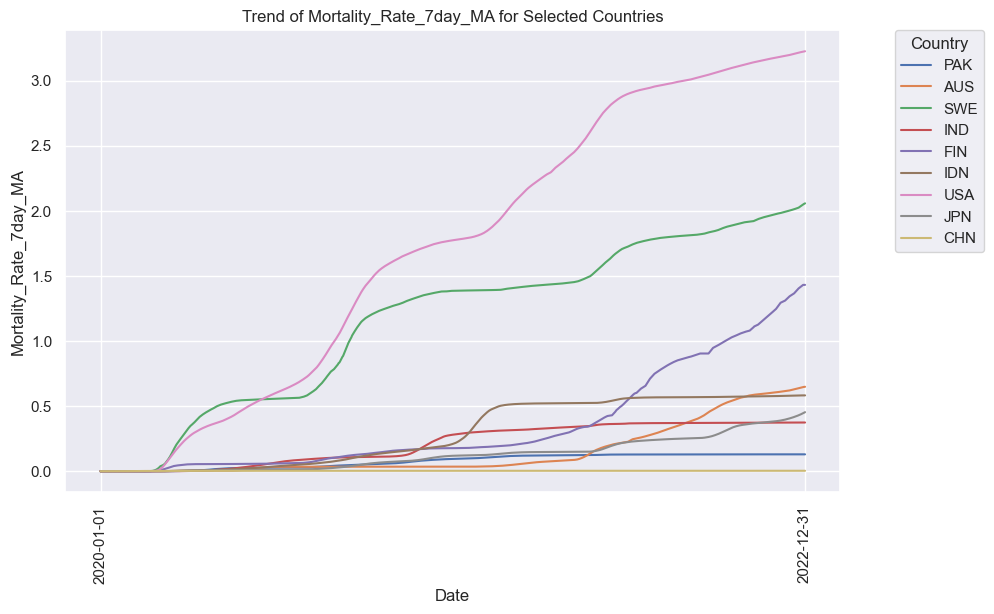

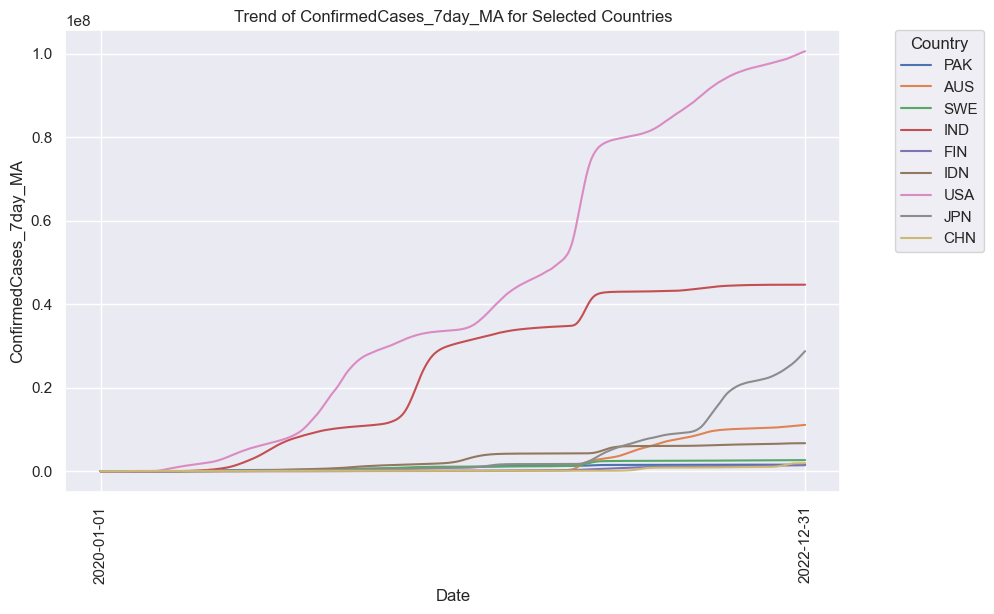

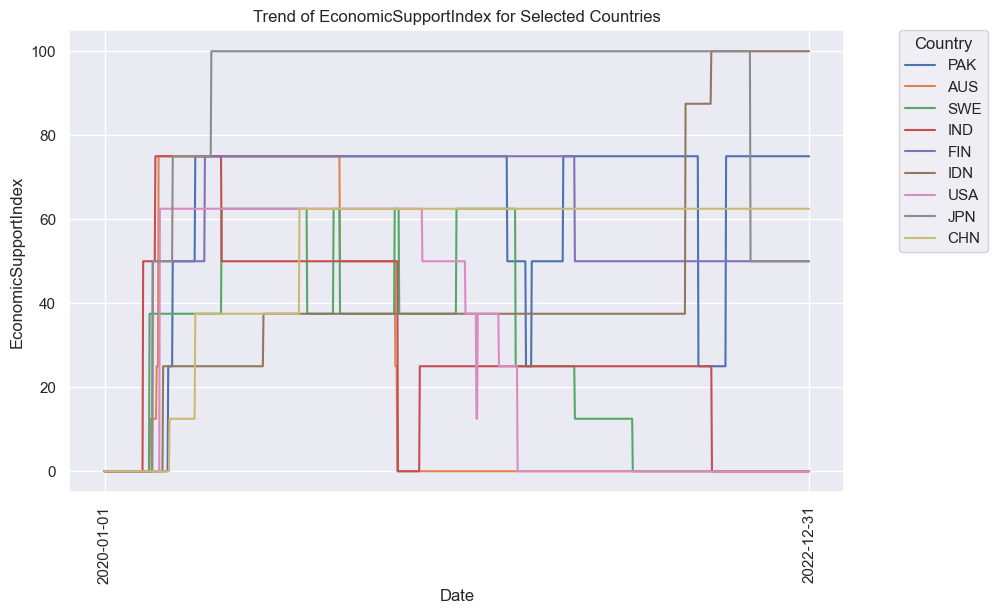

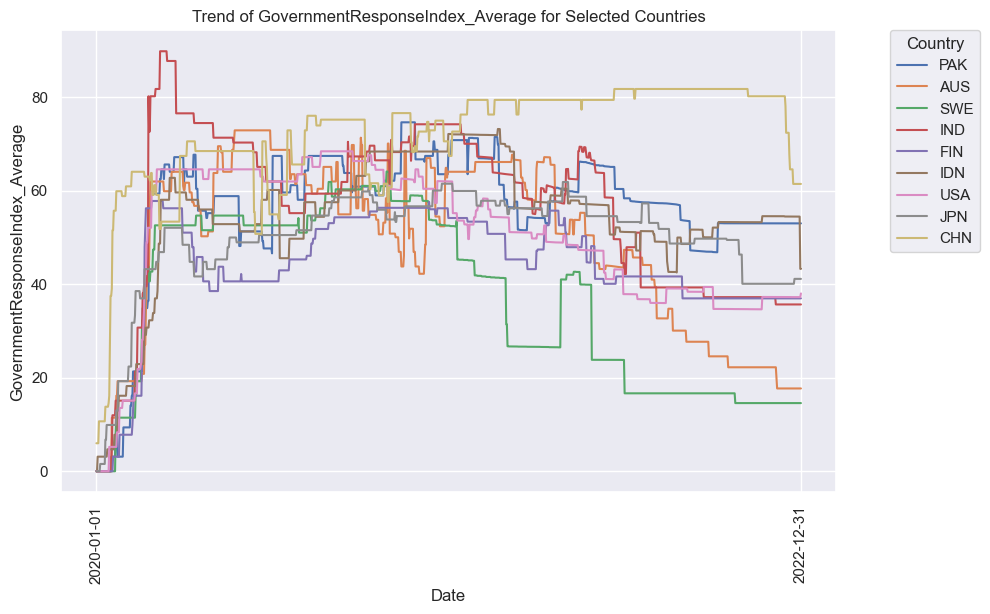

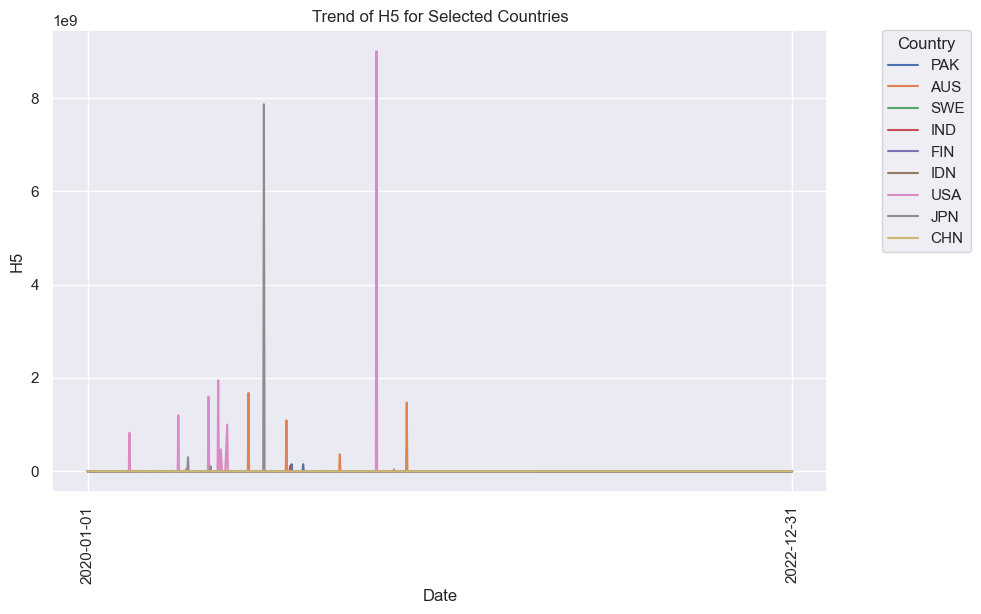

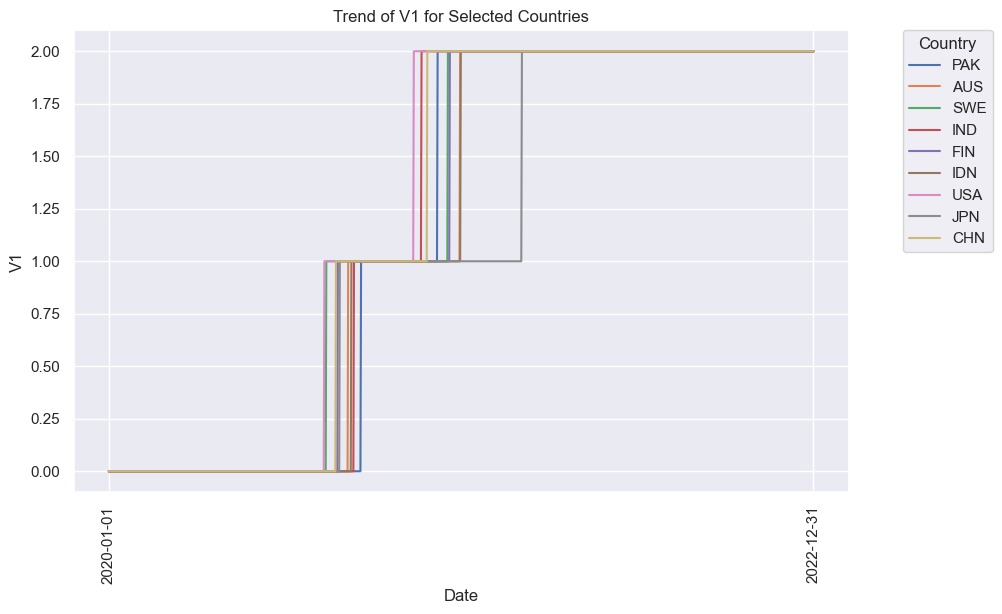

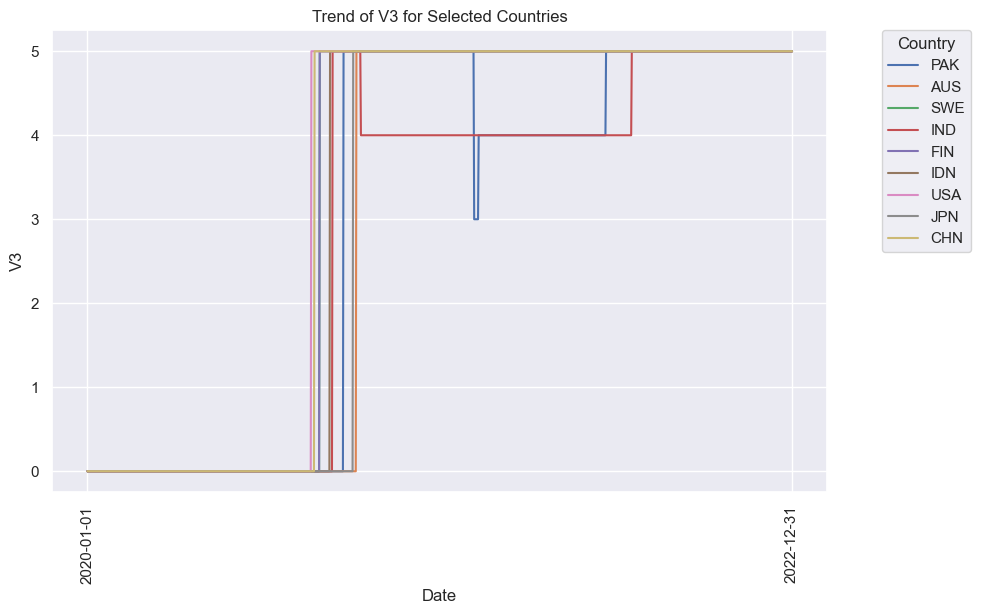

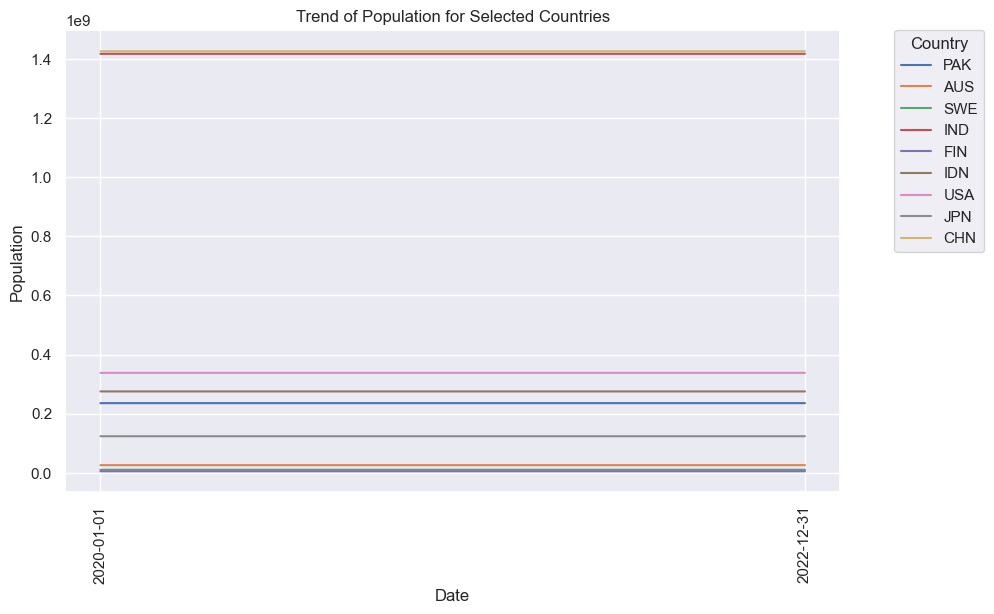

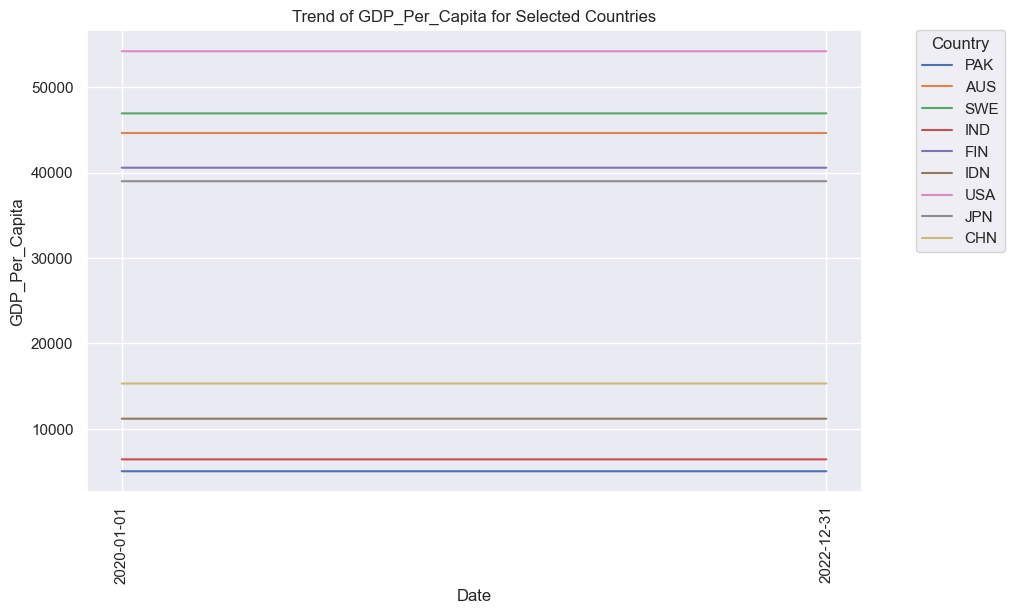

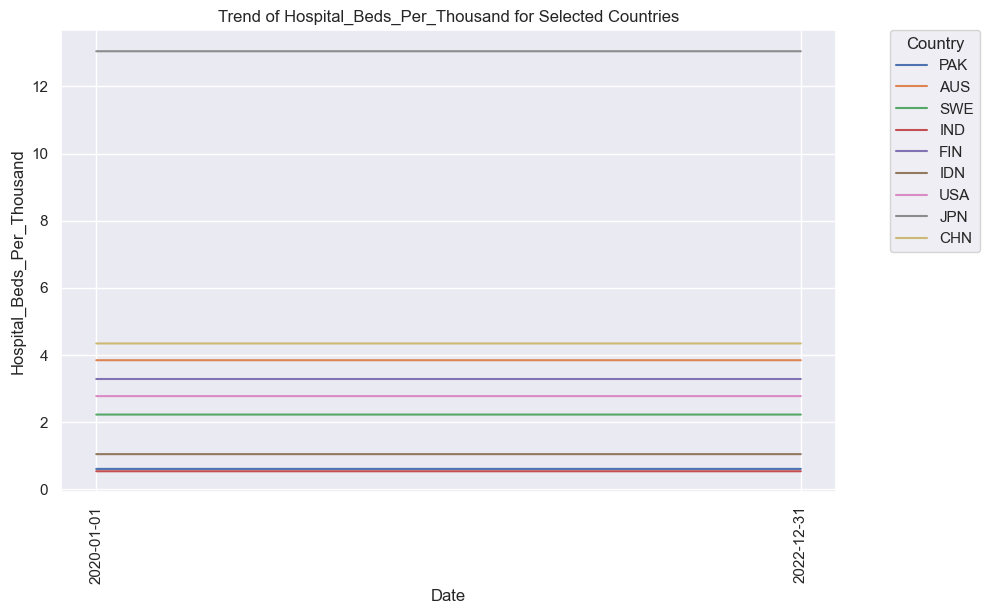

In [6]:
selectedColumns = ['Mortality_Rate_7day_MA', 'ConfirmedCases_7day_MA', 'EconomicSupportIndex','GovernmentResponseIndex_Average', 'H5',
       'V1', 'V3', 'Population', 'GDP_Per_Capita', 'Hospital_Beds_Per_Thousand']

start_date = justViewing['Date'].min()
end_date = justViewing['Date'].max()

for column in selectedColumns:
    plt.figure(figsize=(10, 6)) 
    sns.lineplot(data=justViewing, x='Date', y=column, hue='CountryCode')
    plt.title(f'Trend of {column} for Selected Countries')
    plt.xlabel('Date')
    plt.xticks([start_date, end_date],rotation=90)
    plt.legend(title='Country',loc='upper left', bbox_to_anchor=(1.07, 1), borderaxespad=0.)
    plt.show()

####  Creating New Features

In [7]:
justViewing = justViewing.sort_values(by=['CountryCode', 'Date'])
justViewing['changeInCC'] = justViewing.groupby(['CountryCode'])['ConfirmedCases'].transform(lambda x: x.diff())
justViewing['changeInMR'] = justViewing.groupby(['CountryCode'])['Mortality Rate'].transform(lambda x: x.diff())
justViewing = justViewing.replace(np.nan, 0)

justViewing['ChangeCC_7dayMA'] = justViewing.groupby(['CountryCode'])['changeInCC'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
justViewing['ChangeMR_7dayMA'] = justViewing.groupby(['CountryCode'])['changeInMR'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)

justViewing.head(1)


CountryCode        Date  ConfirmedCases  ConfirmedDeaths  \
44         AUS  2020-01-01             0.0              0.0   

   MajorityVaccinated  StringencyIndex_Average  \
44                 NV                      0.0   

    GovernmentResponseIndex_Average  ContainmentHealthIndex_Average  \
44                              0.0                             0.0   

    EconomicSupportIndex  Population  GDP_Per_Capita  Life_Expectancy  \
44                   0.0  26177410.0        44648.71            83.44   

    Hospital_Beds_Per_Thousand  Mortality Rate   H5  V1  V3  \
44                        3.84             0.0  0.0   0   0   

    Mortality_Rate_7day_MA  ConfirmedCases_7day_MA  changeInCC  changeInMR  \
44                     0.0                     0.0         0.0         0.0   

    ChangeCC_7dayMA  ChangeMR_7dayMA  
44              0.0              0.0

In [8]:
justViewing['ChangeMR_14dayMA'] = justViewing.groupby(['CountryCode'])['changeInMR'].rolling(window=14, min_periods=1).mean().reset_index(0, drop=True)

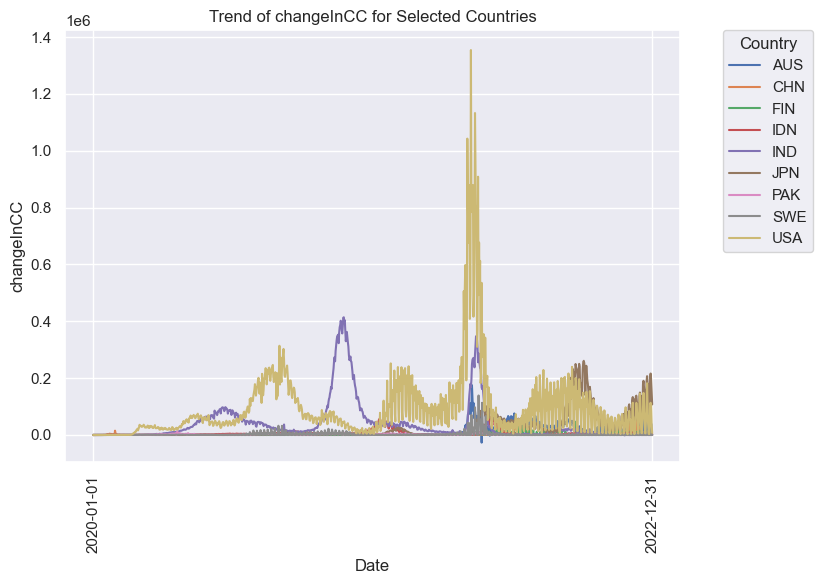

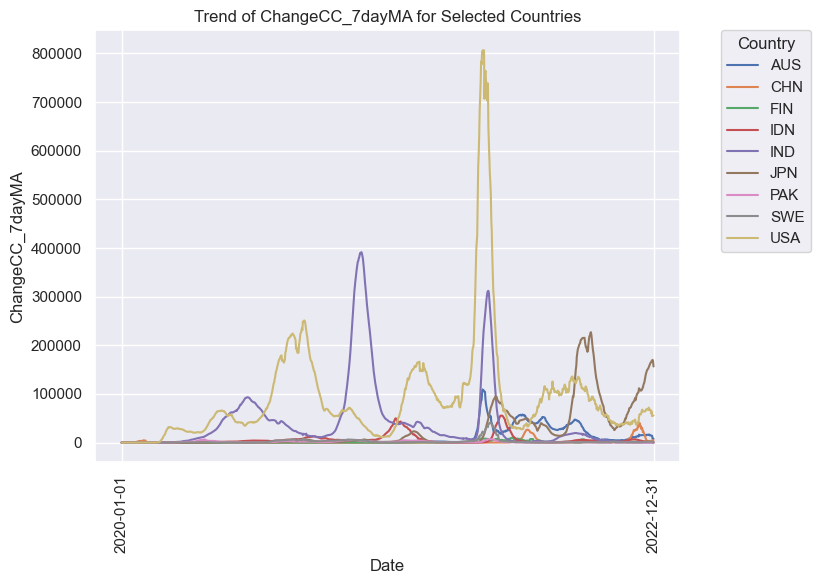

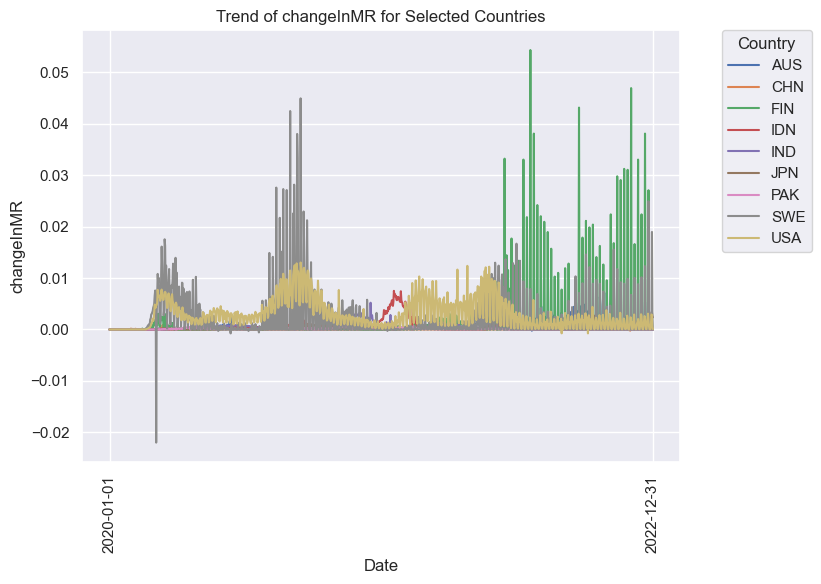

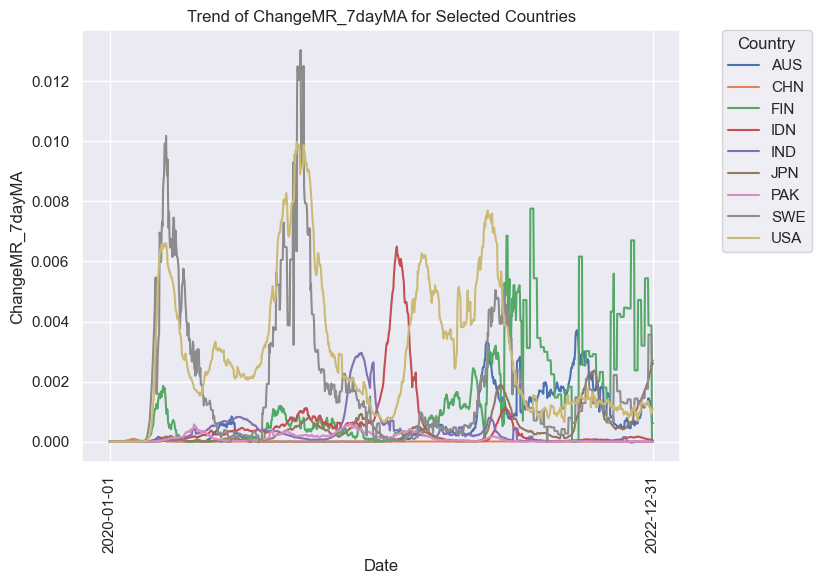

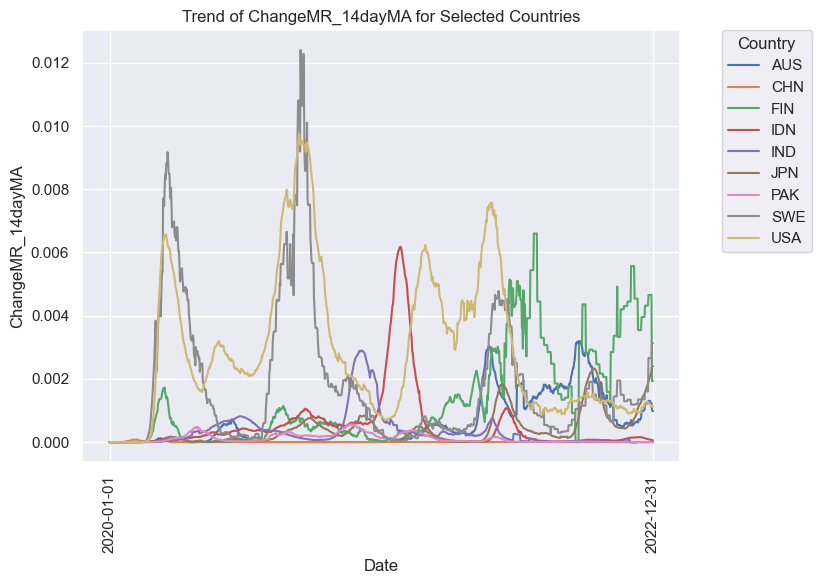

In [9]:
selectedColumns = ['changeInCC', 'ChangeCC_7dayMA','changeInMR','ChangeMR_7dayMA', 'ChangeMR_14dayMA']
start_date = justViewing['Date'].min()
end_date = justViewing['Date'].max()


for column in selectedColumns:
    plt.figure(figsize=(10, 6))  # Set the figure size
    sns.lineplot(data=justViewing, x='Date', y=column, hue='CountryCode')
    plt.title(f'Trend of {column} for Selected Countries')
    plt.xlabel('Date')
    plt.xticks([start_date, end_date],rotation=90)
    plt.legend(title='Country',loc='upper left', bbox_to_anchor=(1.07, 1), borderaxespad=0.)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

In [10]:
justViewing[justViewing['CountryCode'] == 'CHN']['ConfirmedCases']

126             0.0
261             0.0
300             0.0
450             0.0
732             0.0
            ...    
163664    1933112.0
163867    1938214.0
164071    1943729.0
164163    1950933.0
164313    1956071.0
Name: ConfirmedCases, Length: 1096, dtype: float64

In [11]:
justViewing.head()

CountryCode        Date  ConfirmedCases  ConfirmedDeaths  \
44          AUS  2020-01-01             0.0              0.0   
254         AUS  2020-01-02             0.0              0.0   
378         AUS  2020-01-03             0.0              0.0   
550         AUS  2020-01-04             0.0              0.0   
677         AUS  2020-01-05             0.0              0.0   

    MajorityVaccinated  StringencyIndex_Average  \
44                  NV                      0.0   
254                 NV                      0.0   
378                 NV                      0.0   
550                 NV                      0.0   
677                 NV                      0.0   

     GovernmentResponseIndex_Average  ContainmentHealthIndex_Average  \
44                               0.0                             0.0   
254                              0.0                             0.0   
378                              0.0                             0.0   
550                              0.0                             0.0   
677                              0.0                             0.0   

     EconomicSupportIndex  Population  GDP_Per_Capita  Life_Expectancy  \
44                    0.0  26177410.0        44648.71            83.44   
254                   0.0  26177410.0        44648.71            83.44   
378                   0.0  26177410.0        44648.71            83.44   
550                   0.0  26177410.0        44648.71            83.44   
677                   0.0  26177410.0        44648.71            83.44   

     Hospital_Beds_Per_Thousand  Mortality Rate   H5  V1  V3  \
44                         3.84             0.0  0.0   0   0   
254                        3.84             0.0  0.0   0   0   
378                        3.84             0.0  0.0   0   0   
550                        3.84             0.0  0.0   0   0   
677                        3.84             0.0  0.0   0   0   

     Mortality_Rate_7day_MA  ConfirmedCases_7day_MA  changeInCC  changeInMR  \
44                      0.0                     0.0         0.0         0.0   
254                     0.0                     0.0         0.0         0.0   
378                     0.0                     0.0         0.0         0.0   
550                     0.0                     0.0         0.0         0.0   
677                     0.0                     0.0         0.0         0.0   

     ChangeCC_7dayMA  ChangeMR_7dayMA  ChangeMR_14dayMA  
44               0.0              0.0               0.0  
254              0.0              0.0               0.0  
378              0.0              0.0               0.0  
550              0.0              0.0               0.0  
677              0.0              0.0               0.0

In [12]:
justViewing[justViewing['CountryCode'] == 'GER']['Date']

Series([], Name: Date, dtype: object)

#### Daily Change in ConfirmedCases

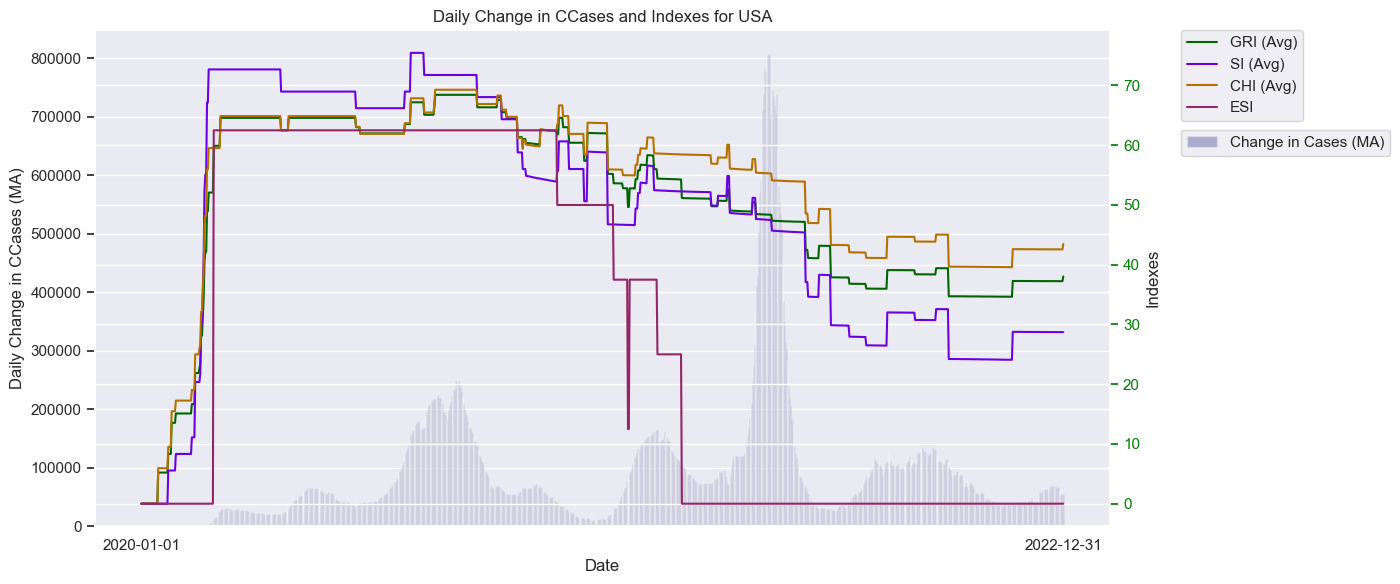

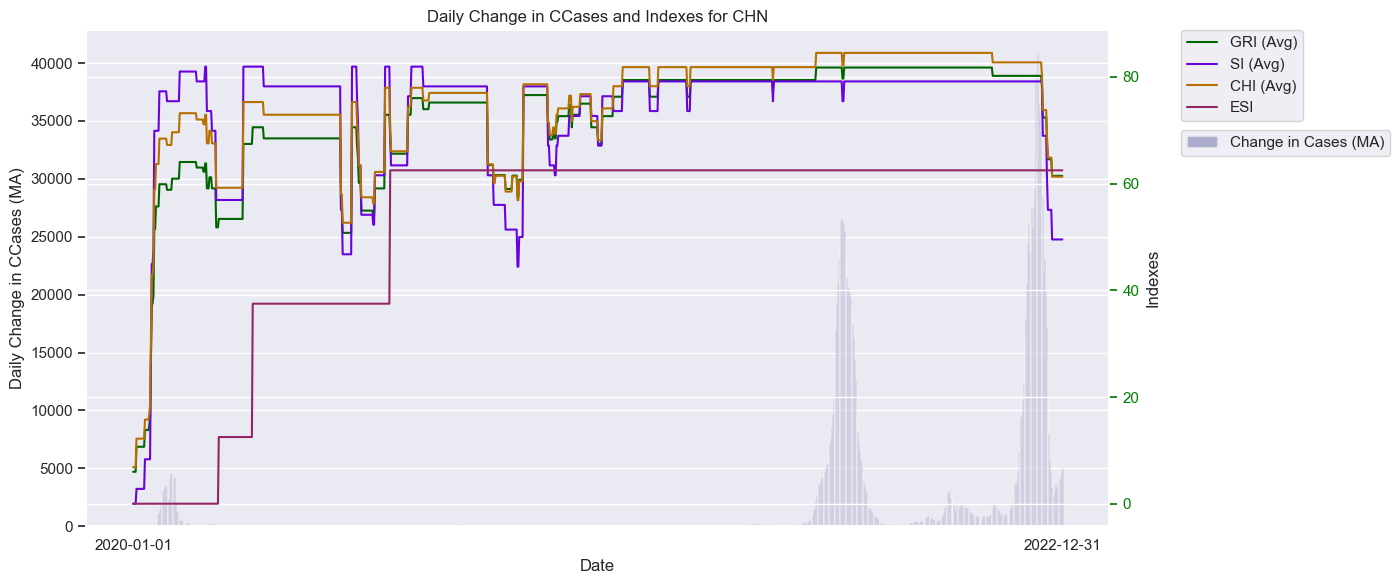

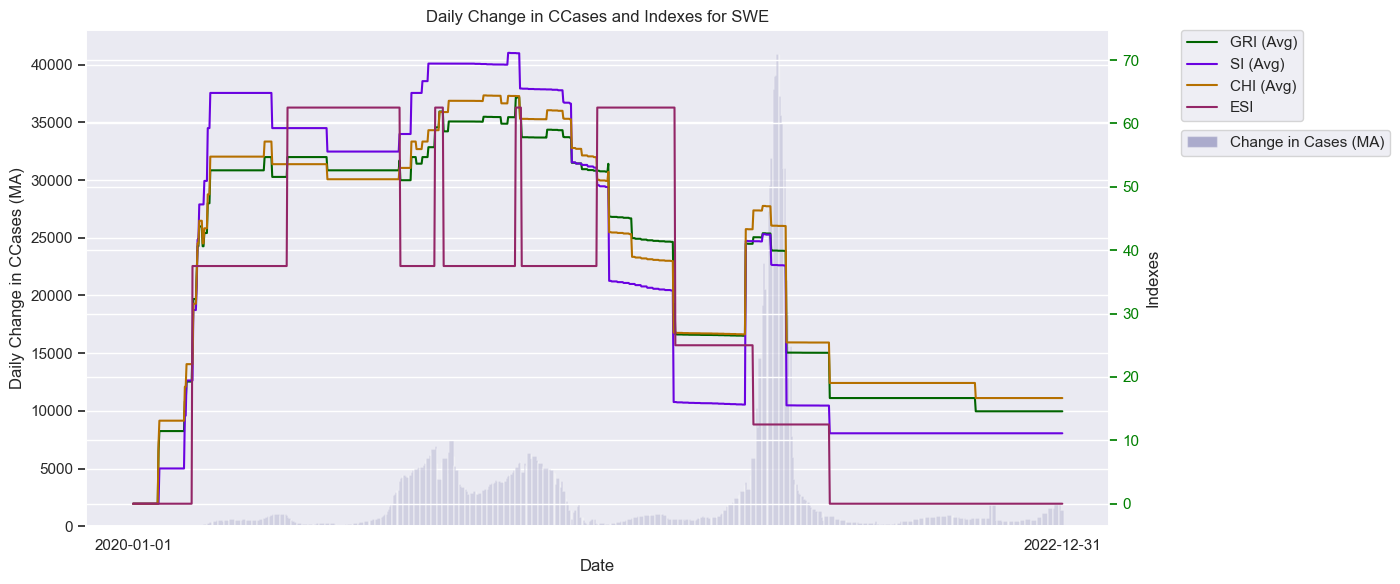

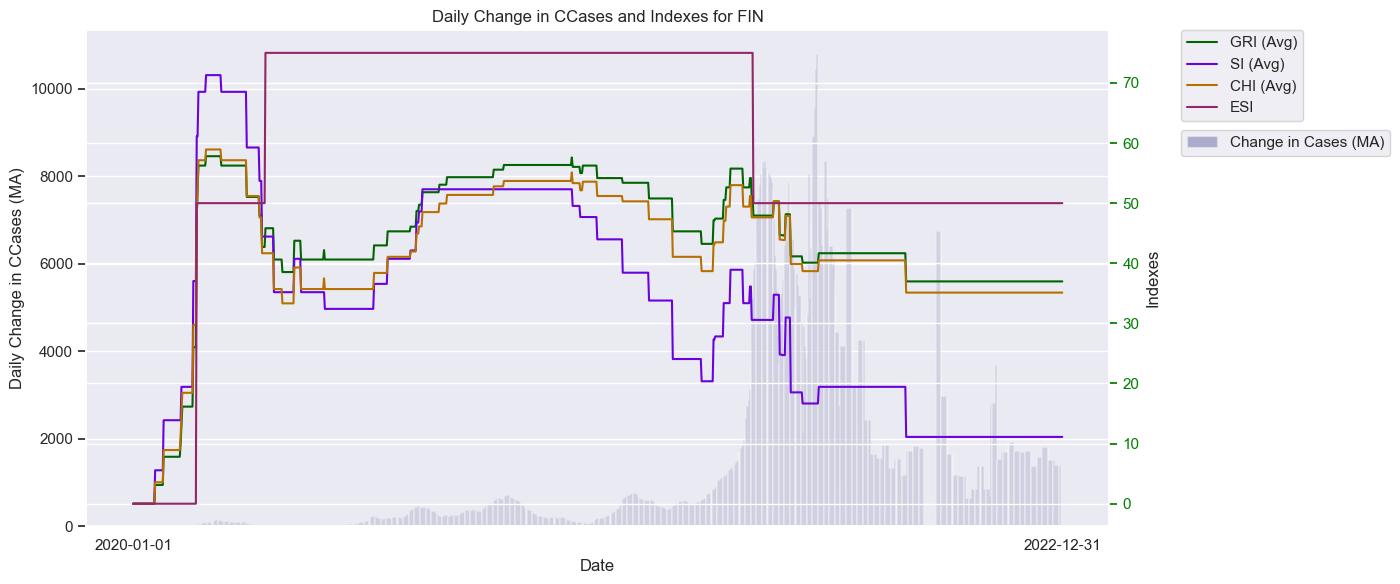

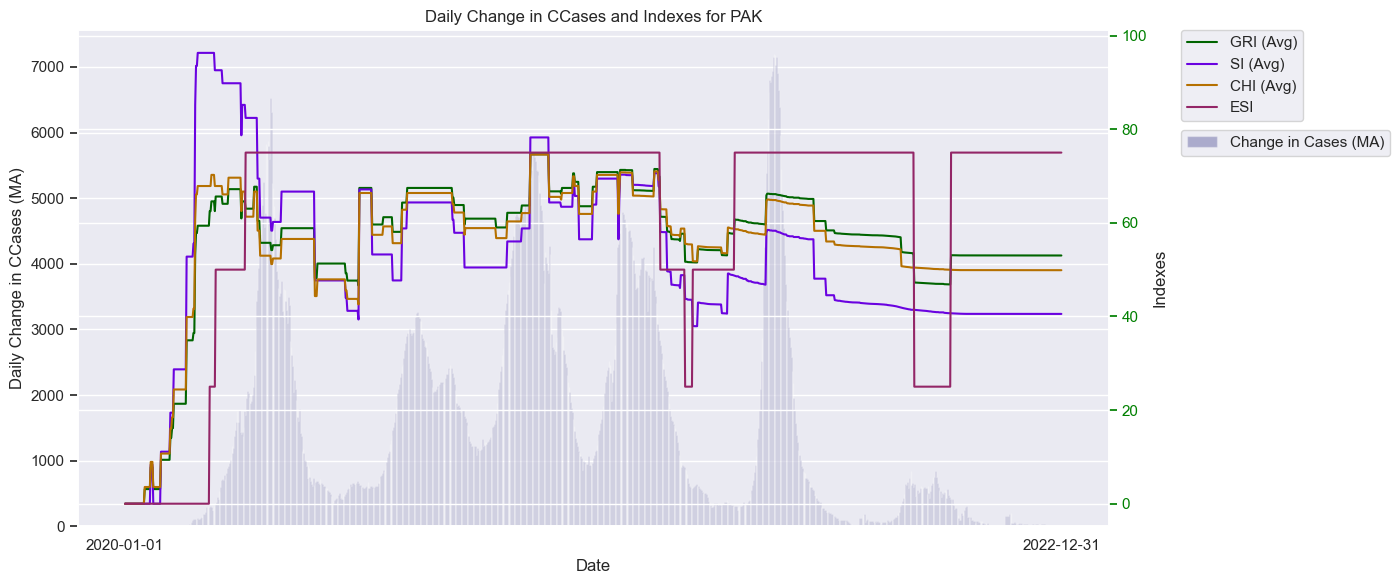

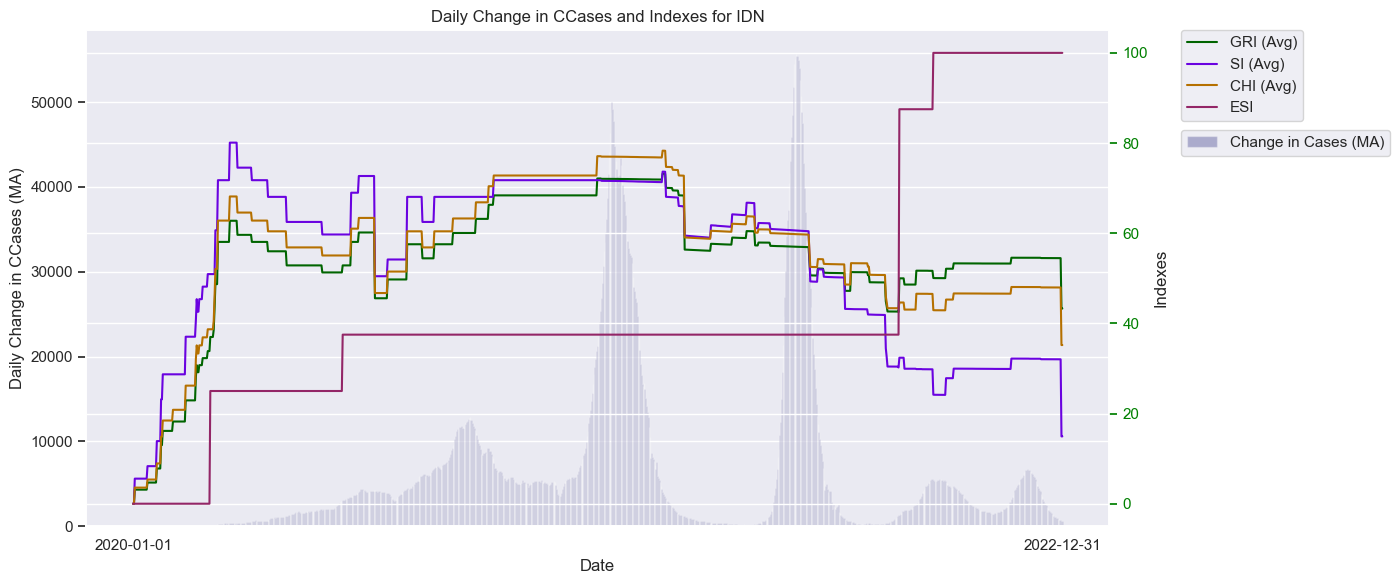

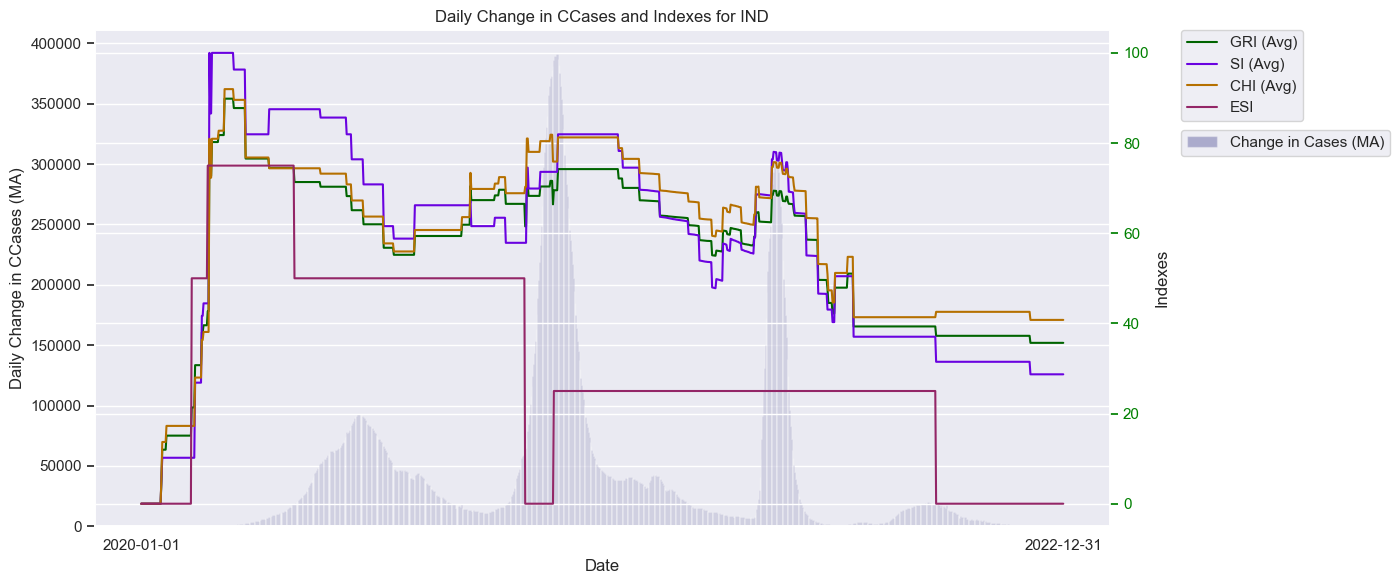

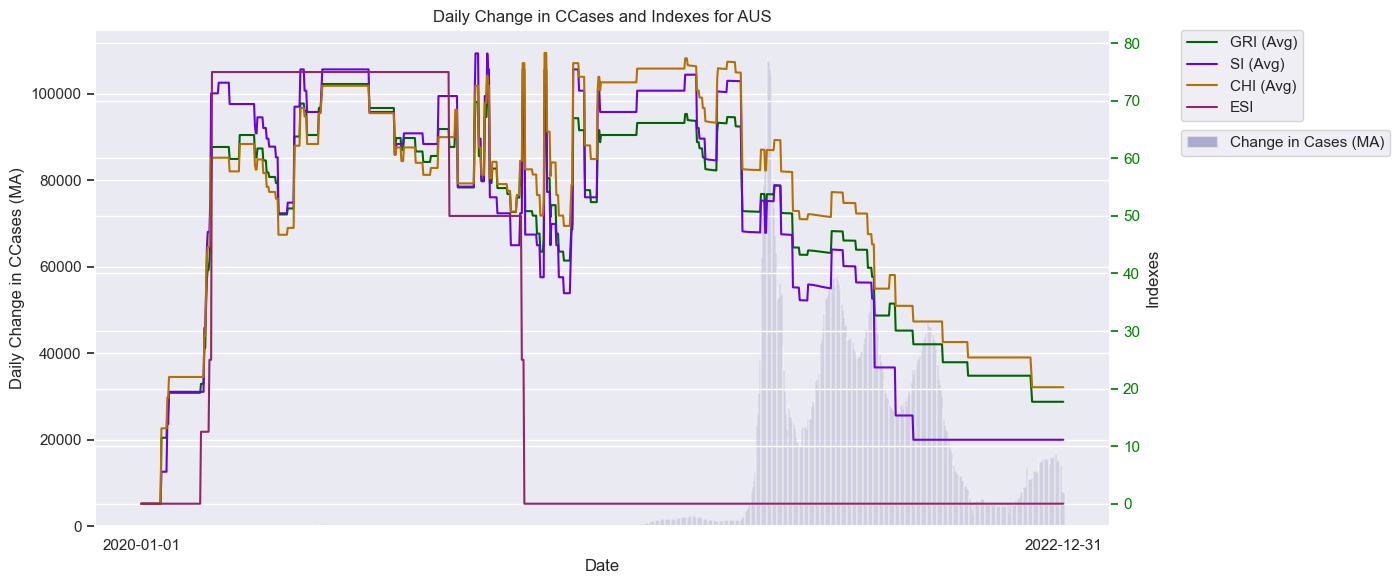

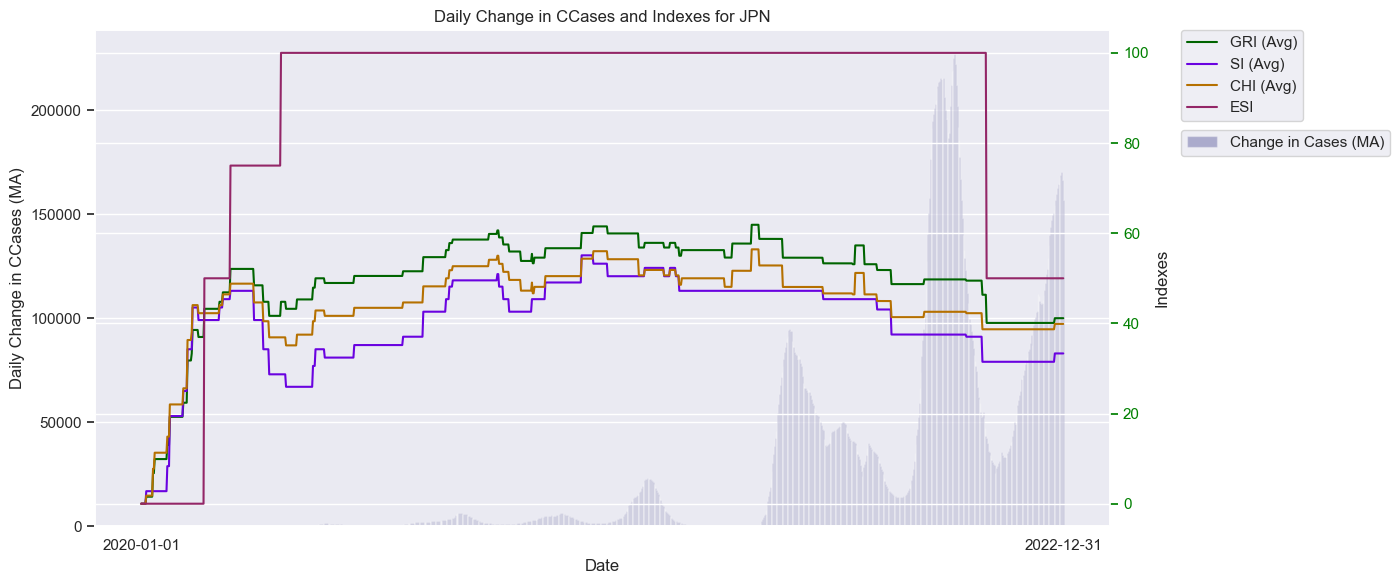

In [13]:
start_date = justViewing['Date'].min()
end_date = justViewing['Date'].max()

for idx, country in enumerate(countries):
    
    plt.figure(figsize=(14, 6))

    data = justViewing[justViewing['CountryCode'] == country].sort_values(by='Date')

    ax1 = sns.barplot(x='Date', y='ChangeCC_7dayMA', data=data, color='#040080',zorder=1,alpha=0.3,label='Change in Cases (MA)') 
    ax1.set_ylabel('Daily Change in CCases (MA)')
    ax1.set_title(f'Daily Change in CCases and Indexes for {country}')
    ax1.tick_params(axis='y', colors='#292929')

    ax2 = ax1.twinx()
    sns.lineplot(x='Date', y='GovernmentResponseIndex_Average', data=data, ax=ax2, color='darkgreen', label='GRI (Avg)')
    sns.lineplot(x='Date', y='StringencyIndex_Average', data=data, ax=ax2, color='#6a02e0', label='SI (Avg)')
    sns.lineplot(x='Date', y='ContainmentHealthIndex_Average', data=data, ax=ax2, color='#b57000', label='CHI (Avg)')
    sns.lineplot(x='Date', y='EconomicSupportIndex', data=data, ax=ax2, color='#932667', label='ESI')
    ax2.set_ylabel('Indexes')
    ax2.tick_params(axis='y', colors='green')
   
    ax1.legend(loc='upper left', bbox_to_anchor=(1.07, 0.8), borderaxespad=0.)
    ax2.legend(loc='upper left', bbox_to_anchor=(1.07, 1), borderaxespad=0.)
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    plt.xticks([start_date, end_date])
    plt.tight_layout()
    plt.show()

#### Daily Change in Mortality Rate

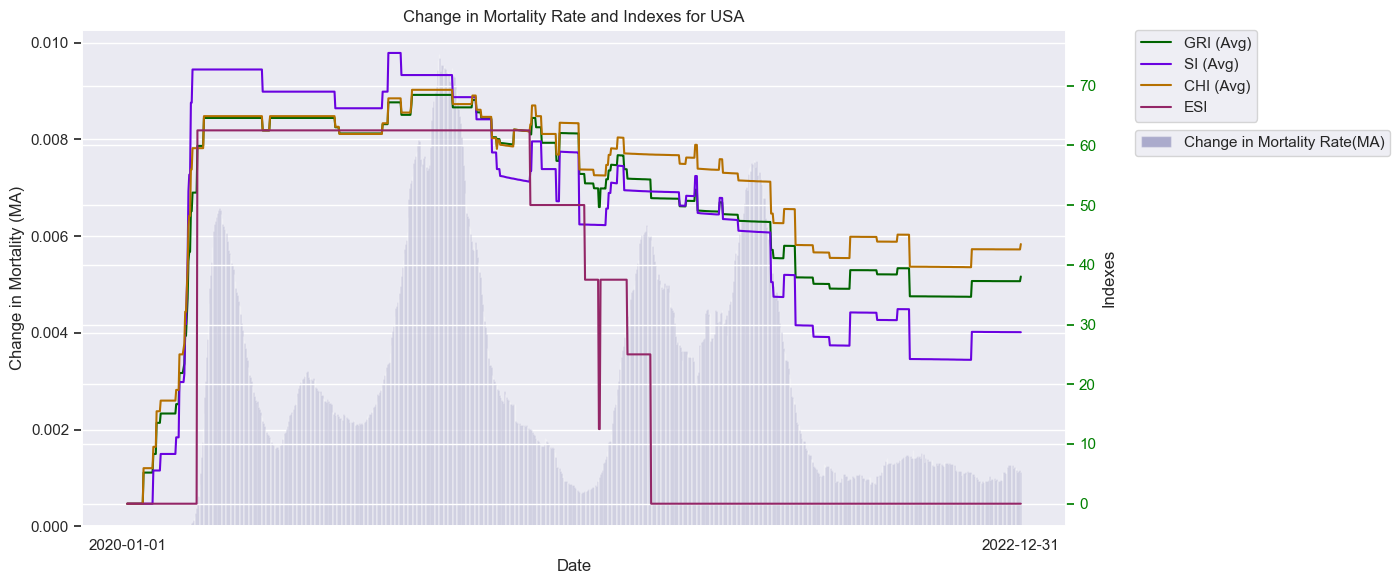

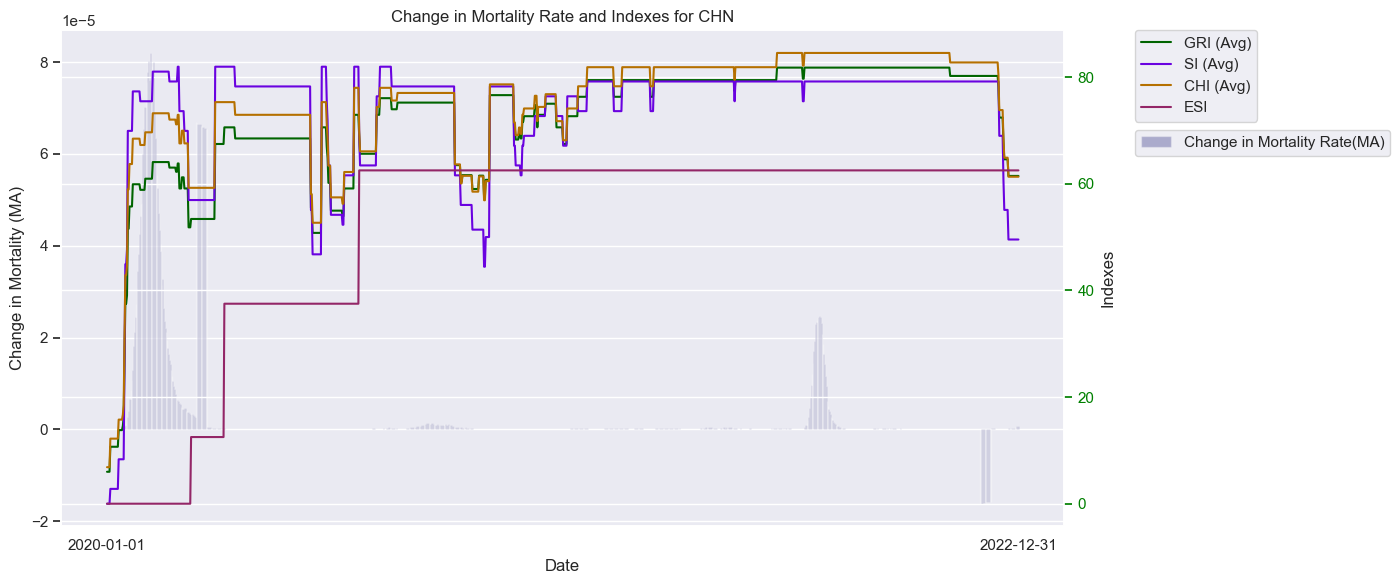

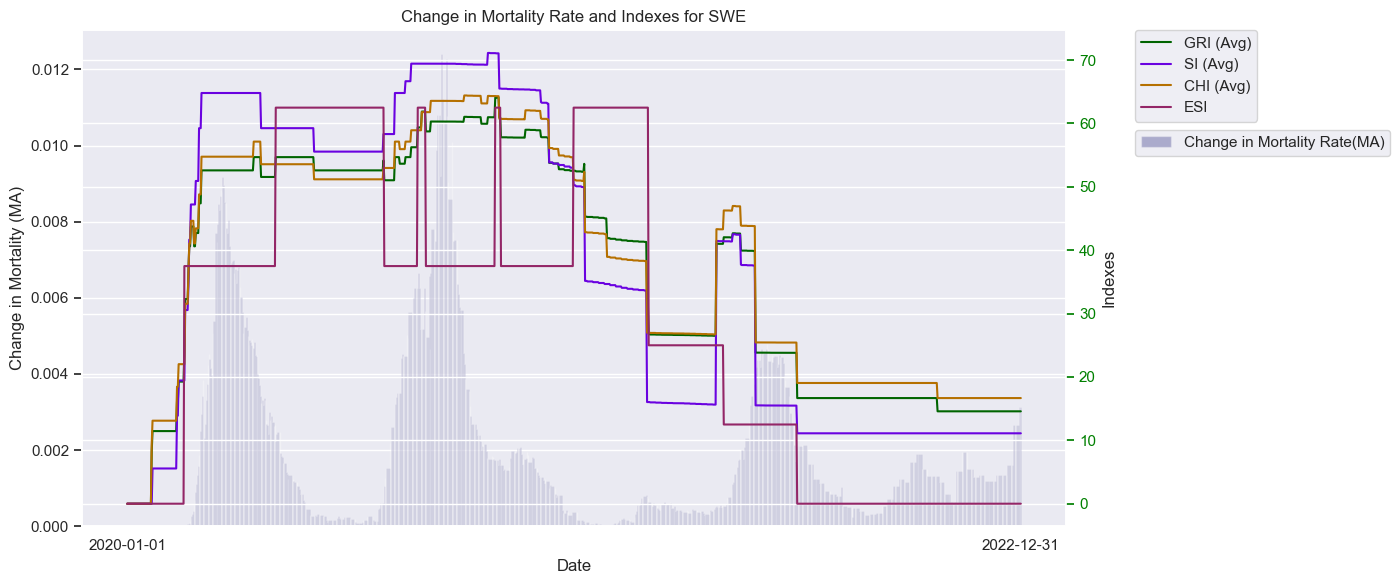

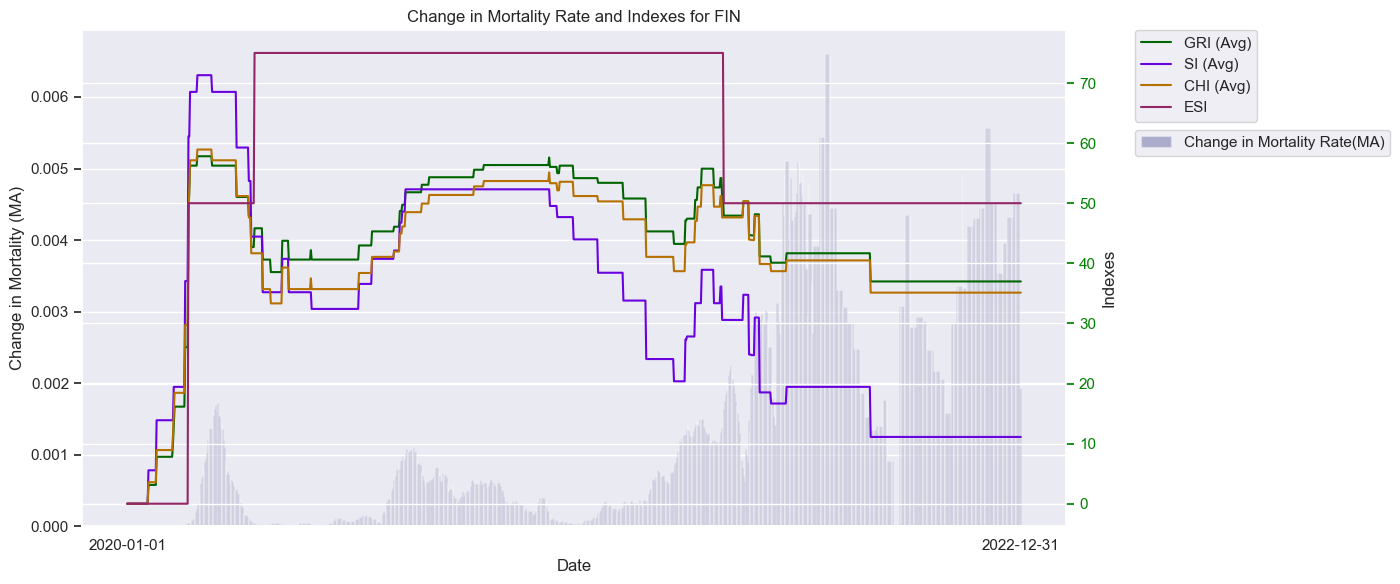

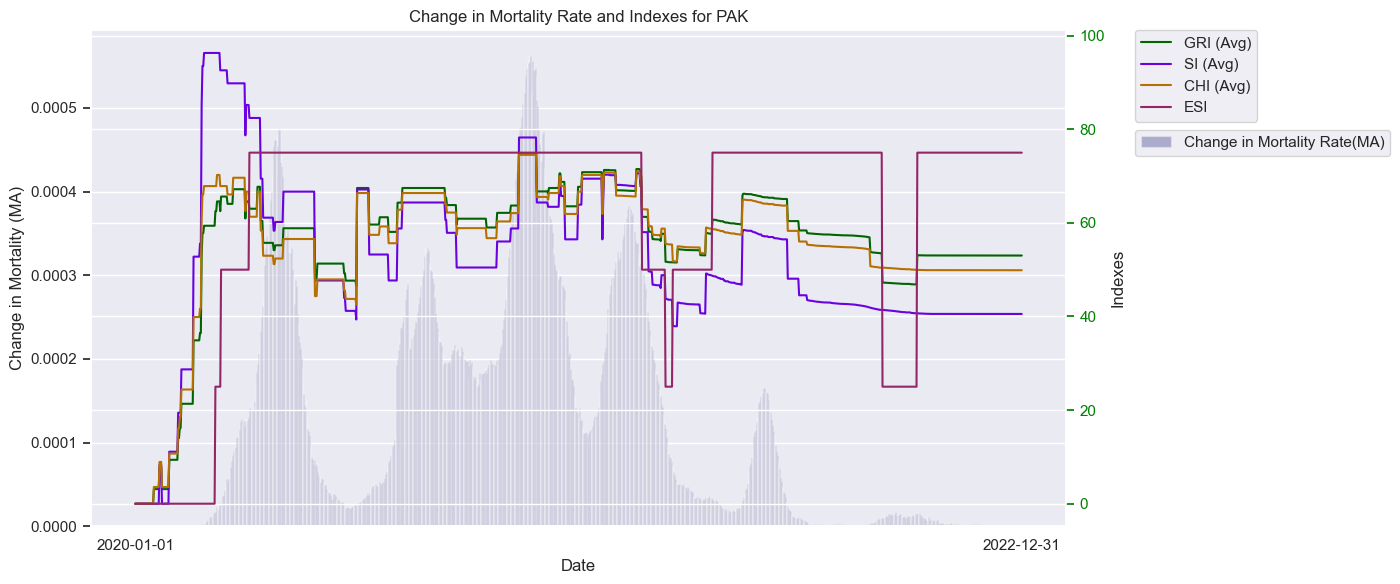

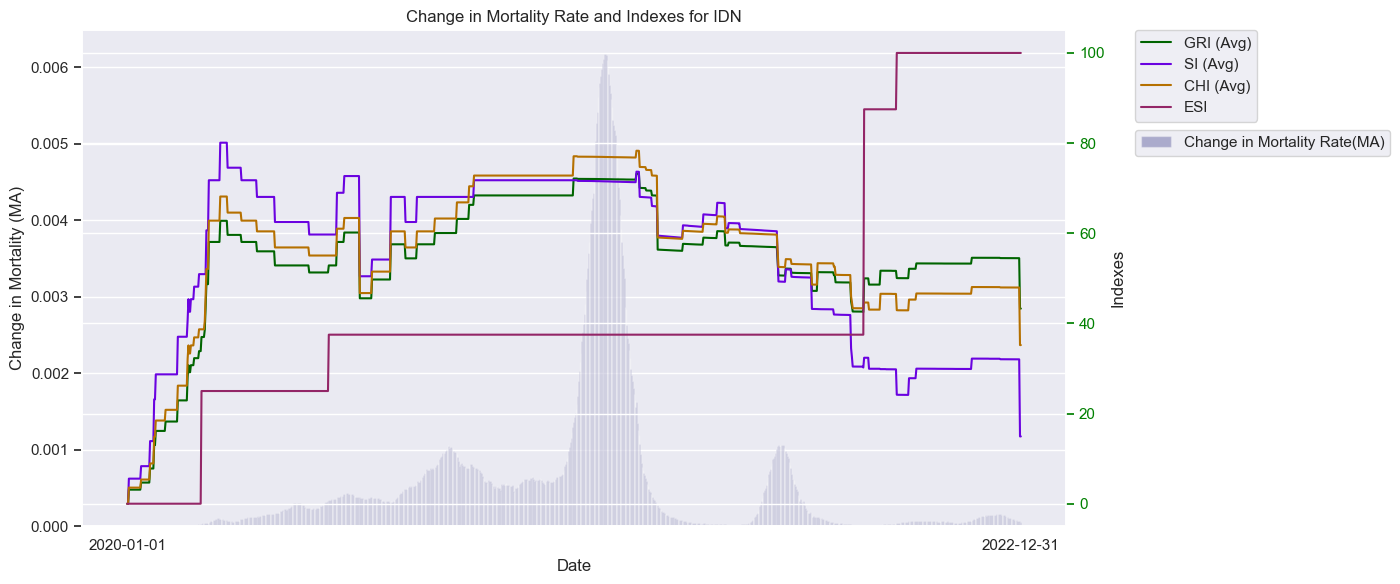

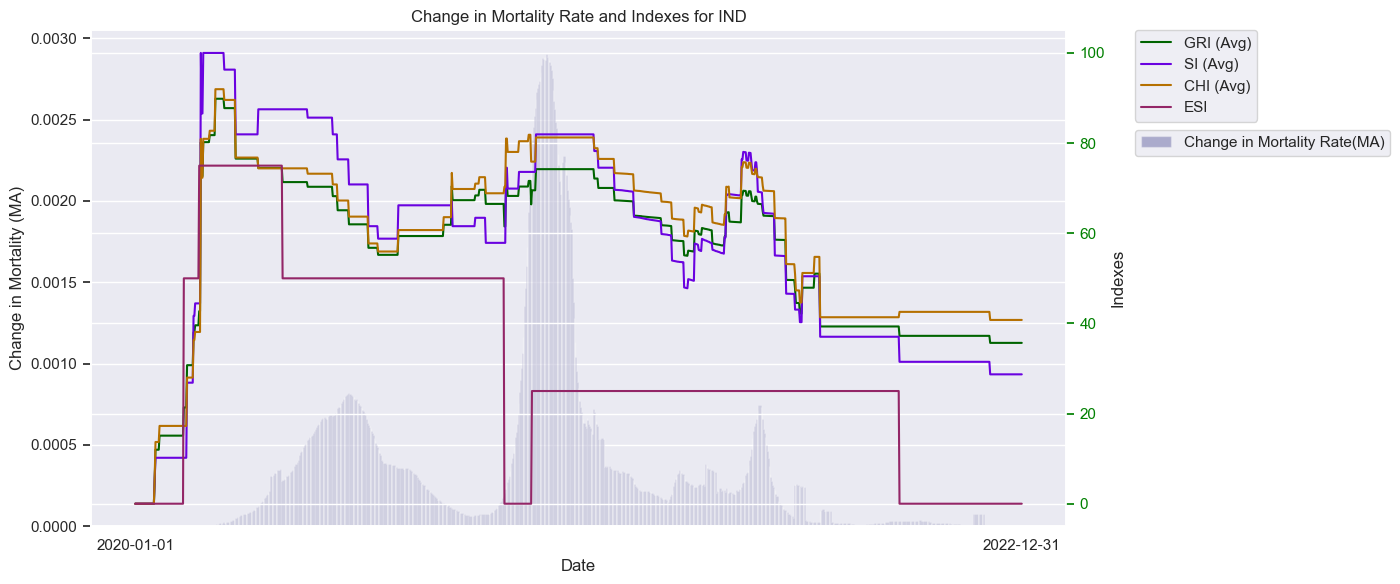

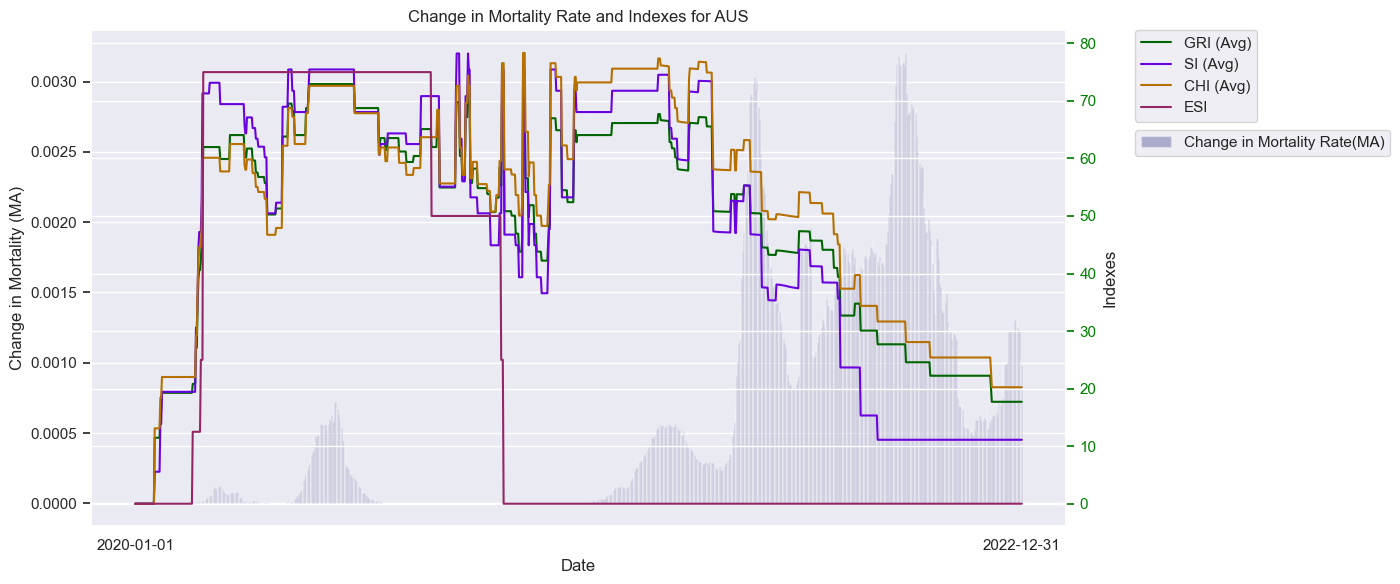

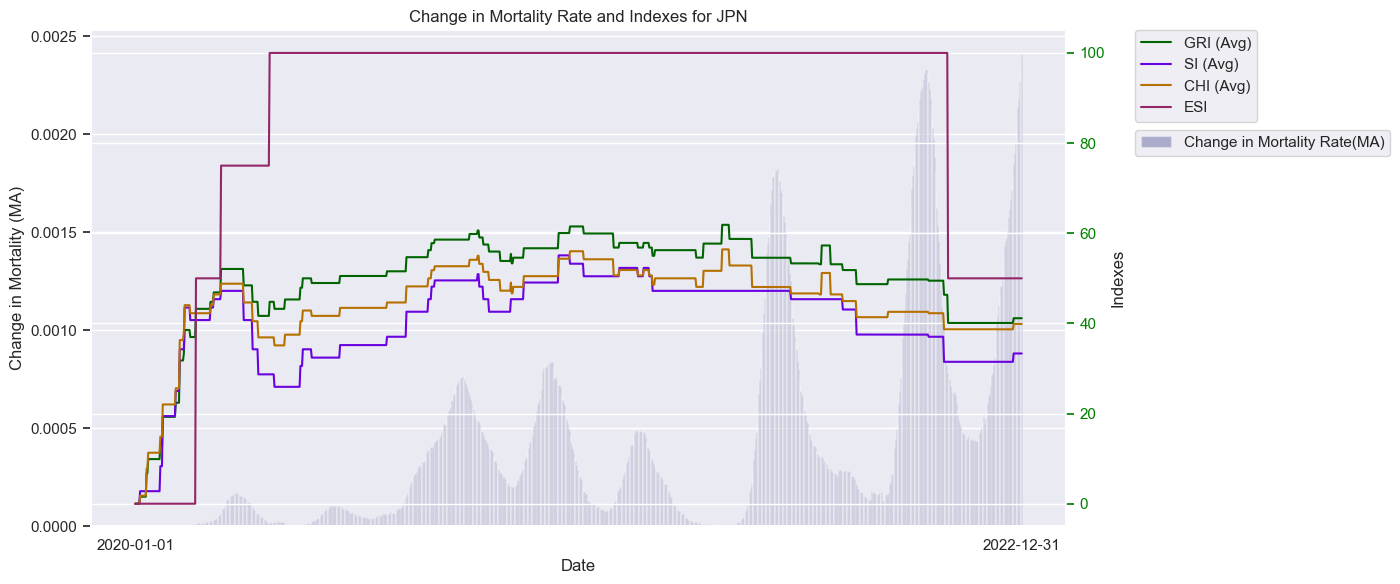

In [14]:
start_date = justViewing['Date'].min()
end_date = justViewing['Date'].max()

for idx, country in enumerate(countries):
    
    plt.figure(figsize=(14, 6))

    data = justViewing[justViewing['CountryCode'] == country].sort_values(by='Date')

    ax1 = sns.barplot(x='Date', y='ChangeMR_14dayMA', data=data, color='#040080',zorder=1,alpha=0.3,label='Change in Mortality Rate(MA)') 
    ax1.set_ylabel('Change in Mortality (MA)')
    ax1.set_title(f'Change in Mortality Rate and Indexes for {country}')
    ax1.tick_params(axis='y', colors='#292929')

    ax2 = ax1.twinx()
    sns.lineplot(x='Date', y='GovernmentResponseIndex_Average', data=data, ax=ax2, color='darkgreen', label='GRI (Avg)')
    sns.lineplot(x='Date', y='StringencyIndex_Average', data=data, ax=ax2, color='#6a02e0', label='SI (Avg)')
    sns.lineplot(x='Date', y='ContainmentHealthIndex_Average', data=data, ax=ax2, color='#b57000', label='CHI (Avg)')
    sns.lineplot(x='Date', y='EconomicSupportIndex', data=data, ax=ax2, color='#932667', label='ESI')
    ax2.set_ylabel('Indexes')
    ax2.tick_params(axis='y', colors='green')
   
    ax1.legend(loc='upper left', bbox_to_anchor=(1.07, 0.8), borderaxespad=0.)
    ax2.legend(loc='upper left', bbox_to_anchor=(1.07, 1), borderaxespad=0.)
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    plt.xticks([start_date, end_date])
    plt.tight_layout()
    plt.show()

#### Lagged Features

In [15]:
justViewing = justViewing.sort_values(by=['CountryCode', 'Date'])

def create_lagged_features(justViewing, columns, days):
    df_lagged = justViewing.copy()
    for day in days:
        for col in columns:
            df_lagged[col + f'_Lag{day}'] = justViewing.groupby('CountryCode')[col].shift(day)
    return df_lagged


columns = ['StringencyIndex_Average', 'GovernmentResponseIndex_Average', 
                 'ContainmentHealthIndex_Average', 'EconomicSupportIndex', 'H5', 'V1', 'V3', 'MajorityVaccinated']


days = [7,14,21]

justViewingLagged = create_lagged_features(justViewing, columns, days)

In [16]:
justViewingLagged.head()

CountryCode        Date  ConfirmedCases  ConfirmedDeaths  \
44          AUS  2020-01-01             0.0              0.0   
254         AUS  2020-01-02             0.0              0.0   
378         AUS  2020-01-03             0.0              0.0   
550         AUS  2020-01-04             0.0              0.0   
677         AUS  2020-01-05             0.0              0.0   

    MajorityVaccinated  StringencyIndex_Average  \
44                  NV                      0.0   
254                 NV                      0.0   
378                 NV                      0.0   
550                 NV                      0.0   
677                 NV                      0.0   

     GovernmentResponseIndex_Average  ContainmentHealthIndex_Average  \
44                               0.0                             0.0   
254                              0.0                             0.0   
378                              0.0                             0.0   
550                              0.0                             0.0   
677                              0.0                             0.0   

     EconomicSupportIndex  Population  GDP_Per_Capita  Life_Expectancy  \
44                    0.0  26177410.0        44648.71            83.44   
254                   0.0  26177410.0        44648.71            83.44   
378                   0.0  26177410.0        44648.71            83.44   
550                   0.0  26177410.0        44648.71            83.44   
677                   0.0  26177410.0        44648.71            83.44   

     Hospital_Beds_Per_Thousand  Mortality Rate   H5  V1  V3  \
44                         3.84             0.0  0.0   0   0   
254                        3.84             0.0  0.0   0   0   
378                        3.84             0.0  0.0   0   0   
550                        3.84             0.0  0.0   0   0   
677                        3.84             0.0  0.0   0   0   

     Mortality_Rate_7day_MA  ConfirmedCases_7day_MA  changeInCC  changeInMR  \
44                      0.0                     0.0         0.0         0.0   
254                     0.0                     0.0         0.0         0.0   
378                     0.0                     0.0         0.0         0.0   
550                     0.0                     0.0         0.0         0.0   
677                     0.0                     0.0         0.0         0.0   

     ChangeCC_7dayMA  ChangeMR_7dayMA  ChangeMR_14dayMA  \
44               0.0              0.0               0.0   
254              0.0              0.0               0.0   
378              0.0              0.0               0.0   
550              0.0              0.0               0.0   
677              0.0              0.0               0.0   

     StringencyIndex_Average_Lag7  GovernmentResponseIndex_Average_Lag7  \
44                            NaN                                   NaN   
254                           NaN                                   NaN   
378                           NaN                                   NaN   
550                           NaN                                   NaN   
677                           NaN                                   NaN   

     ContainmentHealthIndex_Average_Lag7  EconomicSupportIndex_Lag7  H5_Lag7  \
44                                   NaN                        NaN      NaN   
254                                  NaN                        NaN      NaN   
378                                  NaN                        NaN      NaN   
550                                  NaN                        NaN      NaN   
677                                  NaN                        NaN      NaN   

     V1_Lag7  V3_Lag7 MajorityVaccinated_Lag7  StringencyIndex_Average_Lag14  \
44       NaN      NaN                     NaN                            NaN   
254      NaN      NaN                     NaN                            NaN   
378      NaN      NaN                     NaN  

In [17]:
justViewingLagged[justViewingLagged['CountryCode'] == 'USA']['V3_Lag7']

98        NaN
270       NaN
319       NaN
468       NaN
742       NaN
         ... 
163728    5.0
163858    5.0
164096    5.0
164116    5.0
164349    5.0
Name: V3_Lag7, Length: 1096, dtype: float64

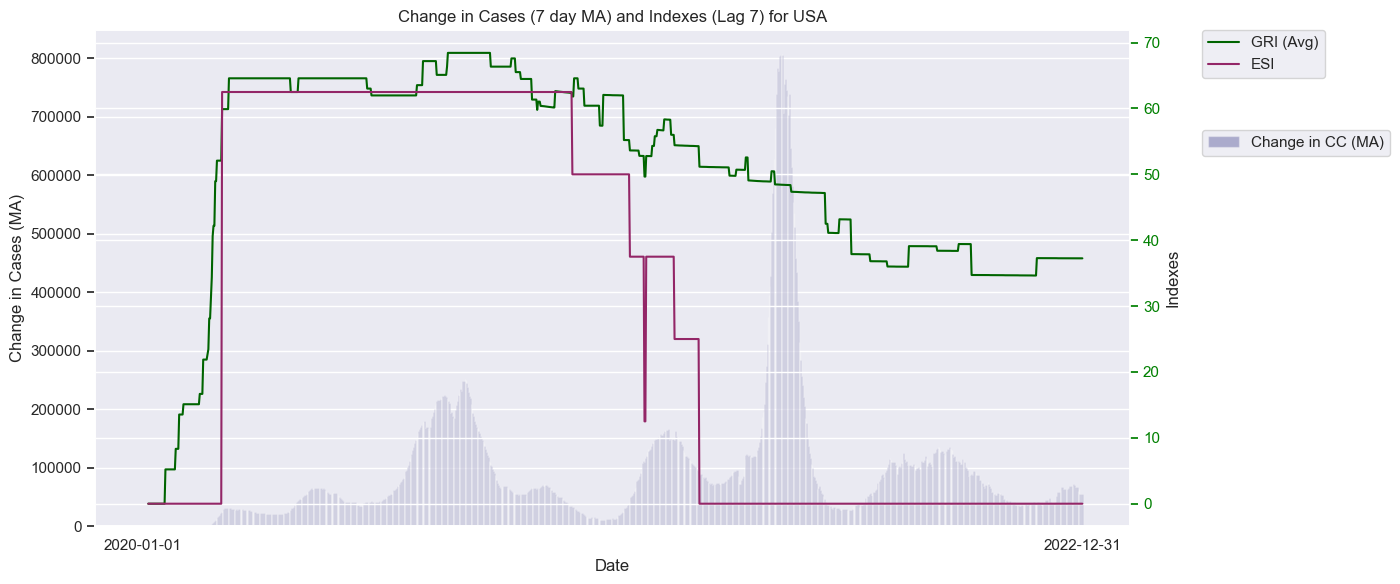

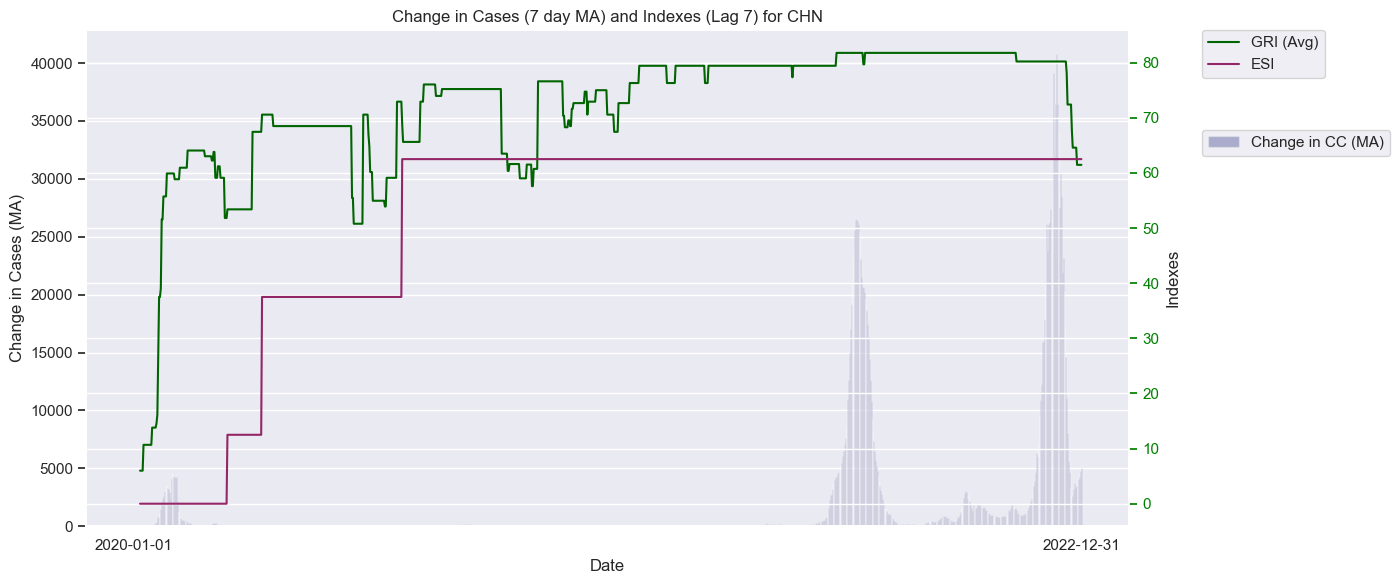

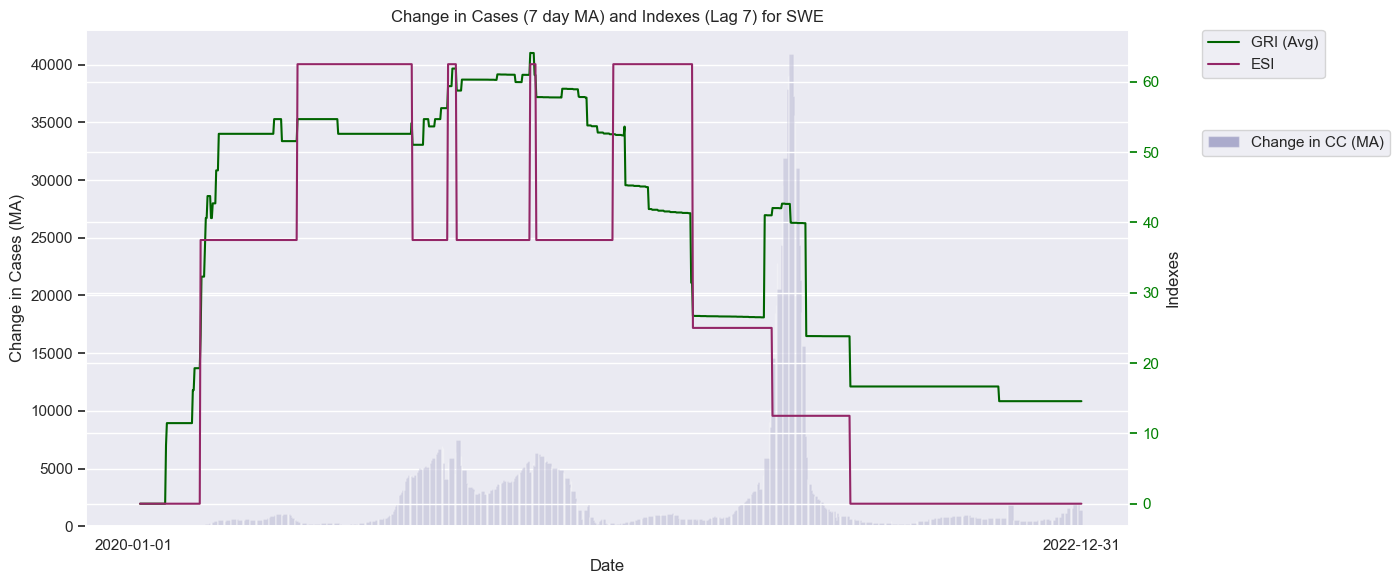

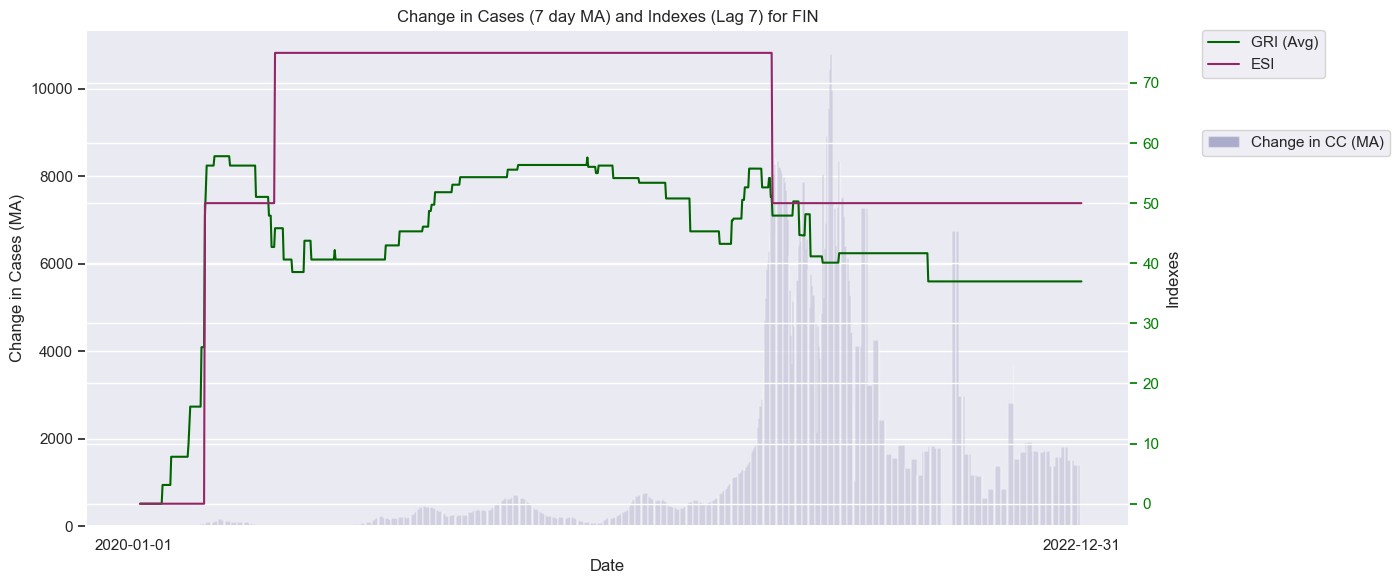

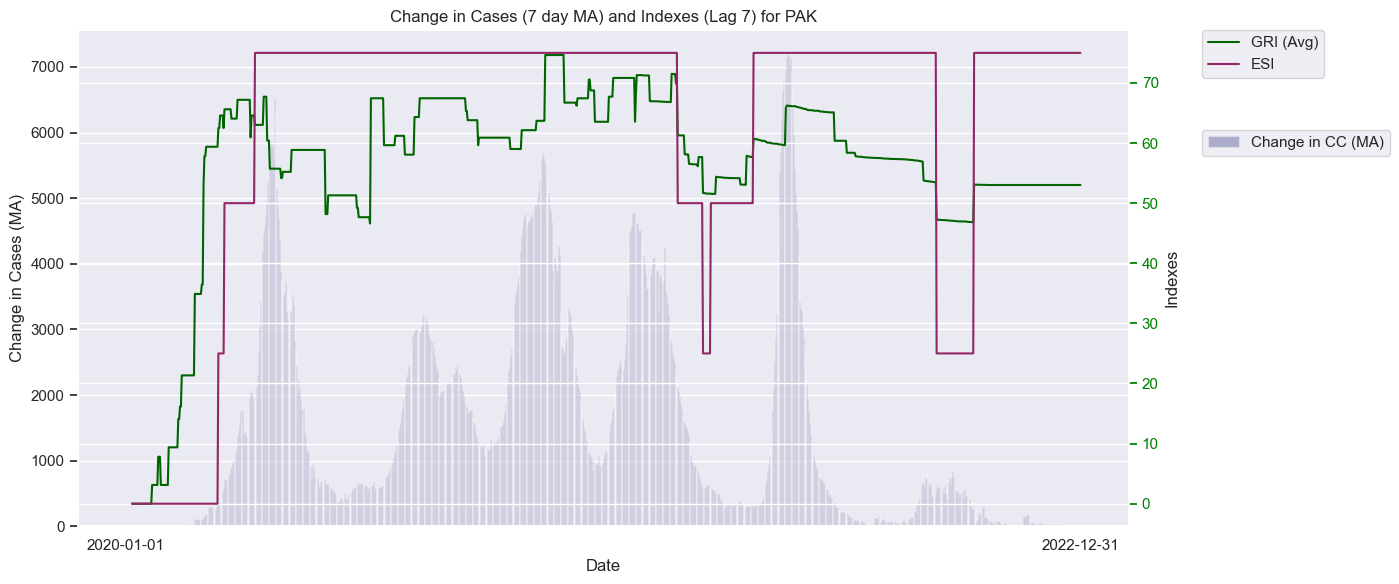

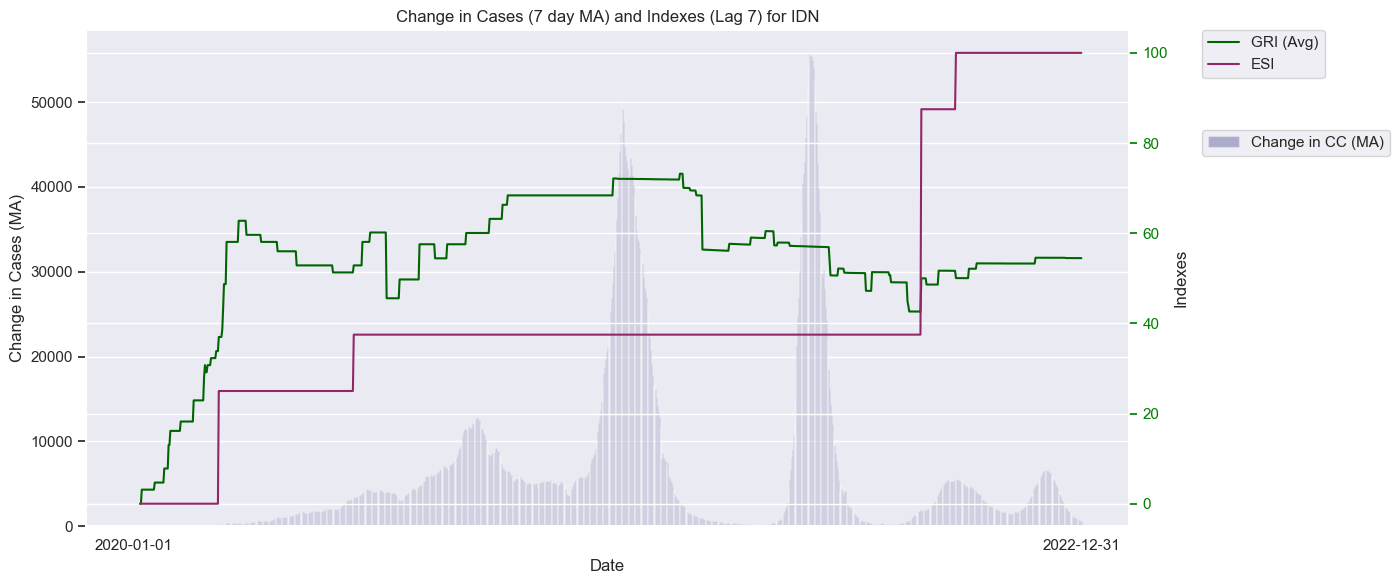

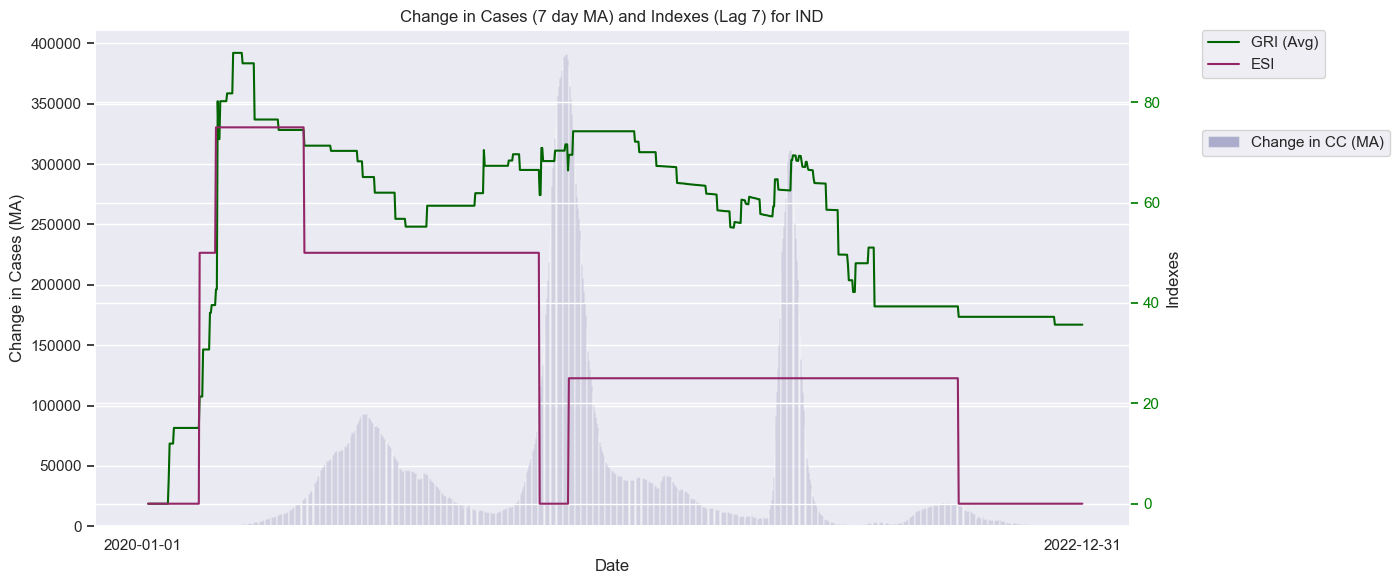

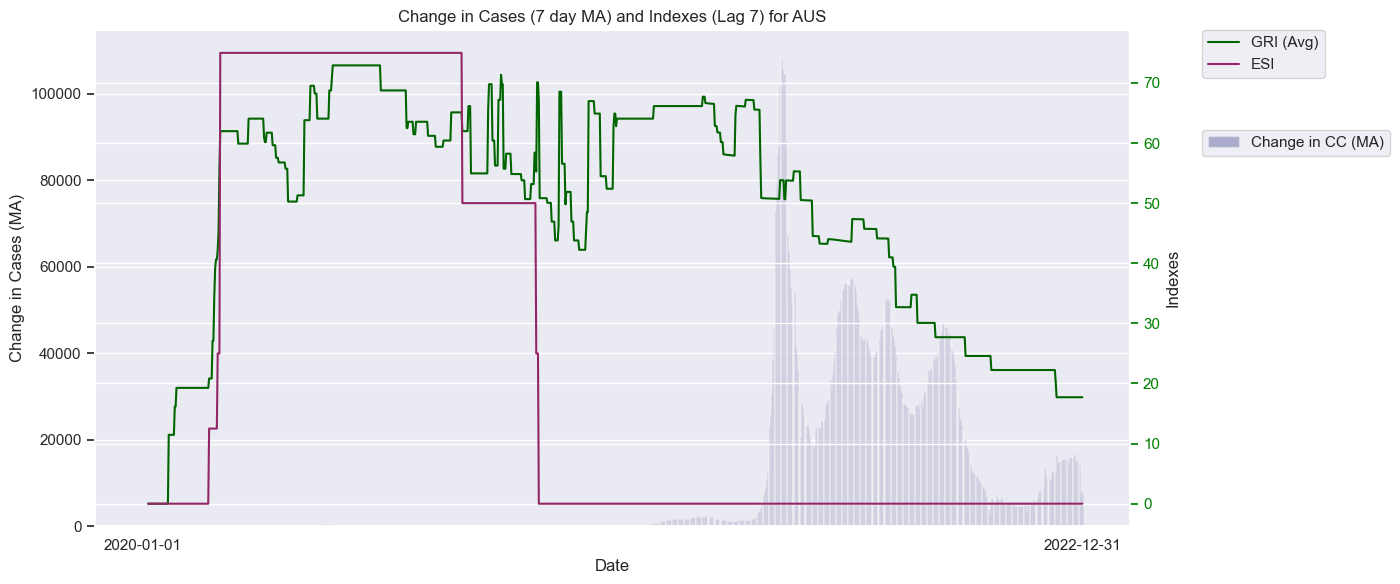

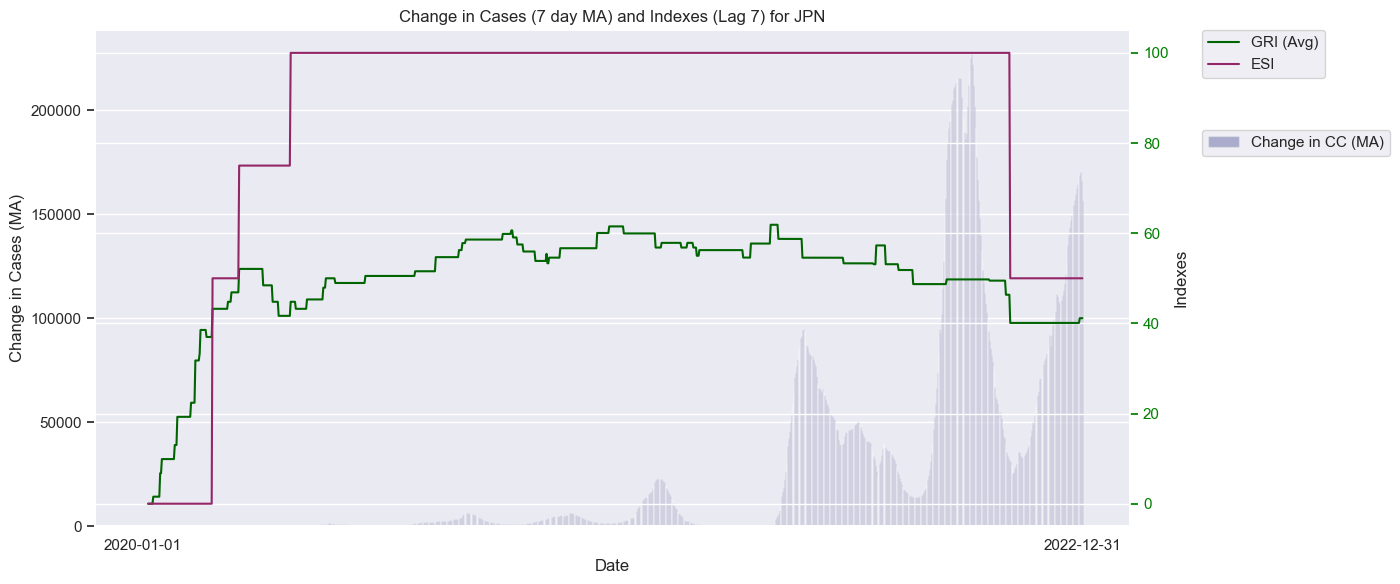

In [18]:
start_date = justViewingLagged['Date'].min()
end_date = justViewingLagged['Date'].max()

for idx, country in enumerate(countries):
    
    plt.figure(figsize=(14, 6))

    data = justViewingLagged[justViewing['CountryCode'] == country].sort_values(by='Date')

    ax1 = sns.barplot(x='Date', y='ChangeCC_7dayMA', data=data, color='#040080',zorder=1,alpha=0.3,label='Change in CC (MA)') 
    ax1.set_ylabel('Change in Cases (MA)')
    ax1.set_title(f'Change in Cases (7 day MA) and Indexes (Lag 7) for {country}')
    ax1.tick_params(axis='y', colors='#292929')

    ax2 = ax1.twinx()
    sns.lineplot(x='Date', y='GovernmentResponseIndex_Average_Lag7', data=data, ax=ax2, color='darkgreen', label='GRI (Avg)')
    sns.lineplot(x='Date', y='EconomicSupportIndex_Lag7', data=data, ax=ax2, color='#932667', label='ESI')
    ax2.set_ylabel('Indexes')
    ax2.tick_params(axis='y', colors='green')
   
    ax1.legend(loc='upper left', bbox_to_anchor=(1.07, 0.8), borderaxespad=0.)
    ax2.legend(loc='upper left', bbox_to_anchor=(1.07, 1), borderaxespad=0.)
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    plt.xticks([start_date, end_date])
    plt.tight_layout()
    plt.show()

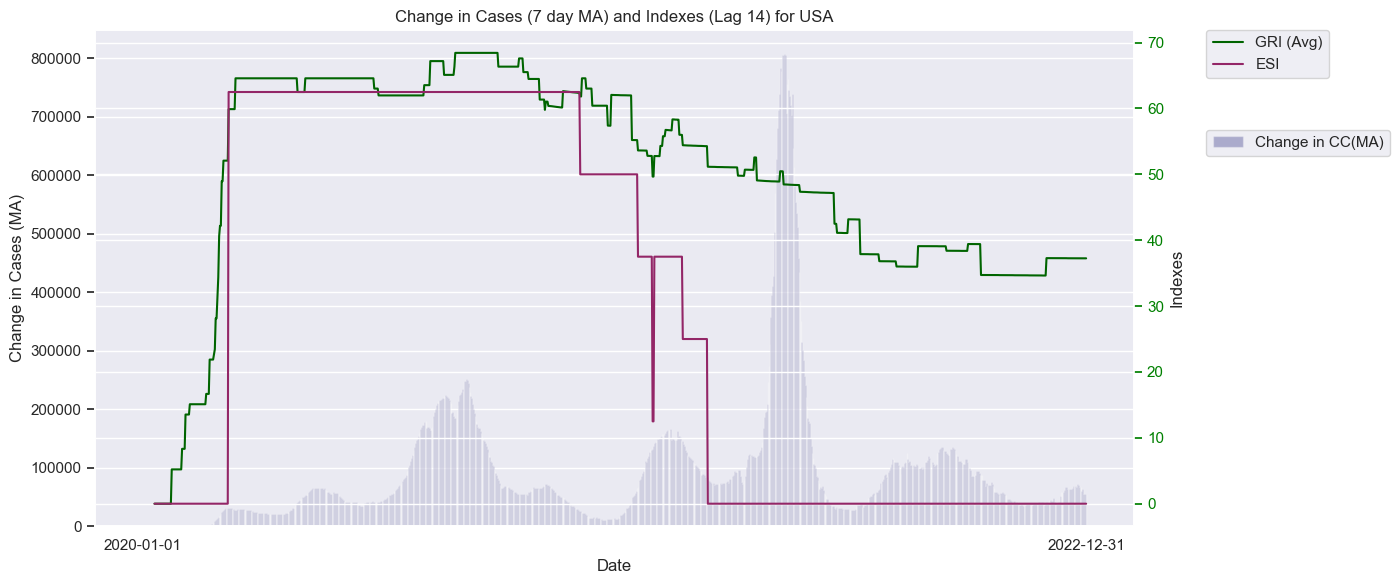

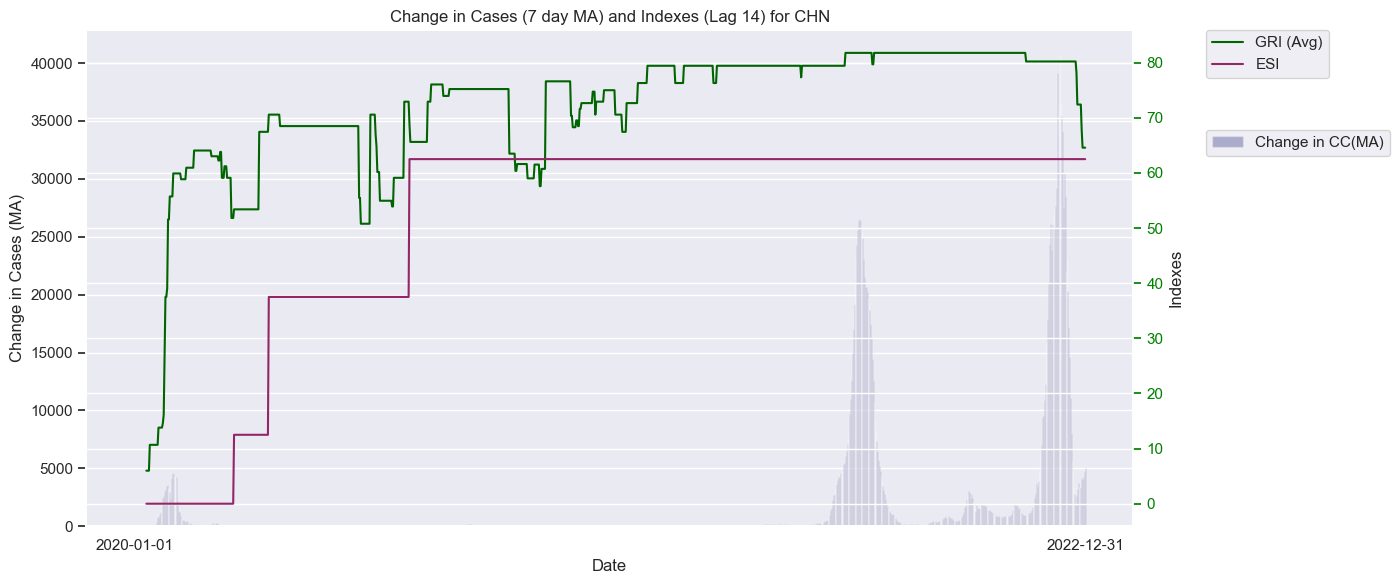

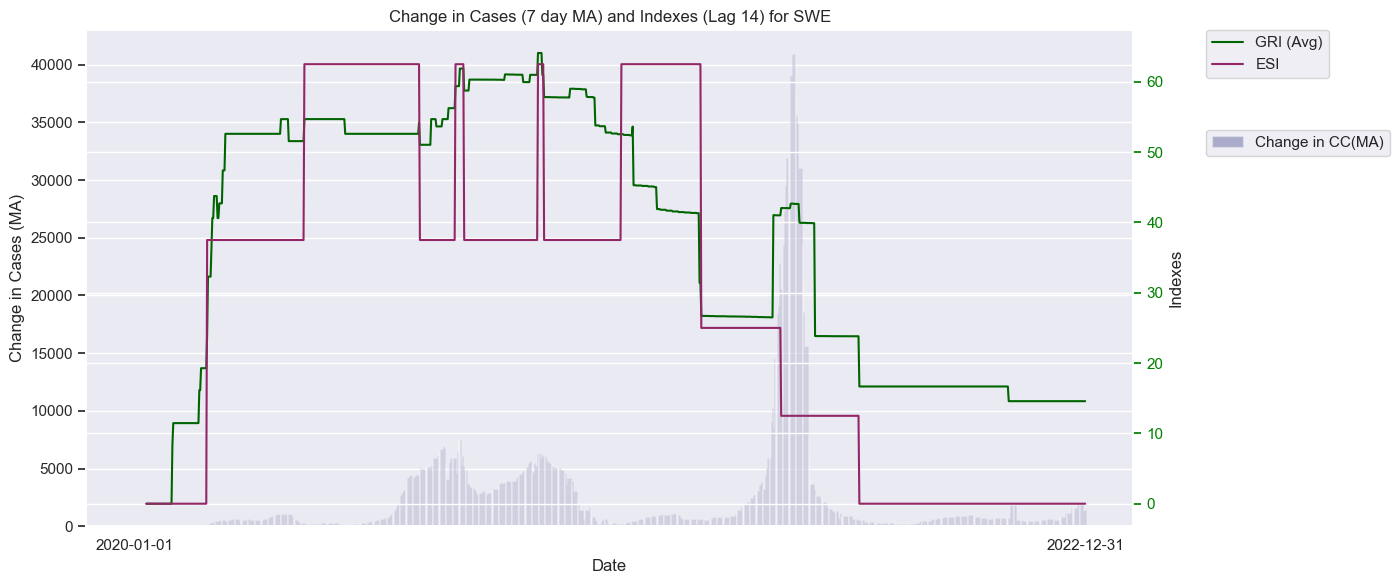

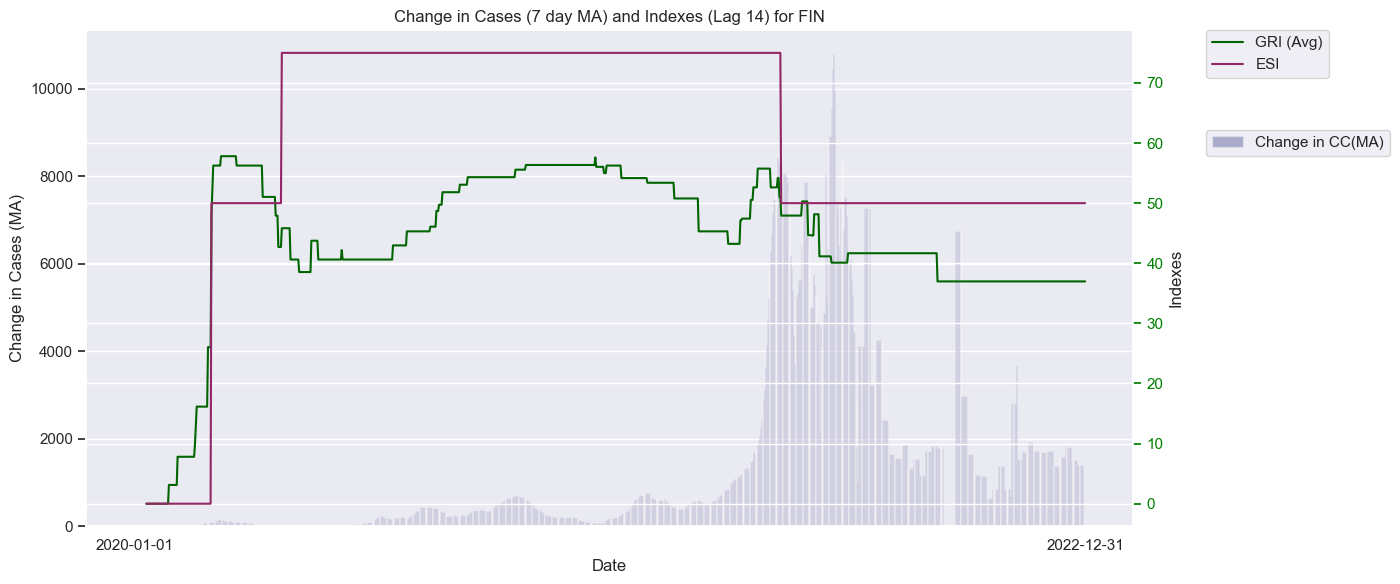

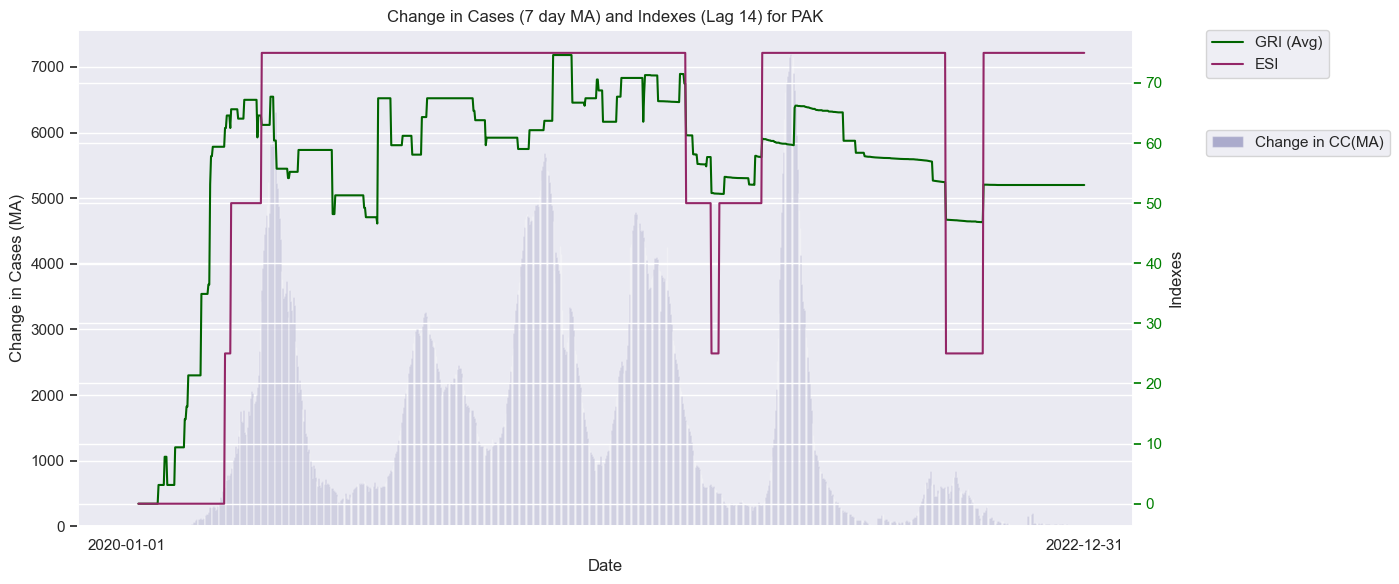

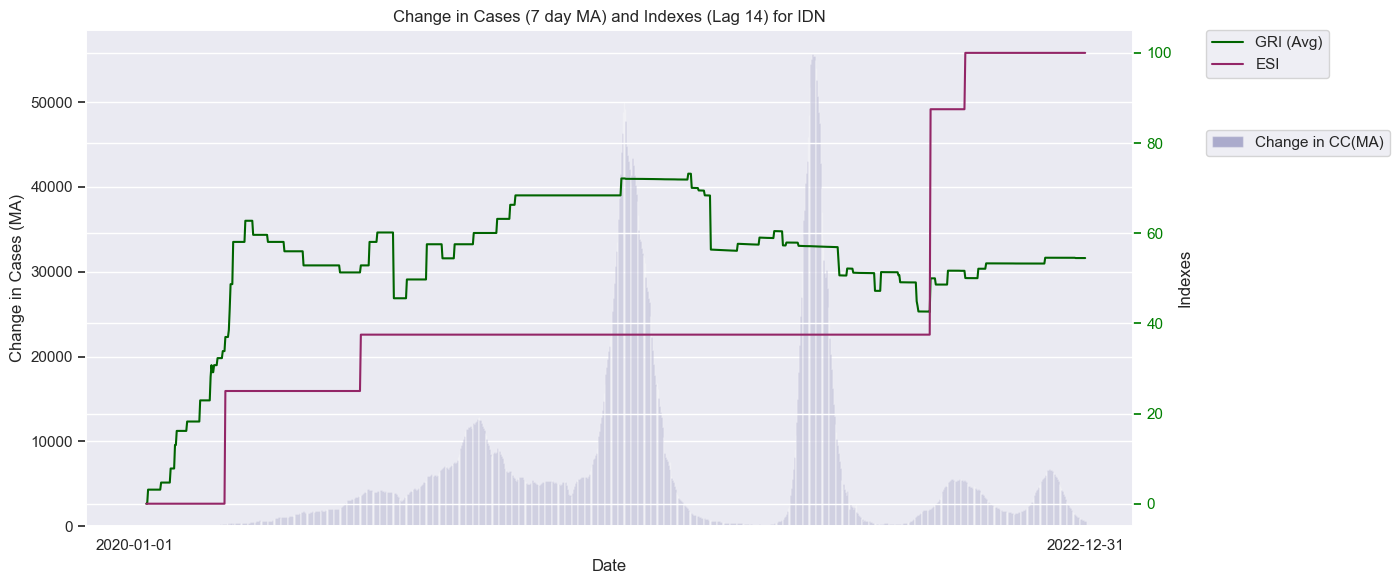

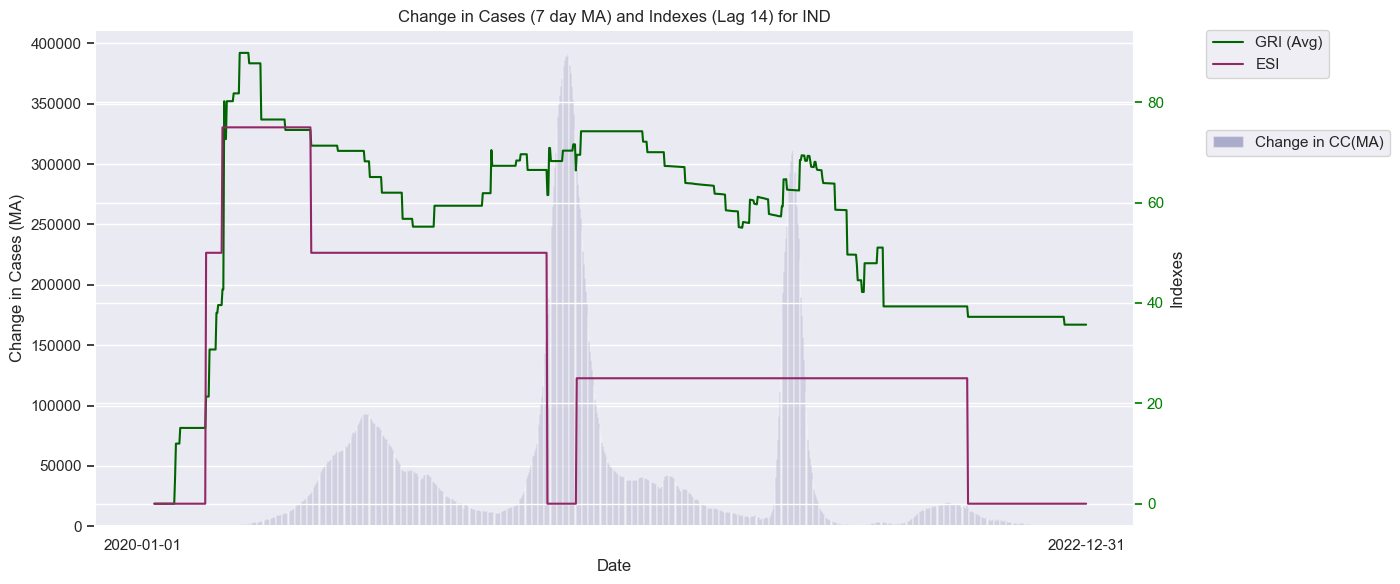

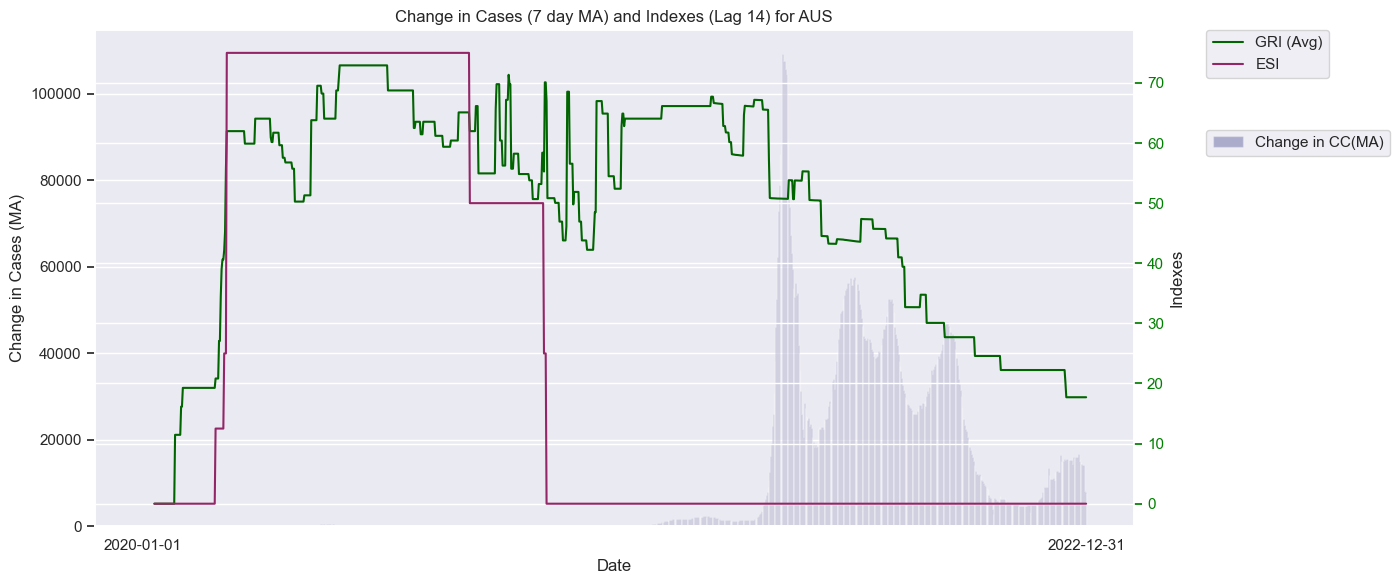

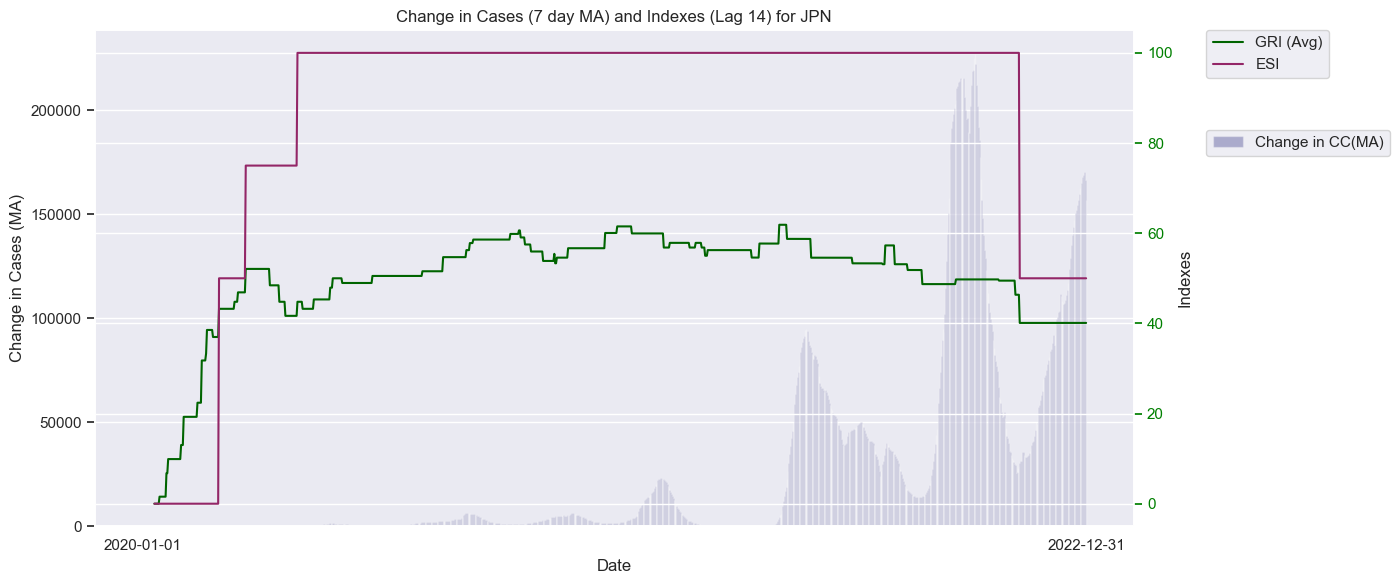

In [19]:
start_date = justViewingLagged['Date'].min()
end_date = justViewingLagged['Date'].max()

for idx, country in enumerate(countries):
    
    plt.figure(figsize=(14, 6))

    data = justViewingLagged[justViewing['CountryCode'] == country].sort_values(by='Date')

    ax1 = sns.barplot(x='Date', y='ChangeCC_7dayMA', data=data, color='#040080',zorder=1,alpha=0.3,label='Change in CC(MA)') 
    ax1.set_ylabel('Change in Cases (MA)')
    ax1.set_title(f'Change in Cases (7 day MA) and Indexes (Lag 14) for {country}')
    ax1.tick_params(axis='y', colors='#292929')

    ax2 = ax1.twinx()
    sns.lineplot(x='Date', y='GovernmentResponseIndex_Average_Lag14', data=data, ax=ax2, color='darkgreen', label='GRI (Avg)')
    sns.lineplot(x='Date', y='EconomicSupportIndex_Lag14', data=data, ax=ax2, color='#932667', label='ESI')
    ax2.set_ylabel('Indexes')
    ax2.tick_params(axis='y', colors='green')
   
    ax1.legend(loc='upper left', bbox_to_anchor=(1.07, 0.8), borderaxespad=0.)
    ax2.legend(loc='upper left', bbox_to_anchor=(1.07, 1), borderaxespad=0.)
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    plt.xticks([start_date, end_date])
    plt.tight_layout()
    plt.show()

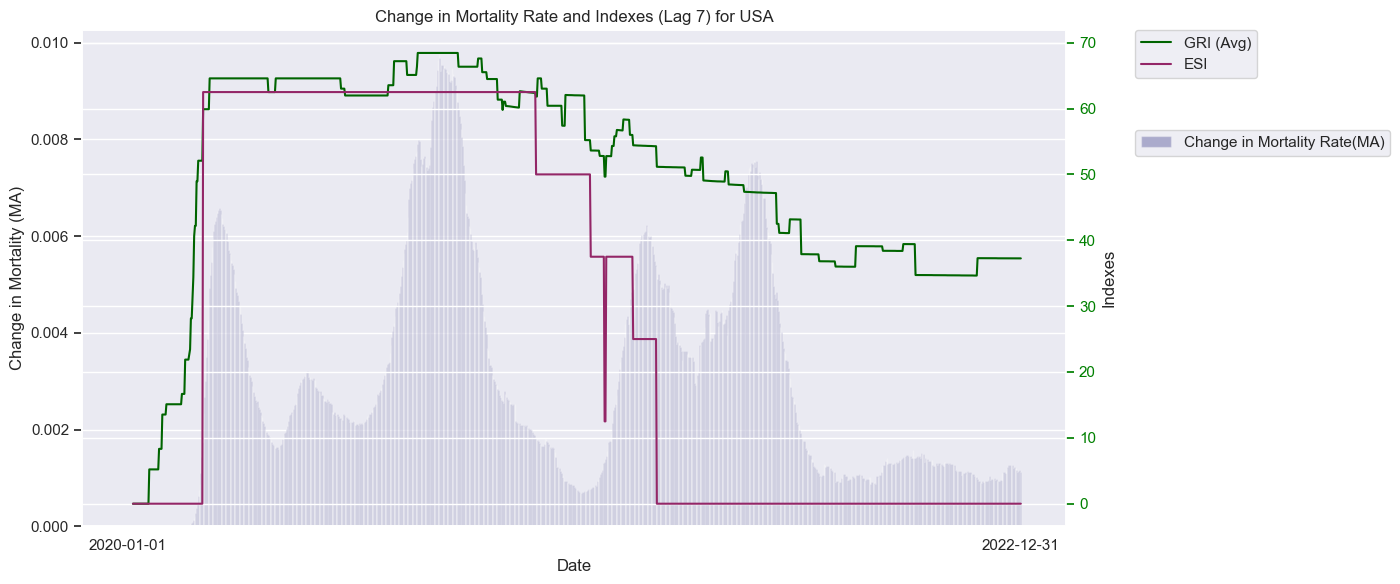

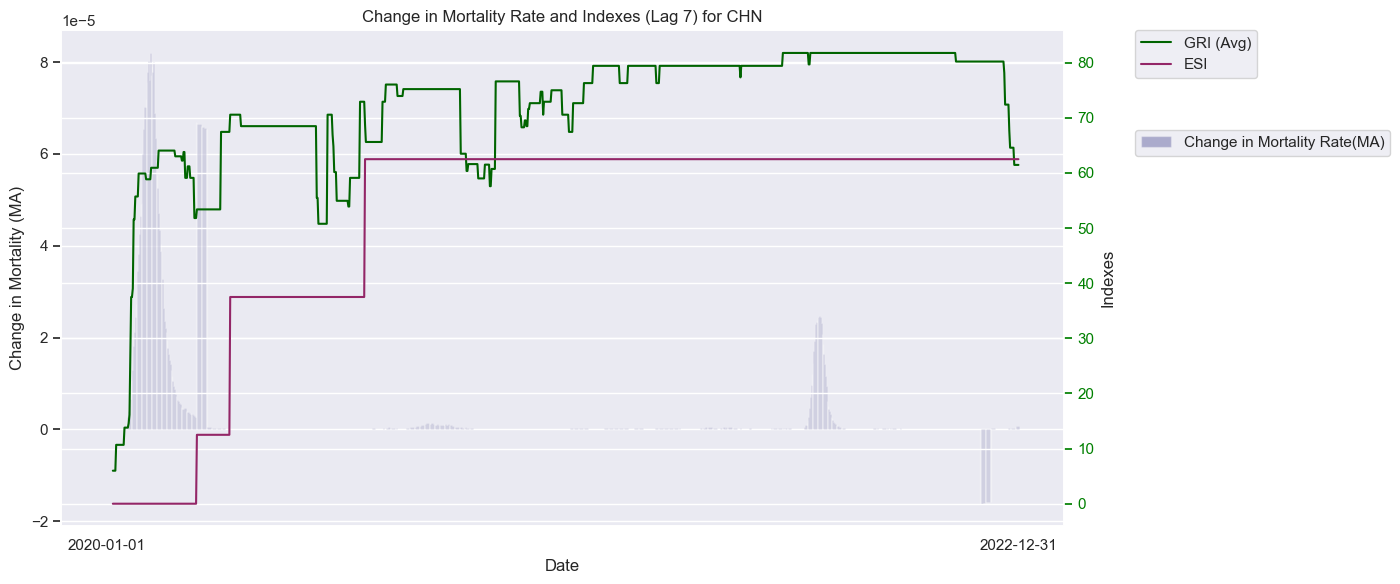

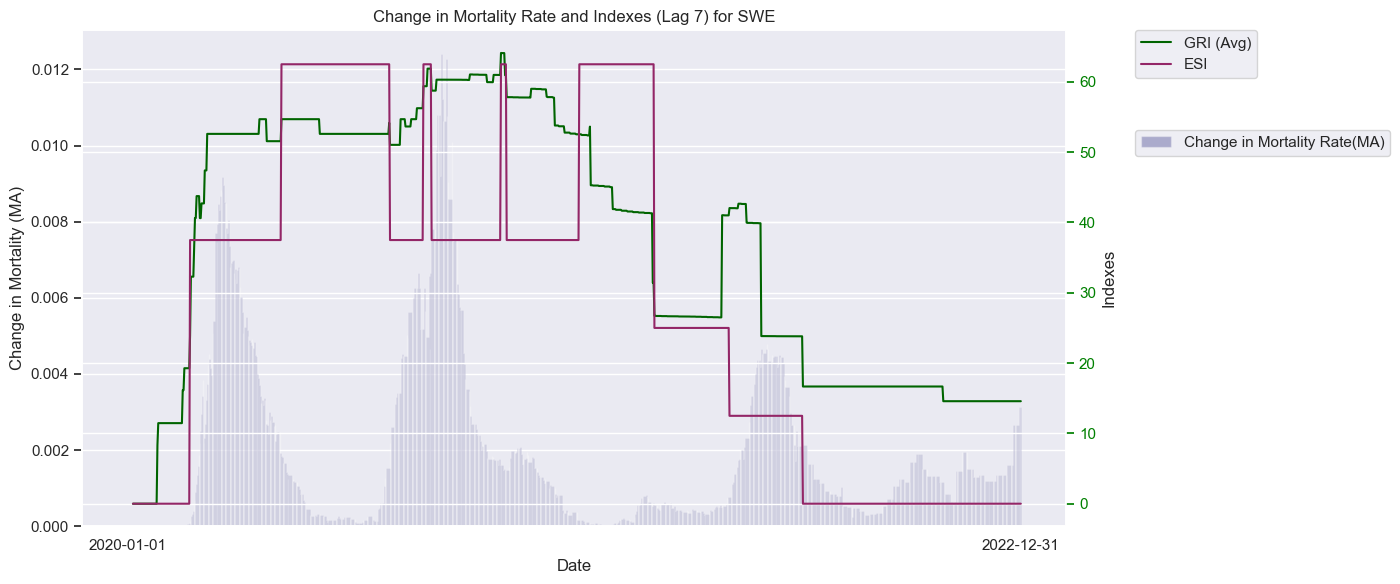

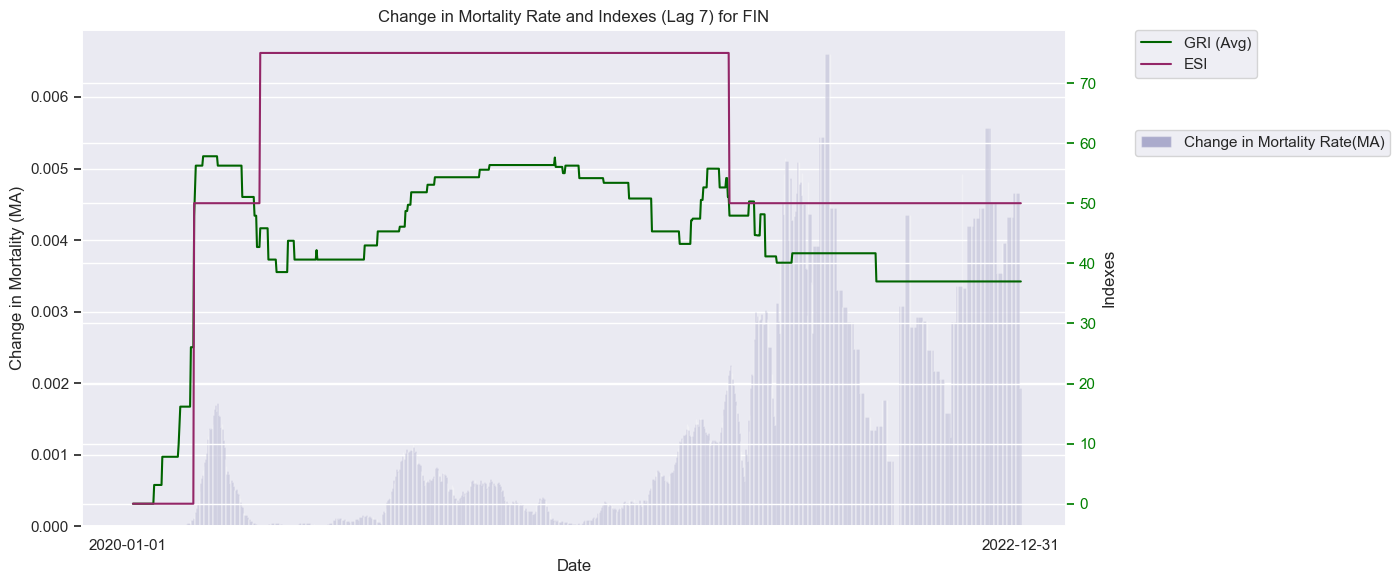

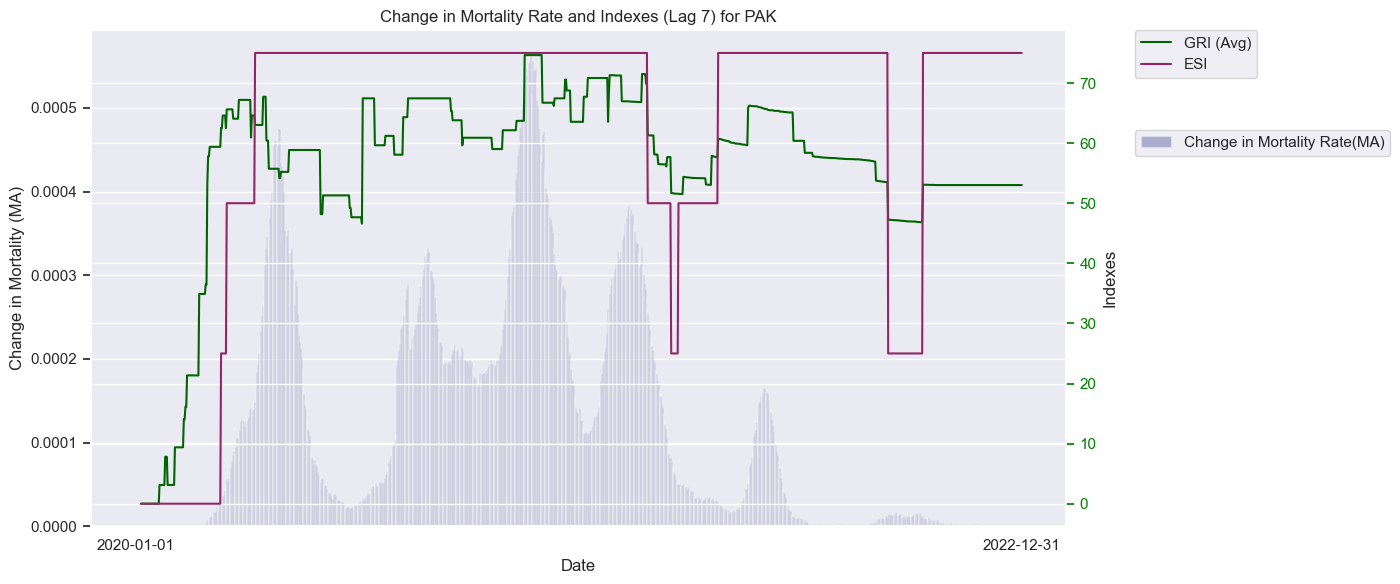

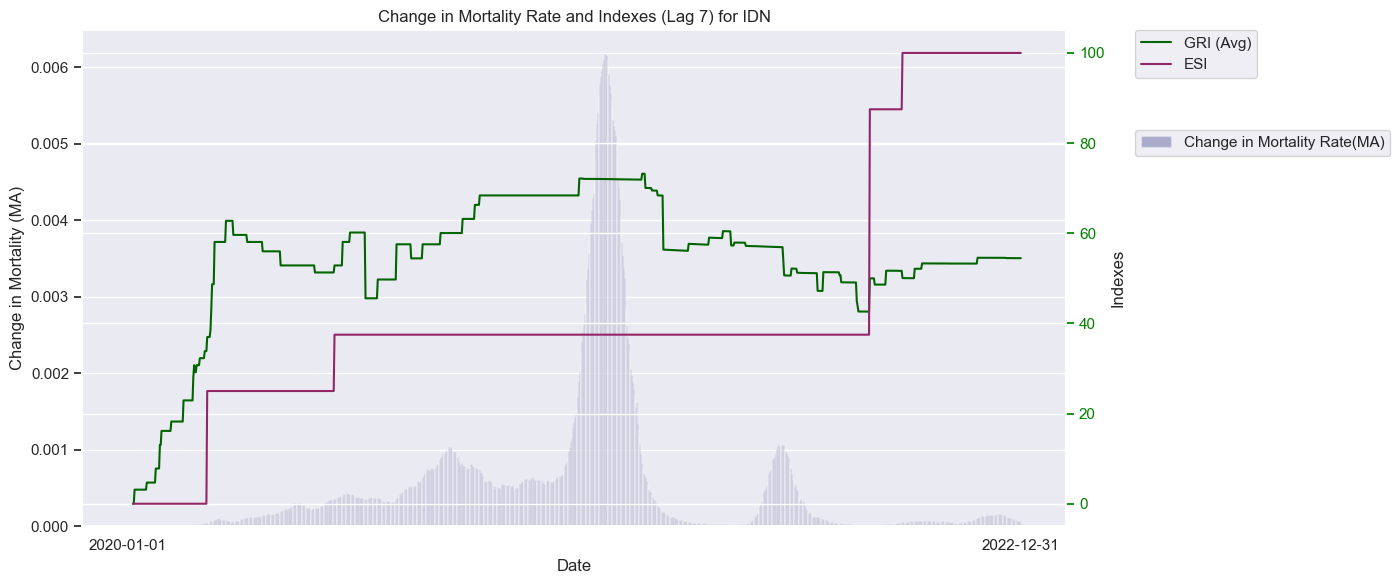

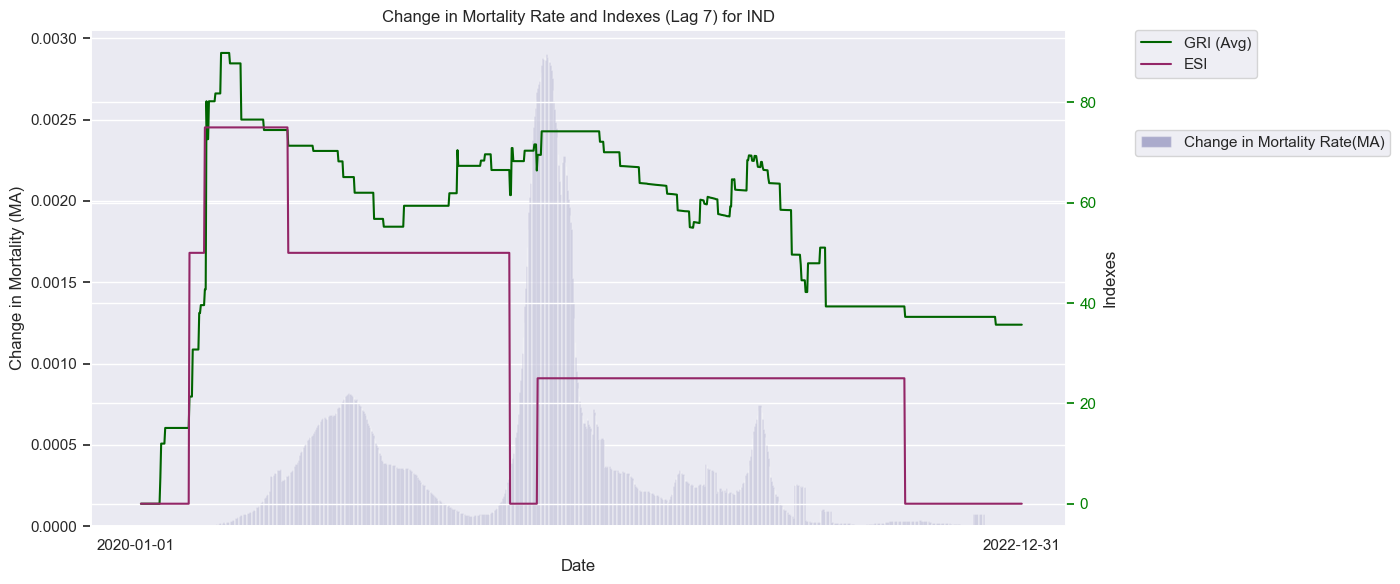

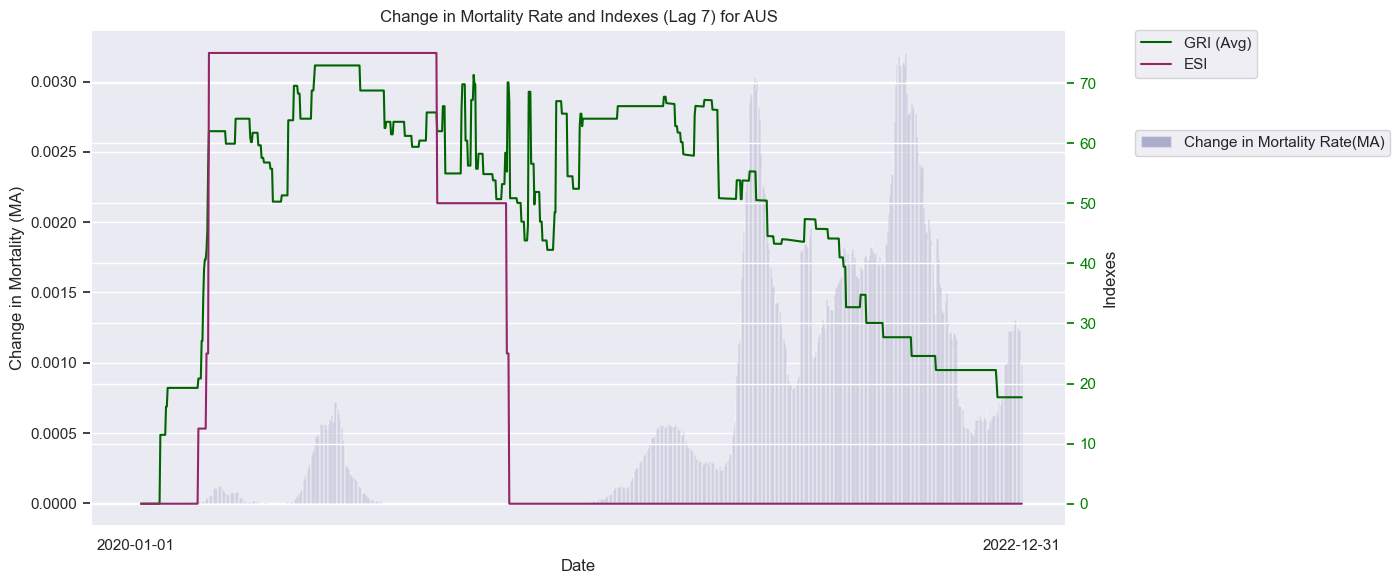

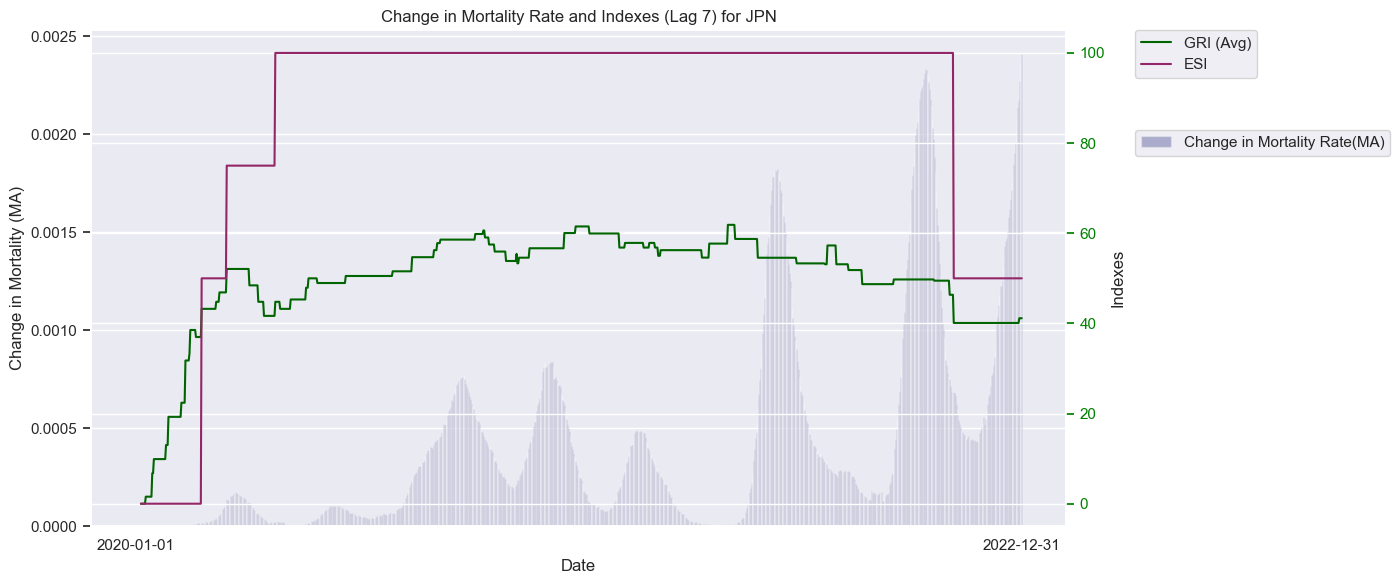

In [20]:
start_date = justViewingLagged['Date'].min()
end_date = justViewingLagged['Date'].max()

for idx, country in enumerate(countries):
    
    plt.figure(figsize=(14, 6))

    data = justViewingLagged[justViewing['CountryCode'] == country].sort_values(by='Date')

    ax1 = sns.barplot(x='Date', y='ChangeMR_14dayMA', data=data, color='#040080',zorder=1,alpha=0.3,label='Change in Mortality Rate(MA)') 
    ax1.set_ylabel('Change in Mortality (MA)')
    ax1.set_title(f'Change in Mortality Rate and Indexes (Lag 7) for {country}')
    ax1.tick_params(axis='y', colors='#292929')

    ax2 = ax1.twinx()
    sns.lineplot(x='Date', y='GovernmentResponseIndex_Average_Lag7', data=data, ax=ax2, color='darkgreen', label='GRI (Avg)')
    sns.lineplot(x='Date', y='EconomicSupportIndex_Lag7', data=data, ax=ax2, color='#932667', label='ESI')
    ax2.set_ylabel('Indexes')
    ax2.tick_params(axis='y', colors='green')
   
    ax1.legend(loc='upper left', bbox_to_anchor=(1.07, 0.8), borderaxespad=0.)
    ax2.legend(loc='upper left', bbox_to_anchor=(1.07, 1), borderaxespad=0.)
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    plt.xticks([start_date, end_date])
    plt.tight_layout()
    plt.show()

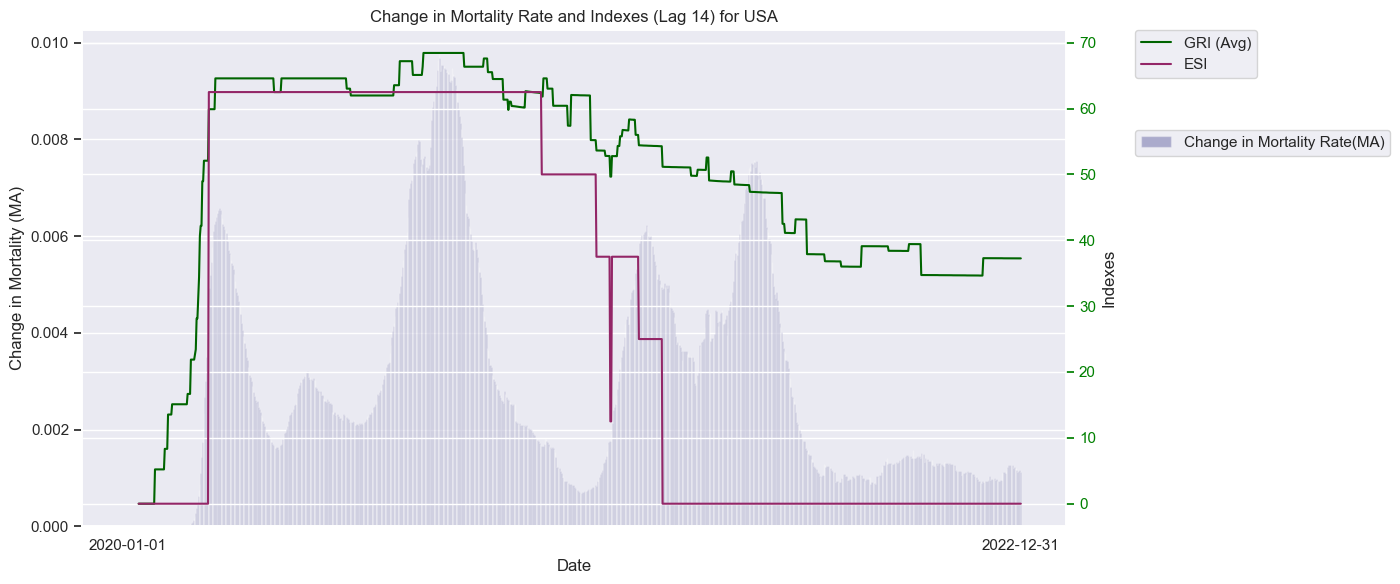

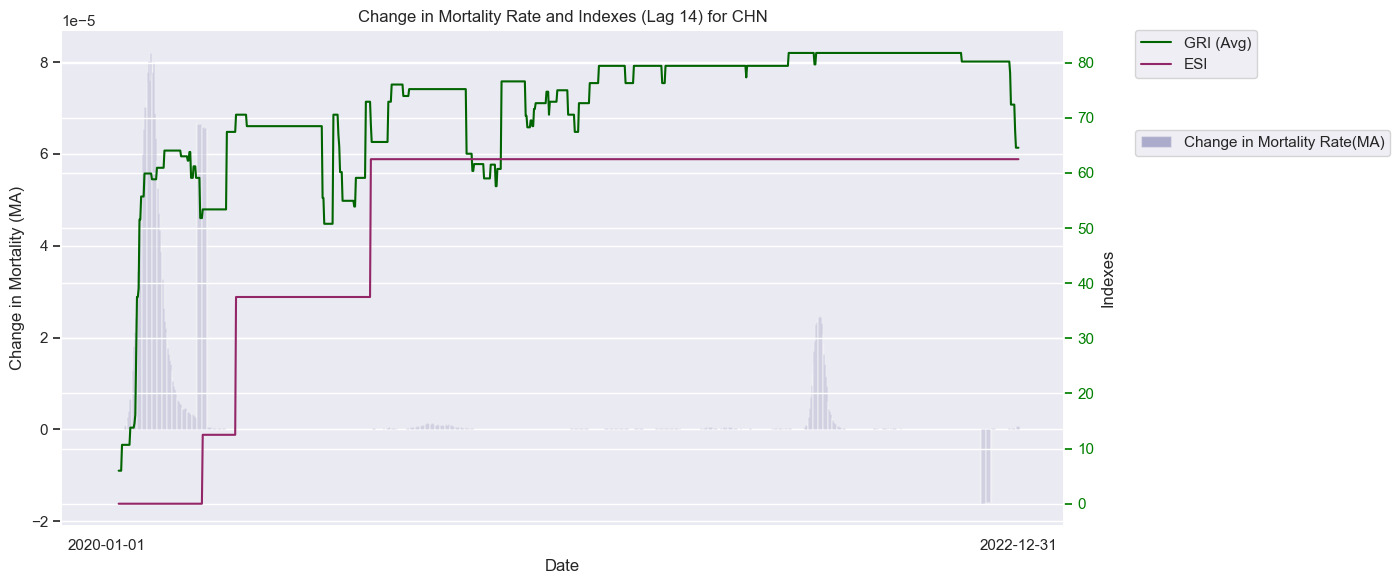

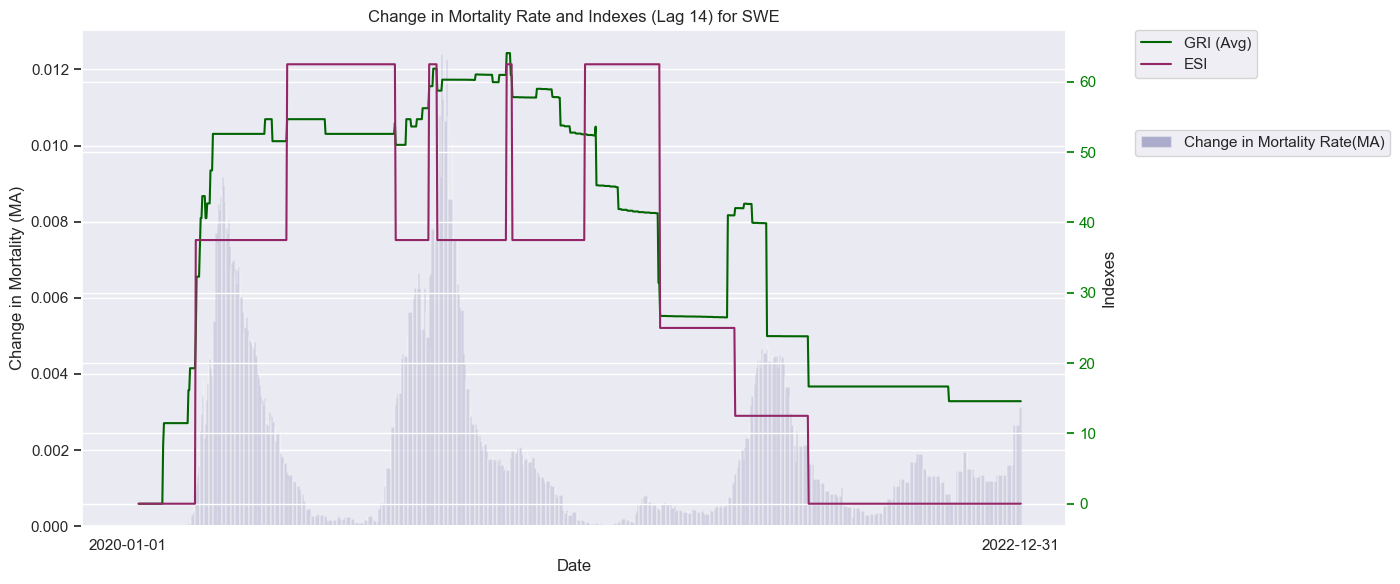

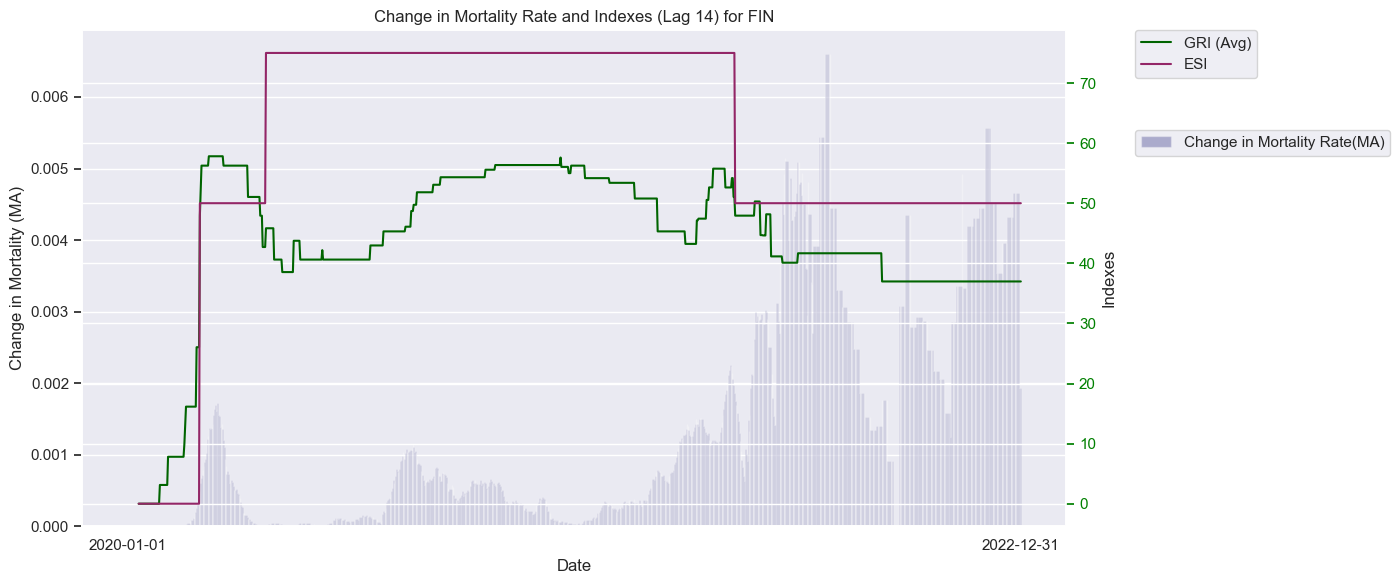

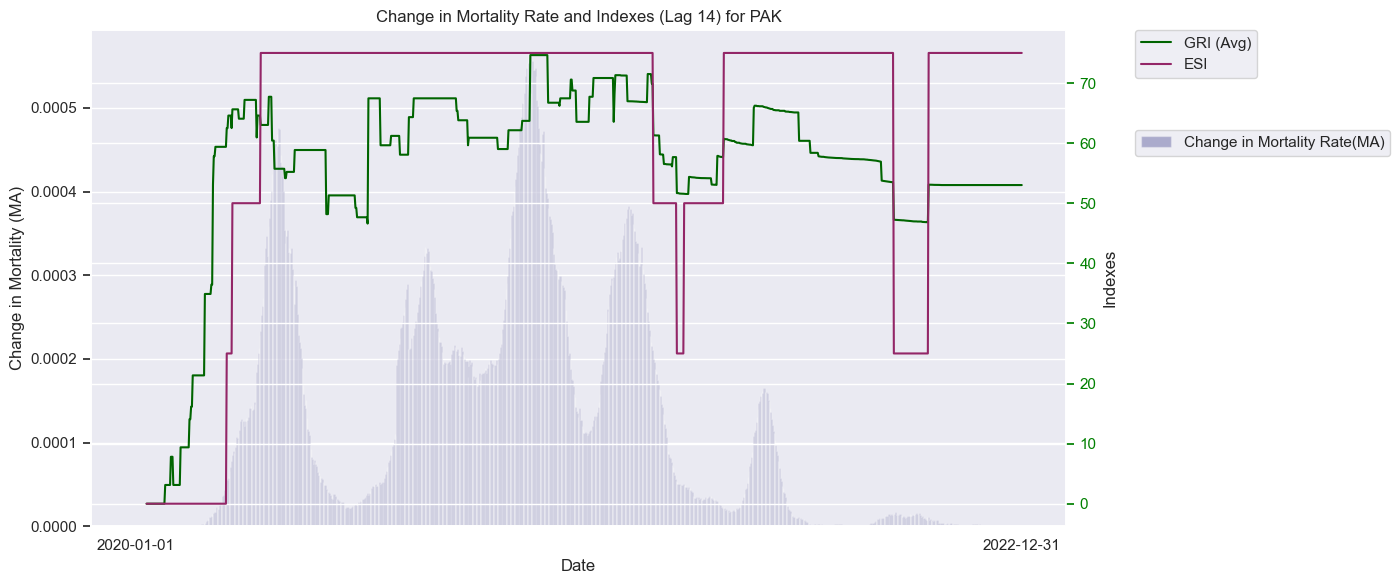

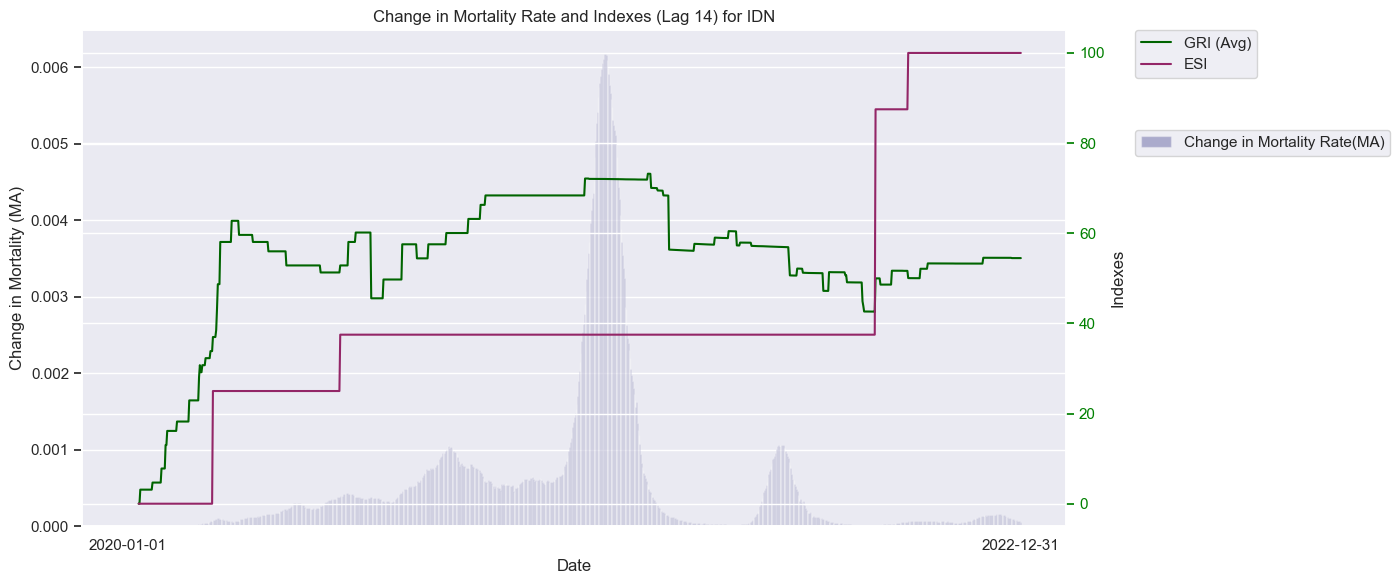

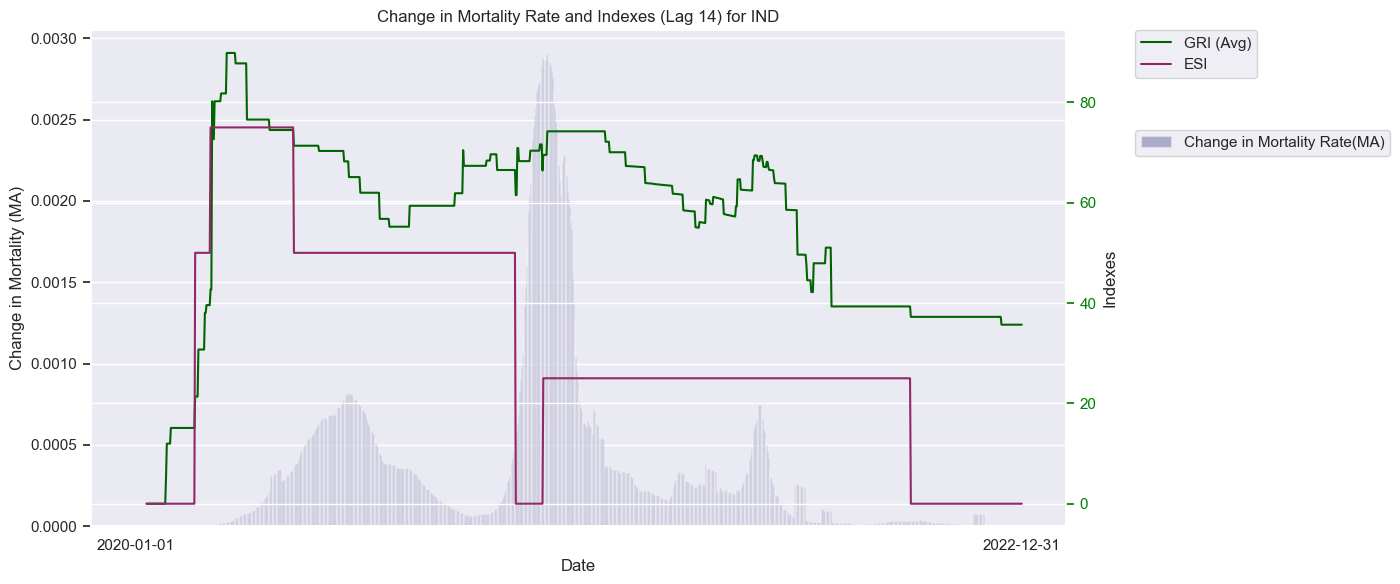

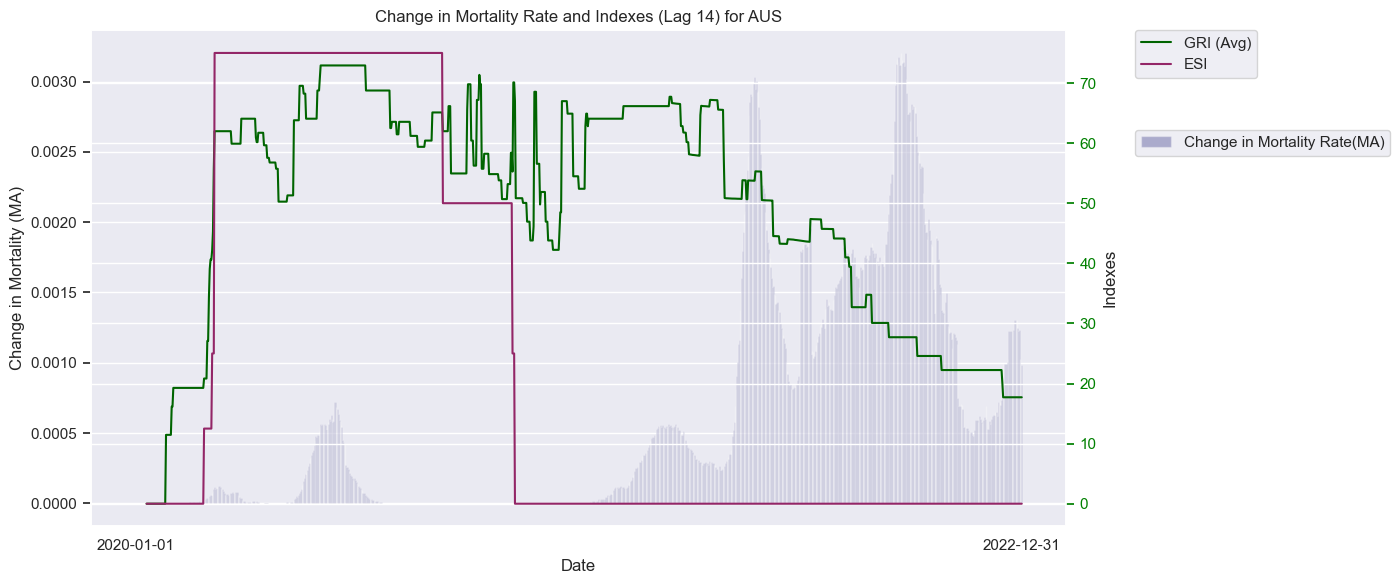

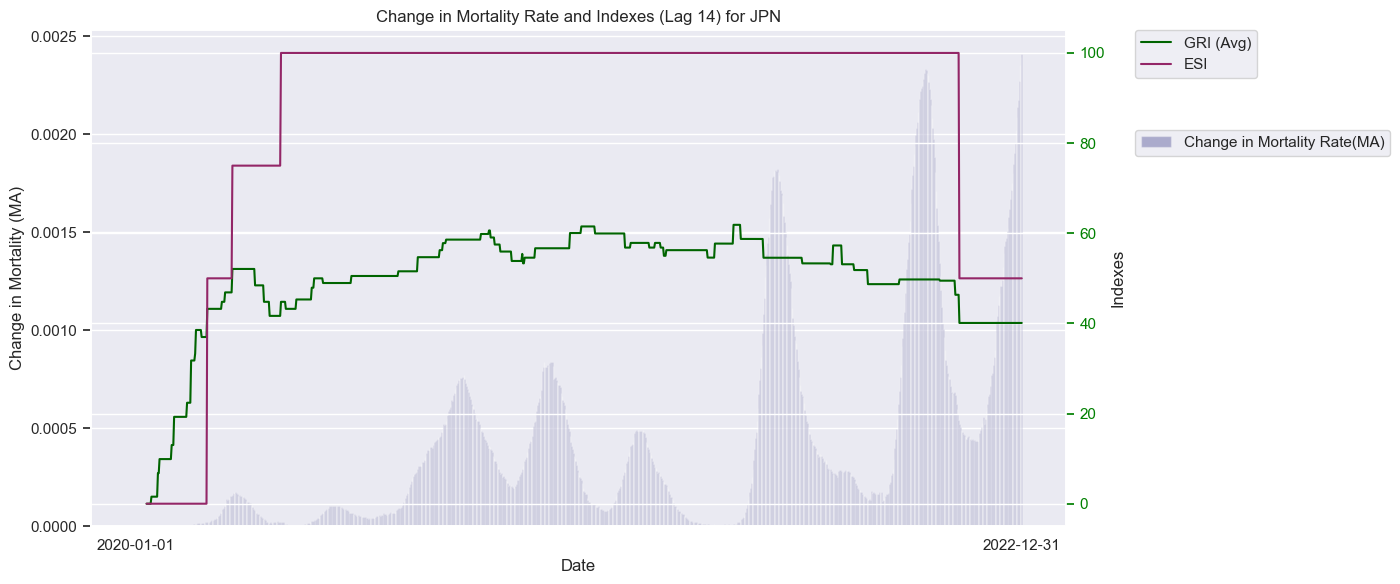

In [21]:
start_date = justViewingLagged['Date'].min()
end_date = justViewingLagged['Date'].max()

for idx, country in enumerate(countries):
    
    plt.figure(figsize=(14, 6))

    data = justViewingLagged[justViewing['CountryCode'] == country].sort_values(by='Date')

    ax1 = sns.barplot(x='Date', y='ChangeMR_14dayMA', data=data, color='#040080',zorder=1,alpha=0.3,label='Change in Mortality Rate(MA)') 
    ax1.set_ylabel('Change in Mortality (MA)')
    ax1.set_title(f'Change in Mortality Rate and Indexes (Lag 14) for {country}')
    ax1.tick_params(axis='y', colors='#292929')

    ax2 = ax1.twinx()
    sns.lineplot(x='Date', y='GovernmentResponseIndex_Average_Lag14', data=data, ax=ax2, color='darkgreen', label='GRI (Avg)')
    sns.lineplot(x='Date', y='EconomicSupportIndex_Lag14', data=data, ax=ax2, color='#932667', label='ESI')
    ax2.set_ylabel('Indexes')
    ax2.tick_params(axis='y', colors='green')
   
    ax1.legend(loc='upper left', bbox_to_anchor=(1.07, 0.8), borderaxespad=0.)
    ax2.legend(loc='upper left', bbox_to_anchor=(1.07, 1), borderaxespad=0.)
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    plt.xticks([start_date, end_date])
    plt.tight_layout()
    plt.show()

#### Plot GRI with its lagged values for any one country

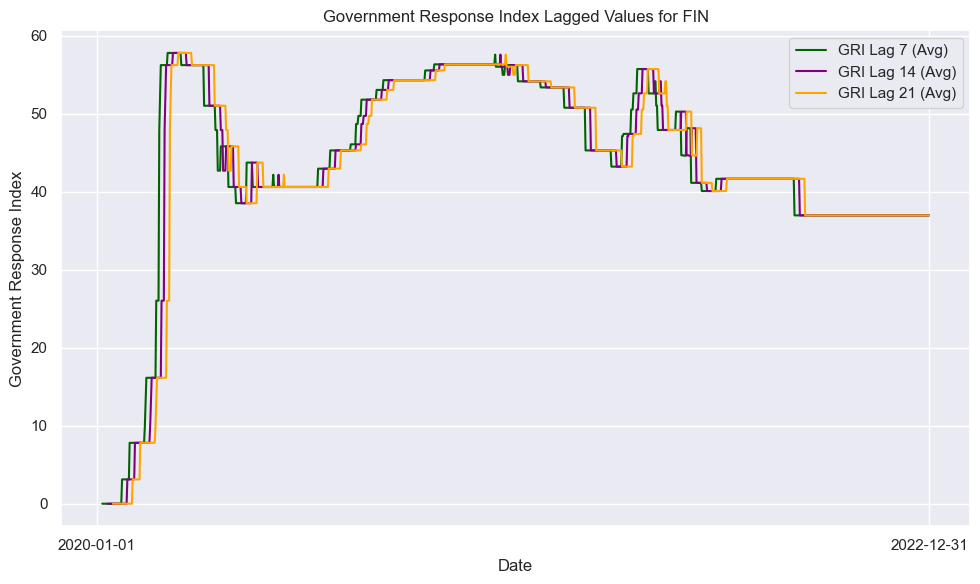

In [27]:
country = 'FIN'

plt.figure(figsize=(10, 6))

data = justViewingLagged[justViewingLagged['CountryCode'] == country].sort_values(by='Date')

sns.lineplot(x='Date', y='GovernmentResponseIndex_Average', data=data, color='darkgreen', label='GRI Lag 7 (Avg)')
sns.lineplot(x='Date', y='GovernmentResponseIndex_Average_Lag7', data=data, color='darkgreen', label='GRI Lag 7 (Avg)')
sns.lineplot(x='Date', y='GovernmentResponseIndex_Average_Lag14', data=data, color='purple', label='GRI Lag 14 (Avg)')
sns.lineplot(x='Date', y='GovernmentResponseIndex_Average_Lag21', data=data, color='orange', label='GRI Lag 21 (Avg)')

plt.title(f'Government Response Index Lagged Values for {country}')
plt.ylabel('Government Response Index')
plt.xlabel('Date')
plt.legend()
plt.xticks([start_date, end_date])
plt.tight_layout()
plt.show()

#### Dropping China

In [262]:
df = df[df['CountryCode'] != 'CHN']

#### Create new features for every country

* Change in MR MA (14), CC MA (7)
* Include all lagged features for all intervals


In [209]:
df = df.sort_values(by=['CountryCode', 'Date'])
df['changeInCC'] = df.groupby(['CountryCode'])['ConfirmedCases'].transform(lambda x: x.diff())
df['changeInMR'] = df.groupby(['CountryCode'])['Mortality Rate'].transform(lambda x: x.diff())
df = df.replace(np.nan, 0)

df['ChangeCC_7dayMA'] = df.groupby(['CountryCode'])['changeInCC'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
df['ChangeMR_14dayMA'] = df.groupby(['CountryCode'])['changeInMR'].rolling(window=14, min_periods=1).mean().reset_index(0, drop=True)

df = df.sort_values(by=['CountryCode', 'Date'])

label_encoder = LabelEncoder()

df['MajorityVaccinated'] = label_encoder.fit_transform(df['MajorityVaccinated'])

def create_lagged_features(df, columns, days):
    df_lagged = df.copy()
    for day in days:
        for col in columns:
            df_lagged[col + f'_Lag{day}'] = df.groupby('CountryCode')[col].shift(day)
    return df_lagged


columns = ['StringencyIndex_Average', 'GovernmentResponseIndex_Average', 
                 'ContainmentHealthIndex_Average', 'EconomicSupportIndex', 'H5', 'V1', 'V3', 'MajorityVaccinated']


days = [7,14,21]

dfWithLagged = create_lagged_features(df, columns, days)

dfWithLagged.head(1)

CountryCode        Date  ConfirmedCases  ConfirmedDeaths  \
0         AFG  2020-01-01             0.0              0.0   

   MajorityVaccinated  StringencyIndex_Average  \
0                   0                      0.0   

   GovernmentResponseIndex_Average  ContainmentHealthIndex_Average  \
0                              0.0                             0.0   

   EconomicSupportIndex  Population  GDP_Per_Capita  Life_Expectancy  \
0                   0.0  41128772.0        1803.987            64.83   

   Hospital_Beds_Per_Thousand  Mortality Rate   H5  V1  V3  \
0                         0.5             0.0  0.0   0   0   

   Mortality_Rate_7day_MA  ConfirmedCases_7day_MA  changeInCC  changeInMR  \
0                     0.0                     0.0         0.0         0.0   

   ChangeCC_7dayMA  ChangeMR_14dayMA  StringencyIndex_Average_Lag7  \
0              0.0               0.0                           NaN   

   GovernmentResponseIndex_Average_Lag7  ContainmentHealthIndex_Average_Lag7  \
0                                   NaN                                  NaN   

   EconomicSupportIndex_Lag7  H5_Lag7  V1_Lag7  V3_Lag7  \
0                        NaN      NaN      NaN      NaN   

   MajorityVaccinated_Lag7  StringencyIndex_Average_Lag14  \
0                      NaN                            NaN   

   GovernmentResponseIndex_Average_Lag14  \
0                                    NaN   

   ContainmentHealthIndex_Average_Lag14  EconomicSupportIndex_Lag14  H5_Lag14  \
0                                   NaN                         NaN       NaN   

   V1_Lag14  V3_Lag14  MajorityVaccinated_Lag14  \
0       NaN       NaN                       NaN   

   StringencyIndex_Average_Lag21  GovernmentResponseIndex_Average_Lag21  \
0                            NaN                                    NaN   

   ContainmentHealthIndex_Average_Lag21  EconomicSupportIndex_Lag21  H5_Lag21  \
0                                   NaN                         NaN       NaN   

   V1_Lag21  V3_Lag21  MajorityVaccinated_Lag21  
0       NaN       NaN                       NaN

### Imputing values

In [210]:
dfWithLagged = dfWithLagged.replace(np.nan, 0)

### Distribution of dataset by Country

In [211]:
dfWithLagged.shape

(163304, 47)

163304 / 1096 = 149, which is the number of countries in our dataset. 

In [212]:
size = dfWithLagged.groupby('CountryCode').size()
size.nunique()

1

### Check Label Encode Majority Vaccinated

In [213]:
dfWithLagged['MajorityVaccinated'].nunique()
dfWithLagged['MajorityVaccinated_Lag7'].nunique()
dfWithLagged['MajorityVaccinated_Lag14'].nunique()
dfWithLagged['MajorityVaccinated_Lag21'].nunique()

2

In [214]:
dfWithLagged.shape

(163304, 47)

### Binary Encode Countries

In [215]:
encoder = BinaryEncoder(cols=['CountryCode'])
df_encoded = encoder.fit_transform(dfWithLagged['CountryCode'])

In [216]:
df_WithLag_encoded = pd.concat([dfWithLagged, df_encoded], axis=1)

In [217]:
df_WithLag_encoded.shape

(163304, 55)

In [218]:
df_WithLag_encoded.head()

CountryCode        Date  ConfirmedCases  ConfirmedDeaths  \
0           AFG  2020-01-01             0.0              0.0   
198         AFG  2020-01-02             0.0              0.0   
386         AFG  2020-01-03             0.0              0.0   
518         AFG  2020-01-04             0.0              0.0   
714         AFG  2020-01-05             0.0              0.0   

     MajorityVaccinated  StringencyIndex_Average  \
0                     0                      0.0   
198                   0                      0.0   
386                   0                      0.0   
518                   0                      0.0   
714                   0                      0.0   

     GovernmentResponseIndex_Average  ContainmentHealthIndex_Average  \
0                                0.0                             0.0   
198                              0.0                             0.0   
386                              0.0                             0.0   
518                              0.0                             0.0   
714                              0.0                             0.0   

     EconomicSupportIndex  Population  GDP_Per_Capita  Life_Expectancy  \
0                     0.0  41128772.0        1803.987            64.83   
198                   0.0  41128772.0        1803.987            64.83   
386                   0.0  41128772.0        1803.987            64.83   
518                   0.0  41128772.0        1803.987            64.83   
714                   0.0  41128772.0        1803.987            64.83   

     Hospital_Beds_Per_Thousand  Mortality Rate   H5  V1  V3  \
0                           0.5             0.0  0.0   0   0   
198                         0.5             0.0  0.0   0   0   
386                         0.5             0.0  0.0   0   0   
518                         0.5             0.0  0.0   0   0   
714                         0.5             0.0  0.0   0   0   

     Mortality_Rate_7day_MA  ConfirmedCases_7day_MA  changeInCC  changeInMR  \
0                       0.0                     0.0         0.0         0.0   
198                     0.0                     0.0         0.0         0.0   
386                     0.0                     0.0         0.0         0.0   
518                     0.0                     0.0         0.0         0.0   
714                     0.0                     0.0         0.0         0.0   

     ChangeCC_7dayMA  ChangeMR_14dayMA  StringencyIndex_Average_Lag7  \
0                0.0               0.0                           0.0   
198              0.0               0.0                           0.0   
386              0.0               0.0                           0.0   
518              0.0               0.0                           0.0   
714              0.0               0.0                           0.0   

     GovernmentResponseIndex_Average_Lag7  \
0                                     0.0   
198                                   0.0   
386                                   0.0   
518                                   0.0   
714                                   0.0   

     ContainmentHealthIndex_Average_Lag7  EconomicSupportIndex_Lag7  H5_Lag7  \
0                                    0.0                        0.0      0.0   
198                                  0.0                        0.0      0.0   
386                                  0.0                        0.0      0.0   
518                                  0.0                        0.0      0.0   
714                                  0.0                        0.0      0.0   

     V1_Lag7  V3_Lag7  MajorityVaccinated_Lag7  StringencyIndex_Average_Lag14  \
0        0.0      0.0                      0.0                            0.0   
198      0.0      0.0                      0.0                            0.0   
386      0.0      0.0                      0.0                            0.0   
518      0.0      0.0                      0.0             

In [219]:
columns = df_WithLag_encoded.columns
print(columns)

Index(['CountryCode', 'Date', 'ConfirmedCases', 'ConfirmedDeaths',
       'MajorityVaccinated', 'StringencyIndex_Average',
       'GovernmentResponseIndex_Average', 'ContainmentHealthIndex_Average',
       'EconomicSupportIndex', 'Population', 'GDP_Per_Capita',
       'Life_Expectancy', 'Hospital_Beds_Per_Thousand', 'Mortality Rate', 'H5',
       'V1', 'V3', 'Mortality_Rate_7day_MA', 'ConfirmedCases_7day_MA',
       'changeInCC', 'changeInMR', 'ChangeCC_7dayMA', 'ChangeMR_14dayMA',
       'StringencyIndex_Average_Lag7', 'GovernmentResponseIndex_Average_Lag7',
       'ContainmentHealthIndex_Average_Lag7', 'EconomicSupportIndex_Lag7',
       'H5_Lag7', 'V1_Lag7', 'V3_Lag7', 'MajorityVaccinated_Lag7',
       'StringencyIndex_Average_Lag14',
       'GovernmentResponseIndex_Average_Lag14',
       'ContainmentHealthIndex_Average_Lag14', 'EconomicSupportIndex_Lag14',
       'H5_Lag14', 'V1_Lag14', 'V3_Lag14', 'MajorityVaccinated_Lag14',
       'StringencyIndex_Average_Lag21',
       'Governme

### Regression Model Features

In [220]:
base_columns = ['CountryCode', 'Date', 'Population', 'GDP_Per_Capita', 'Life_Expectancy', 'Hospital_Beds_Per_Thousand', 'ChangeCC_7dayMA','ChangeMR_14dayMA','CountryCode_0', 'CountryCode_1', 'CountryCode_2', 'CountryCode_3', 'CountryCode_4', 'CountryCode_5', 'CountryCode_6', 'CountryCode_7']
modelCols = base_columns + ['MajorityVaccinated', 'StringencyIndex_Average', 'GovernmentResponseIndex_Average', 'ContainmentHealthIndex_Average', 'EconomicSupportIndex', 'H5', 'V1', 'V3'] 
modelCols7 = base_columns + ['MajorityVaccinated_Lag7', 'StringencyIndex_Average_Lag7', 'GovernmentResponseIndex_Average_Lag7', 'ContainmentHealthIndex_Average_Lag7', 'EconomicSupportIndex_Lag7', 'H5_Lag7', 'V1_Lag7', 'V3_Lag7']
modelCols14 = base_columns + ['MajorityVaccinated_Lag14', 'StringencyIndex_Average_Lag14', 'GovernmentResponseIndex_Average_Lag14', 'ContainmentHealthIndex_Average_Lag14', 'EconomicSupportIndex_Lag14', 'H5_Lag14', 'V1_Lag14', 'V3_Lag14']
modelCols21 = base_columns + ['MajorityVaccinated_Lag21', 'StringencyIndex_Average_Lag21', 'GovernmentResponseIndex_Average_Lag21', 'ContainmentHealthIndex_Average_Lag21', 'EconomicSupportIndex_Lag21', 'H5_Lag21', 'V1_Lag21', 'V3_Lag21']

model = df_WithLag_encoded[modelCols]
model7 = df_WithLag_encoded[modelCols7]
model14 = df_WithLag_encoded[modelCols14]
model21 = df_WithLag_encoded[modelCols21]


print(model.shape)
print(model7.shape)
print(model14.shape)
print(model21.shape)


(163304, 24)
(163304, 24)
(163304, 24)
(163304, 24)


In [221]:
dataframes = [model, model7, model14, model21]  

for df in dataframes:
    df['Date'] = pd.to_datetime(df['Date'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day


### Add your results HERE!

In [222]:
model_dict = {
    'model': [model, 'basefeatures', {}],
    'model7': [model7, ' 7 days lag', {}],
    'model14': [model14, ' 14 days lag', {}],
    'model21': [model21, '21 days lag', {}],
}

### Correlation Matrices

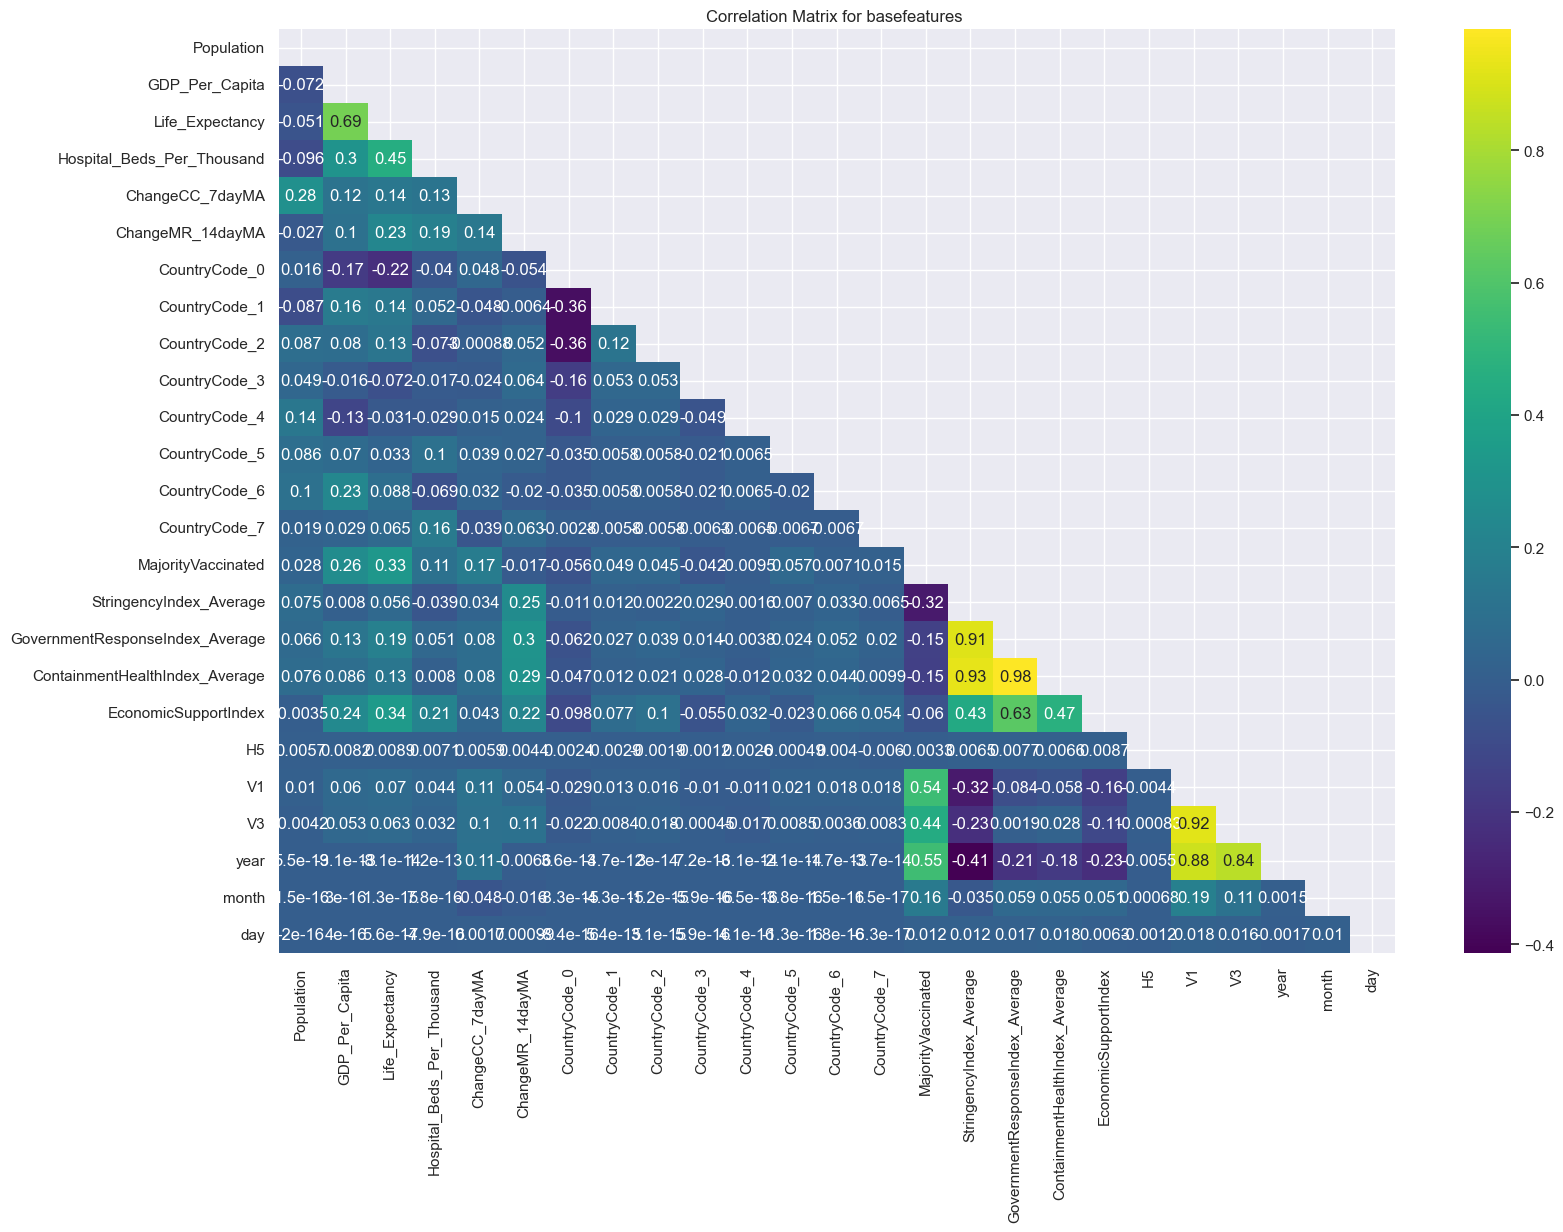

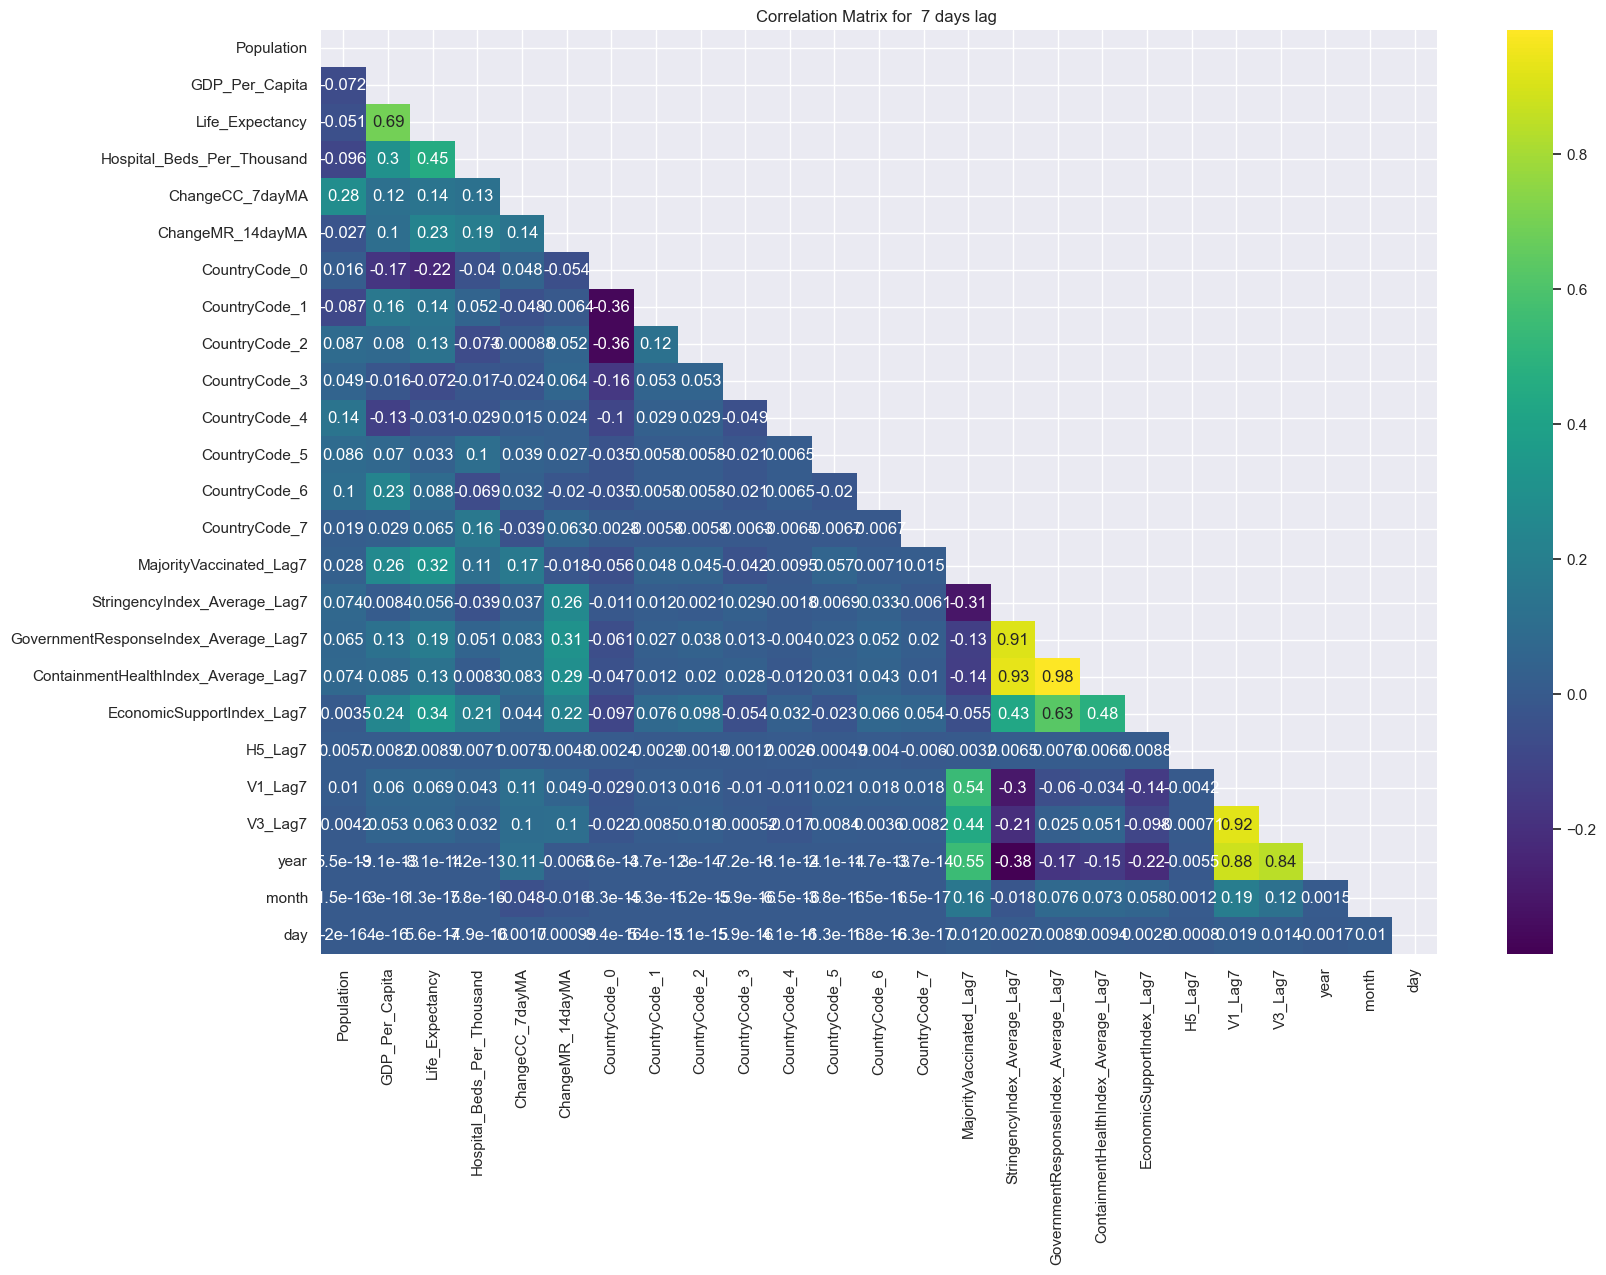

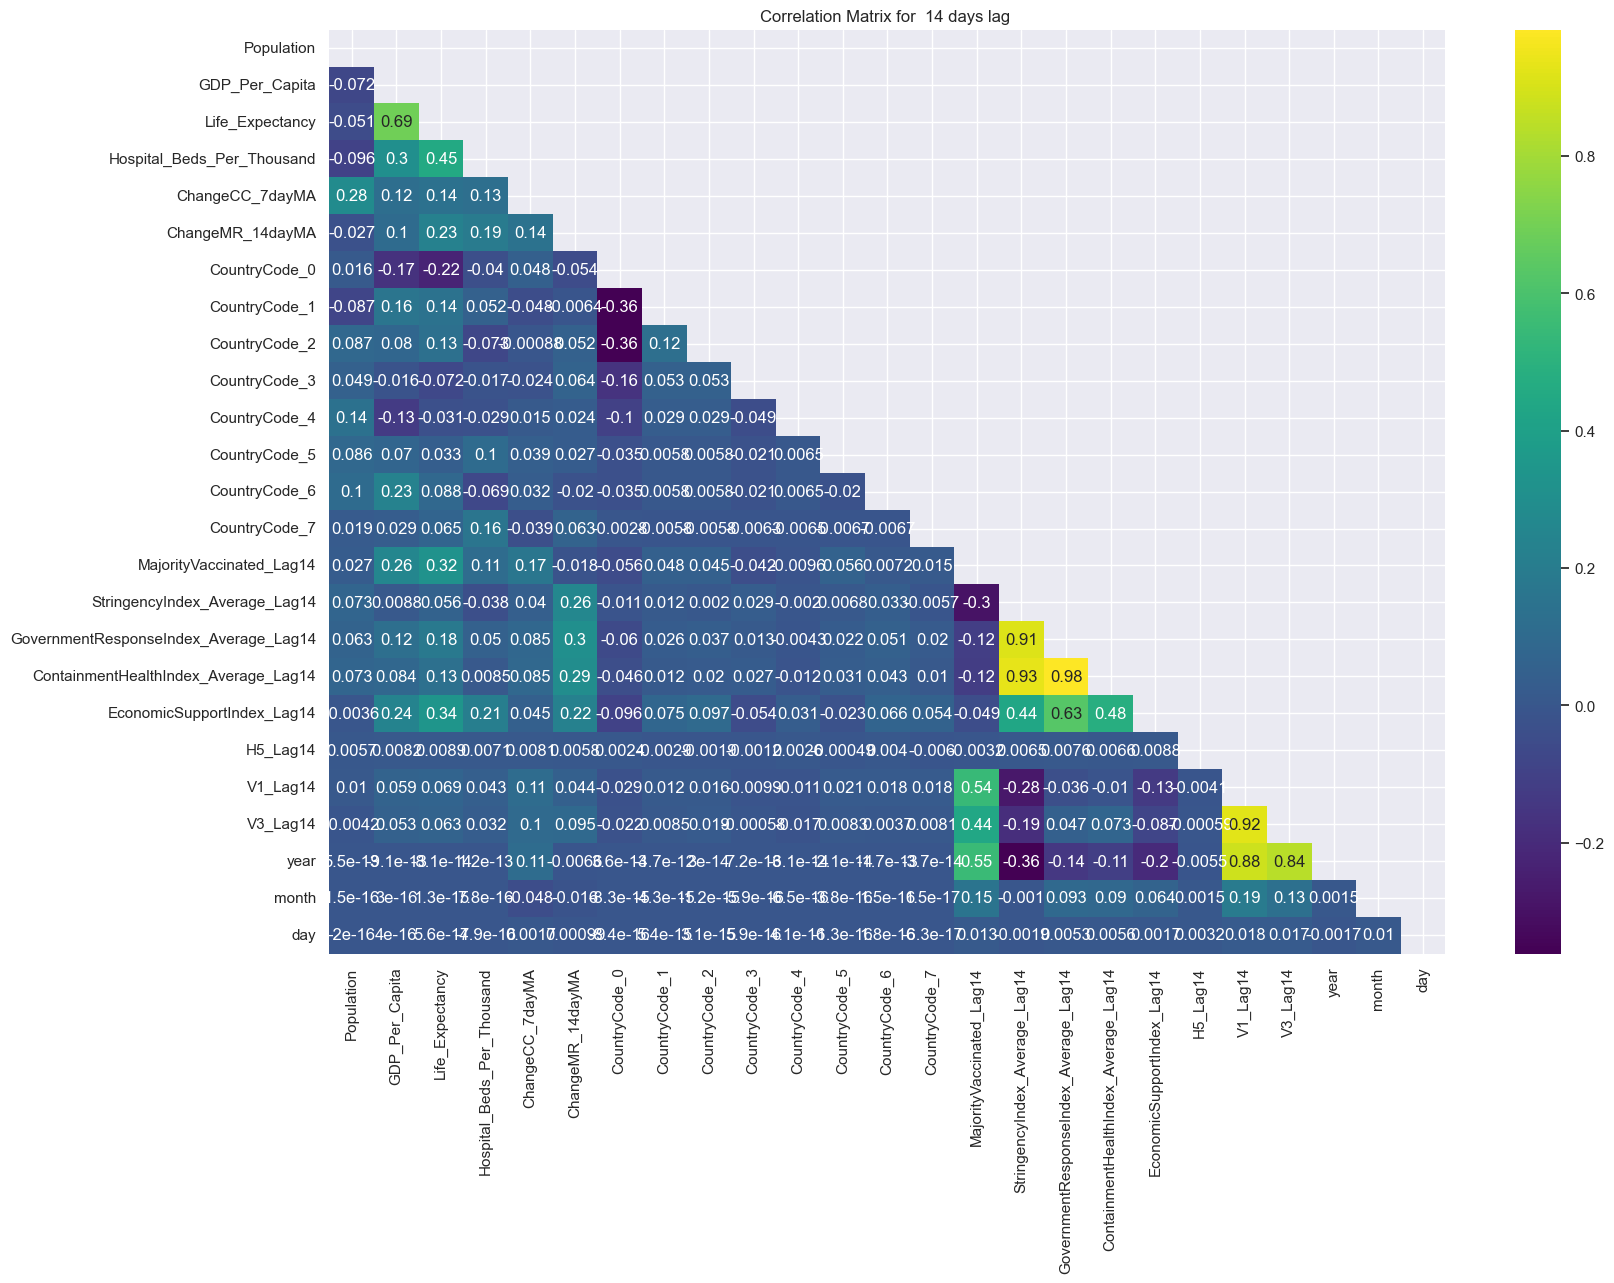

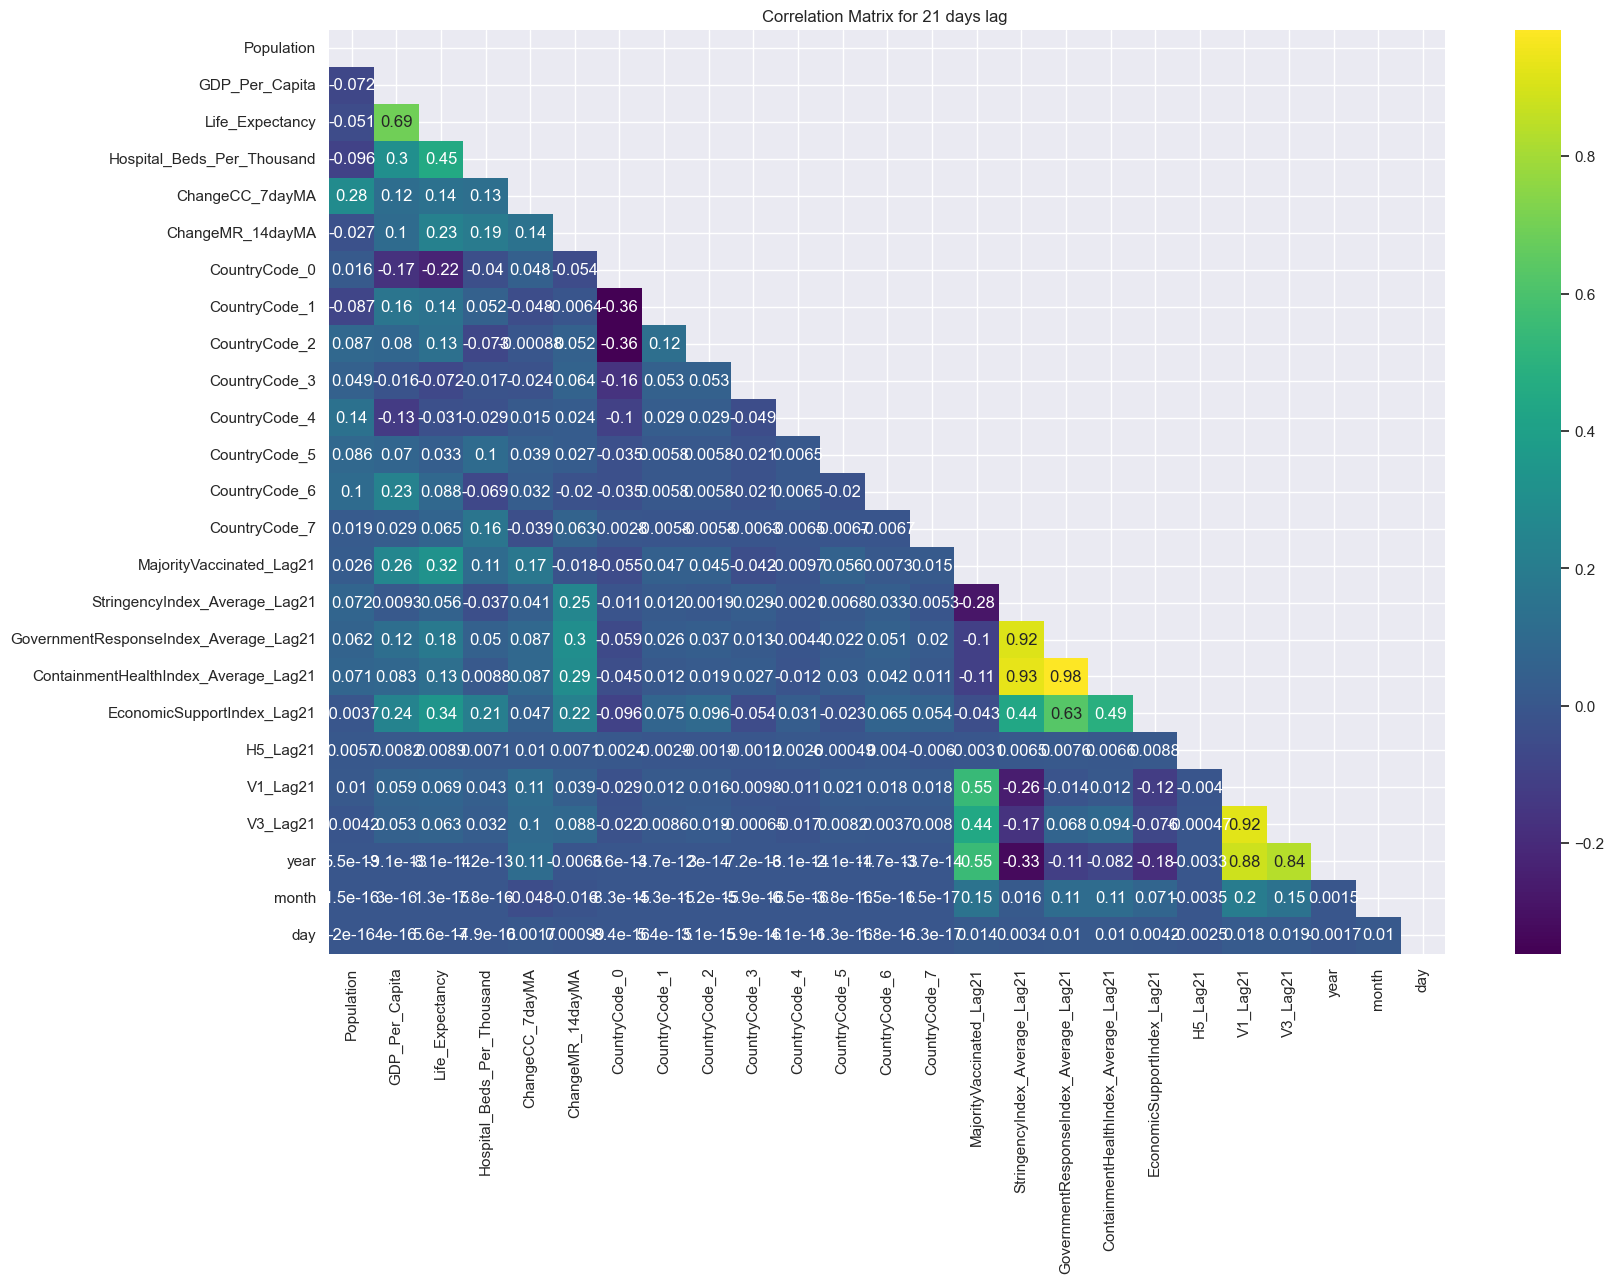

In [223]:
for key, value in model_dict.items():
    plt.figure(figsize=(18, 12))
    corr_matrix = value[0].corr(numeric_only=True)
    #if key == 'model':
    #    print(corr_matrix)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, cmap='viridis', annot=True) 
    plt.title(f'Correlation Matrix for {value[1]} ')
    plt.show()


#### Dropping Collinear features

In [224]:
model.drop(columns=['ContainmentHealthIndex_Average', 'StringencyIndex_Average'], inplace=True)
model7.drop(columns=['ContainmentHealthIndex_Average_Lag7', 'StringencyIndex_Average_Lag7'], inplace=True)
model14.drop(columns=['ContainmentHealthIndex_Average_Lag14', 'StringencyIndex_Average_Lag14'], inplace=True)


In [225]:
model21.drop(columns=['ContainmentHealthIndex_Average_Lag21', 'StringencyIndex_Average_Lag21'], inplace=True)

In [226]:
for key, value in model_dict.items():
    print(value[0].shape)

(163304, 25)
(163304, 25)
(163304, 25)
(163304, 25)


### Basic model 

In [227]:
here = model.groupby('Date').agg({'ChangeCC_7dayMA':'sum', 'ChangeMR_14dayMA':'sum', 'MajorityVaccinated':'sum', 'GovernmentResponseIndex_Average':'mean', 'EconomicSupportIndex':'mean', 'H5':'mean', 'V1':'mean', 'V3':'mean'}).reset_index()
here['Date'] = pd.to_datetime(here['Date'])
here['year'] = here['Date'].dt.year
here['month'] = here['Date'].dt.month
here['day'] = here['Date'].dt.day

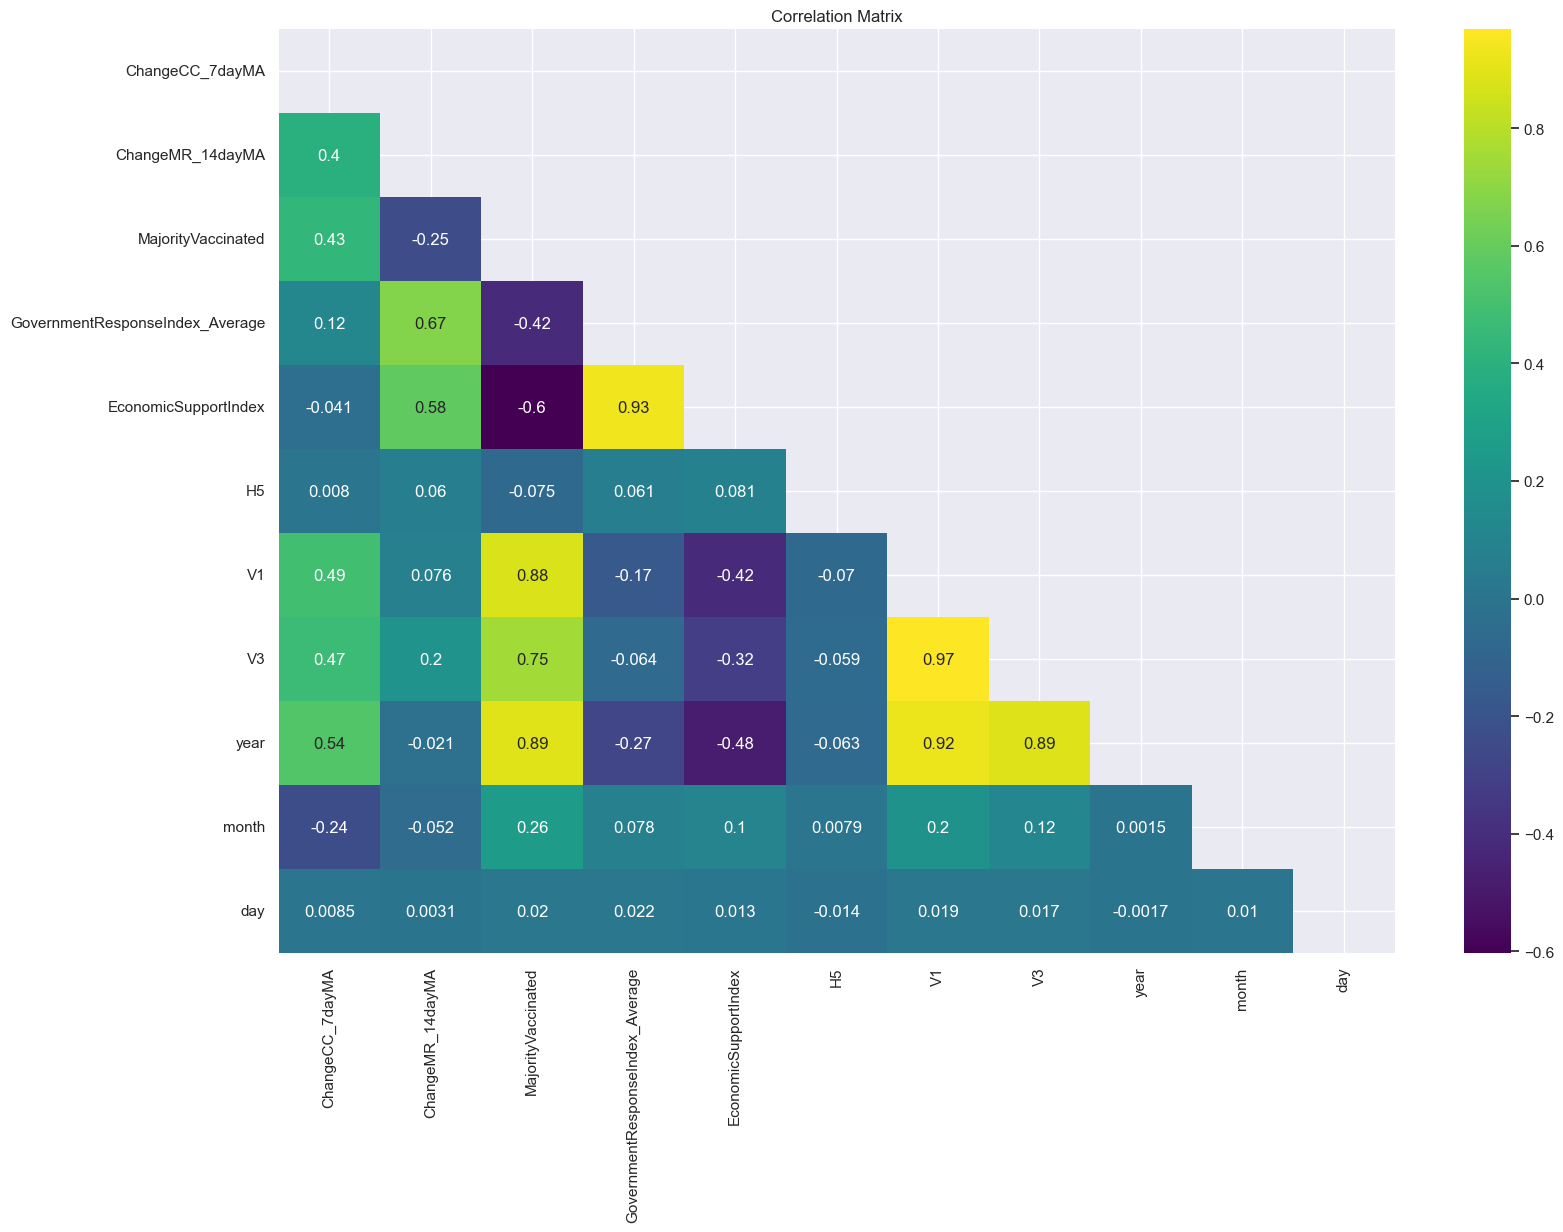

In [182]:
plt.figure(figsize=(18, 12))
corr_matrix = here.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='viridis', annot=True) 
plt.title(f'Correlation Matrix')
plt.show()

In [228]:
here.shape

(1096, 12)

In [229]:
here.drop(columns=['Date'], inplace=True)

In [230]:
here.head()

ChangeCC_7dayMA  ChangeMR_14dayMA  MajorityVaccinated  \
0              0.0               0.0                   0   
1              0.0               0.0                   0   
2              0.0               0.0                   0   
3              0.0               0.0                   0   
4              0.0               0.0                   0   

   GovernmentResponseIndex_Average  EconomicSupportIndex   H5   V1        V3  \
0                         0.132752                   0.0  0.0  0.0  0.006711   
1                         0.199195                   0.0  0.0  0.0  0.006711   
2                         0.220134                   0.0  0.0  0.0  0.006711   
3                         0.262081                   0.0  0.0  0.0  0.006711   
4                         0.262081                   0.0  0.0  0.0  0.006711   

   year  month  day  
0  2020      1    1  
1  2020      1    2  
2  2020      1    3  
3  2020      1    4  
4  2020      1    5

In [231]:
X = here.drop('ChangeMR_14dayMA', axis=1)
y = here['ChangeMR_14dayMA']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression(n_jobs=-1)

lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

model_dict['model'][2]['globalMR_r2'] = r2
model_dict['model'][2]['globalMR_mse'] = mse
model_dict['model'][2]['globalMR_rmse'] = rmse

In [232]:
print(model_dict['model'][2])

{'globalMR_r2': 0.6878070282764837, 'globalMR_mse': 0.004782801497469299, 'globalMR_rmse': 0.06915780142159884}


#### With 7D

In [233]:
here7 = model7.groupby('Date').agg({'ChangeCC_7dayMA':'sum', 'ChangeMR_14dayMA':'sum', 'MajorityVaccinated_Lag7':'sum', 'GovernmentResponseIndex_Average_Lag7':'mean', 'EconomicSupportIndex_Lag7':'mean', 'H5_Lag7':'mean', 'V1_Lag7':'mean', 'V3_Lag7':'mean'}).reset_index()
here7['Date'] = pd.to_datetime(here7['Date'])
here7['year'] = here7['Date'].dt.year
here7['month'] = here7['Date'].dt.month
here7['day'] = here7['Date'].dt.day
here7.drop(columns=['Date'], inplace=True)

In [234]:
X = here7.drop('ChangeMR_14dayMA', axis=1)
y = here7['ChangeMR_14dayMA']

In [235]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression(n_jobs=-1)

lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

model_dict['model7'][2]['globalMR_r2'] = r2
model_dict['model7'][2]['globalMR_mse'] = mse
model_dict['model7'][2]['globalMR_rmse'] = rmse

In [236]:
print(model_dict['model7'][2])

{'globalMR_r2': 0.6839473126798008, 'globalMR_mse': 0.004841932404336637, 'globalMR_rmse': 0.06958399531743371}


#### With 14 D

In [237]:
here14 = model14.groupby('Date').agg({'ChangeCC_7dayMA':'sum', 'ChangeMR_14dayMA':'sum', 'MajorityVaccinated_Lag14':'sum', 'GovernmentResponseIndex_Average_Lag14':'mean', 'EconomicSupportIndex_Lag14':'mean', 'H5_Lag14':'mean', 'V1_Lag14':'mean', 'V3_Lag14':'mean'}).reset_index()
here14['Date'] = pd.to_datetime(here14['Date'])
here14['year'] = here14['Date'].dt.year
here14['month'] = here14['Date'].dt.month
here14['day'] = here14['Date'].dt.day
here14.drop(columns=['Date'], inplace=True)

In [238]:
X = here14.drop('ChangeMR_14dayMA', axis=1)
y = here14['ChangeMR_14dayMA']

In [239]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression(n_jobs=-1)

lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

model_dict['model14'][2]['globalMR_r2'] = r2
model_dict['model14'][2]['globalMR_mse'] = mse
model_dict['model14'][2]['globalMR_rmse'] = rmse

In [240]:
print(model_dict['model14'][2])

{'globalMR_r2': 0.6884833451731365, 'globalMR_mse': 0.004772440311411149, 'globalMR_rmse': 0.06908285106602903}


#### With 21 D

In [241]:
here21 = model21.groupby('Date').agg({'ChangeCC_7dayMA':'sum', 'ChangeMR_14dayMA':'sum', 'MajorityVaccinated_Lag21':'sum', 'GovernmentResponseIndex_Average_Lag21':'mean', 'EconomicSupportIndex_Lag21':'mean', 'H5_Lag21':'mean', 'V1_Lag21':'mean', 'V3_Lag21':'mean'}).reset_index()
here21['Date'] = pd.to_datetime(here21['Date'])
here21['year'] = here21['Date'].dt.year
here21['month'] = here21['Date'].dt.month
here21['day'] = here21['Date'].dt.day
here21.drop(columns=['Date'], inplace=True)

X = here21.drop('ChangeMR_14dayMA', axis=1)
y = here21['ChangeMR_14dayMA']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression(n_jobs=-1)

lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

model_dict['model21'][2]['globalMR_r2'] = r2
model_dict['model21'][2]['globalMR_mse'] = mse
model_dict['model21'][2]['globalMR_rmse'] = rmse

In [242]:
print(model_dict['model21'][2])

{'globalMR_r2': 0.6915708090641735, 'globalMR_mse': 0.0047251403134646475, 'globalMR_rmse': 0.0687396560470348}


#### Plot r2 and mse across dfs

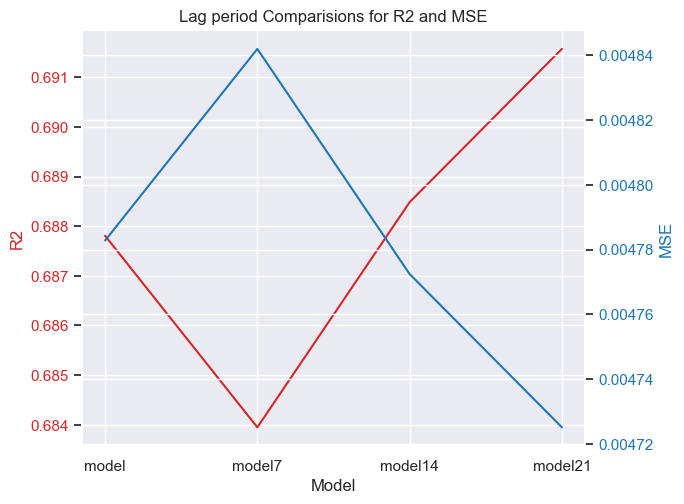

In [243]:
models = list(model_dict.keys())
globalMR_r2 = [model_dict[model][2]['globalMR_r2'] for model in models]
globalMR_mse = [model_dict[model][2]['globalMR_mse'] for model in models]

fig, ax1 = plt.subplots(figsize=(7,5))

color = 'tab:red'
ax1.set_xlabel('Model')
ax1.set_ylabel('R2', color=color)
ax1.plot(models, globalMR_r2, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('MSE', color=color)
ax2.plot(models, globalMR_mse, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Lag period Comparisions for R2 and MSE')
plt.show()

#### Model21 with Elastic Net 

In [258]:
X = here21.drop('ChangeMR_14dayMA', axis=1)
y = here21['ChangeMR_14dayMA']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

alpha = 0.3 
l1_ratio = 0.2 
iterations = [100, 300, 500, 700, 900, 1000, 1100, 1300, 1500]

lag21_dict = {}

for iteration in iterations:
    elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=iteration, random_state=42)
    elastic_net.fit(X_train_scaled, y_train)
    y_pred = elastic_net.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    lag21_dict[iteration] = {'r2': r2, 'mse': mse, 'rmse': rmse}
    
lag21_dict

{100: {'r2': 0.19830302149215617,
  'mse': 0.012282010988766603,
  'rmse': 0.11082423466357258},
 300: {'r2': 0.19830302149215617,
  'mse': 0.012282010988766603,
  'rmse': 0.11082423466357258},
 500: {'r2': 0.19830302149215617,
  'mse': 0.012282010988766603,
  'rmse': 0.11082423466357258},
 700: {'r2': 0.19830302149215617,
  'mse': 0.012282010988766603,
  'rmse': 0.11082423466357258},
 900: {'r2': 0.19830302149215617,
  'mse': 0.012282010988766603,
  'rmse': 0.11082423466357258},
 1000: {'r2': 0.19830302149215617,
  'mse': 0.012282010988766603,
  'rmse': 0.11082423466357258},
 1100: {'r2': 0.19830302149215617,
  'mse': 0.012282010988766603,
  'rmse': 0.11082423466357258},
 1300: {'r2': 0.19830302149215617,
  'mse': 0.012282010988766603,
  'rmse': 0.11082423466357258},
 1500: {'r2': 0.19830302149215617,
  'mse': 0.012282010988766603,
  'rmse': 0.11082423466357258}}

##### no differece with change in max iterations

#### 21 D with Elastic Net and Grid Search

In [ ]:
X = here21.drop('ChangeMR_14dayMA', axis=1)
y = here21['ChangeMR_14dayMA']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()

parameters = {
    'alpha': [0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0],
    'l1_ratio': [0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 1.0]
}

elastic_net = ElasticNet(max_iter=1000, n_jobs=-1, random_state=42)
pipeline = Pipeline([
    ('scale', scaler),
    ('enet', elastic_net)
])

grid = GridSearchCV(estimator=pipeline, param_grid=parameters, cv=5, scoring='r2')
grid.fit(X_train, y_train)

results21 = grid.cv_results_
best_params21 = grid.best_params_
best_score21 = grid.best_score_

best_model21 = grid.best_estimator_
y_pred = best_model21.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

alpha = best_params21['alpha']
l1_ratio = best_params21['l1_ratio']
parameters = f"alpha({alpha})__l1Ratio({l1_ratio}"

model_dict['model21'][2]['globalMR_ENGS_r2'][f'{parameters}'] = r2
model_dict['model21'][2]['globalMR_ENGS_mse'][f'{parameters}'] = mse
model_dict['model21'][2]['globalMR_ENGS_rmse'][f'{parameters}'] = rmse

#### 14 D with Elastic Net and Grid Search 

#### 7 D with Elastic Net and Grid Search

#### Plot r2 and mse across dfs

#### Iterations for Best Model

### Feature Selection using L1 part of Elastic Net

In [ ]:
#feature_importance = best_model.named_steps['enet'].coef_
#significant_features = {feature: coef for feature, coef in zip(X.columns, feature_importance) if coef != 0}

### Polynomial Regression

#### With 7 D

#### With 14 D

#### With 21 D

### Classification Model 

In [40]:
policyEffective = df_WithLag_encoded[modelCols + ['changeInMR']]

policyEffective['Date'] = pd.to_datetime(policyEffective['Date'])

policyEffective['year'] = policyEffective['Date'].dt.year
policyEffective['month'] = policyEffective['Date'].dt.month
policyEffective['day'] = policyEffective['Date'].dt.day


In [41]:
policyEffective['changeinDailyDeaths'] = policyEffective.groupby('CountryCode')['changeInMR'].diff()

In [42]:
policyEffective[policyEffective['CountryCode'] == 'IND']['changeinDailyDeaths']

76                 NaN
150       0.000000e+00
413       0.000000e+00
573       0.000000e+00
748       0.000000e+00
              ...     
163705   -7.056301e-07
163853    1.411260e-06
164087   -7.056301e-07
164100    1.411260e-06
164277    1.110223e-16
Name: changeinDailyDeaths, Length: 1096, dtype: float64

In [43]:
conditions = [
    policyEffective['changeinDailyDeaths'] > 0,  
    policyEffective['changeinDailyDeaths'] == 0, 
    policyEffective['changeinDailyDeaths'] < 0   
]

choices = [0, 1, 2] 

policyEffective['EncodedEffectiveness'] = np.select(conditions, choices)

In [44]:
policyEffective[policyEffective['CountryCode'] == 'IND']['EncodedEffectiveness']

76        0
150       1
413       1
573       1
748       1
         ..
163705    2
163853    0
164087    2
164100    0
164277    0
Name: EncodedEffectiveness, Length: 1096, dtype: int64